General code
---

In [1]:
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
torch.set_float32_matmul_precision('medium')
device = "cuda"

In [2]:
# Import datasets
from torchvision.transforms import ToTensor

torch.cuda.empty_cache()
batch_size = 128
train_dataset = datasets.MNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(),
    )
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=16, pin_memory=True, persistent_workers=True,
)
test_dataset = datasets.MNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    # num_workers=4, pin_memory=True, persistent_workers=False,
)

In [ ]:
# Define training loop
from tqdm.notebook import tqdm

p = 0.2
MSELoss = nn.MSELoss(reduction='mean')
CELoss = nn.CrossEntropyLoss(reduction='mean')

def tloop(model, dataloader, forward_pass, training=True, num_epochs=1, num_evals=10,
          optimizer=None, train_losses=None, encoder=None, scheduler=None, verbose=True):
    """General training and evaluation loop"""
    if training:
        if optimizer is None:
            optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
        if scheduler is None:
            scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, start_factor=1.0, end_factor=1.0,
                total_iters=num_epochs)
    if verbose: print(f"{'Training' if training else 'Testing'} {model.__class__}...")
    model.train() if training else model.eval()

    train_losses = train_losses if train_losses is not None else []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        total_loss = 0
        num_loss = 0

        for x, y in tqdm(dataloader, desc="Batches", leave=False):
            x, y = x.to(device), y.to(device)
            loss, acc = forward_pass(model, x, y, encoder)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += acc.item()
            num_loss += x.shape[0]
        if training:
            scheduler.step()
        train_losses.append(total_loss / num_loss)
        if train_losses[-1] < 25 or (verbose and training and epoch % (num_epochs // num_evals) == 0):
            print(f'Epoch {epoch}, train loss: {train_losses[-1]}')

    if not training and verbose:
        print(f"Average loss in test set: {total_loss/num_loss}")
    return train_losses

def forward_classification(model, x, y, topk=1):
    y_hat = model(x)
    loss = CELoss(y_hat, y)  # y_hat: logits. y: labels or probs
    _, indices = torch.topk(y_hat, topk, dim=1)
    is_correct = torch.any(indices == y.view(-1, 1), dim=1)
    acc = 100 * torch.mean(is_correct.to(torch.float32))
    return loss, acc

def forward_autoencoding(model, x, y):
    x_hat = model(x)
    loss = torch.sum(torch.abs(x_hat - x)**1) / x.shape[0]
    return loss, loss

def sample_x0_t(x1):
    """Randomly samples x0 and t"""
    x0 = torch.normal(torch.zeros_like(x1), torch.ones_like(x1)).view(x1.shape)
    t = torch.rand((x1.shape[0], 1, 1, 1), device=device)  ###
    return x0, t

def erase_label(y, p):
    """Erases the labels in y independently with probability p"""
    unif = torch.rand_like(y.to(torch.float32)).view(-1, 1).repeat(1, 10)
    y = nn.functional.one_hot(y.to(torch.long), num_classes=10).to(torch.float32)
    return torch.where(unif < p, torch.zeros_like(y), y)

def forward_denoising(model, x, y):
    y = erase_label(y, p=p)
    x0, t = sample_x0_t(x)
    xt = (1 - t) * x0 + t * x
    vf = x - x0
    vf_hat = model(xt, t, y)
    loss = MSELoss(vf_hat, vf)
    return loss, loss

def forward_var_aut(model, x, y):
    """
    Computes MSE and KL losses. Note that sigma is fixed.
    x: (B, C, H, W)
    z: (B, ...)
    returns (mse_loss, kl_loss)
    """
    B = x.shape[0]
    mu, var = model.get_encoding(x)
    ep = torch.normal(torch.zeros_like(mu), torch.ones_like(mu)).view(mu.shape)
    z = mu + torch.sqrt(var) * ep
    x_hat, sigma = model.get_decoding(z)

    mse_loss = torch.sum((x_hat - x)**2 / sigma) / B
    kl_loss = torch.sum(var - torch.log(var) + mu**2) / B
    return mse_loss, kl_loss  # avg over batches

def plot_train_losses(train_losses, log=False):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(train_losses[0:], label='Train Loss')
    ax.set_title('Training Loss/Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss/Accuracy')
    if log: ax.set_xscale('log')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# Functions to generate and classify images

def product_dims(shape):
    p = 1
    for s in shape:
        p *= s
    return p

def flow(denoiser, x, t, y, w=1):
    """Returns the flow using the denoiser(x, t, y) NN"""
    no_y = torch.zeros_like(y)
    return w * denoiser(x, t, y) + (1 - w) * denoiser(x, t, no_y)

def score(denoiser, x, t, y, w=1):
    """Returns the score asuming that denoiser is the flow"""
    return (t * flow(denoiser, x, t, y, w=w) - x)/((1 - t)**2 + t * (1-t))

def EulerMaruyama(f, g, x0, num_steps=200, device='cuda'):
    """Returns the solution of dx = f(x, t)dt + g(x, t)dW at t=1
    both x0 and output are in device"""
    h = 1/num_steps
    x = x0
    B = x.shape[0]
    for n in range(num_steps):
        t = torch.tensor(n*h, device=device, dtype=torch.float32).repeat(B, 1, 1, 1)  ###
        ep = torch.normal(torch.zeros_like(x), torch.ones_like(x)).view(x.shape)
        x = x + f(x, t) * h + g(x, t) * np.sqrt(h) * ep
    return x

def generate_images(denoiser, decoder, num_img, sigma, size=(1, 7, 7), labels=None, w=1, device='cuda', num_steps=50):
    """Generates images using the provided denoiser and autoencoder
    output is a tensor of shape (num_img, 1, 28, 28)
    labels: list of length num_img with the labels, None refers to no labels"""
    ones = torch.ones(num_img * product_dims(size), device=device, dtype=torch.float32)
    x0 = torch.normal(0 * ones, ones).view(num_img, *size)
    if labels:
        labels = [k if k is not None else 10 for k in labels]
        y = torch.tensor(labels, device=device)
        y = nn.functional.one_hot(y, num_classes=11).to(torch.float32)  # (B, 11)
        y = y[:, :-1]
    else:
        y = torch.zeros((num_img, 10), dtype=torch.float32, device=device)

    f = lambda x, t: flow(denoiser, x, t, y, w) + 0.5 * sigma(t)**2 * score(denoiser, x, t, y)
    g = lambda x, t: sigma(t)
    z1 = EulerMaruyama(f, g, x0, num_steps=num_steps, device=device)
    x1 = decoder(z1)
    return torch.clip(x1, 0, 1)

def calculate_density(vae, flowmatching, sigma, x, y=None, device='cuda', num_steps=50):
    """Find the density of x: (B, 1, 28, 28) given the label"""
    if y is None:
        y = torch.zeros((x.shape[0], 10), dtype=torch.float32, device=device)
    z1 = vae.encode(x)
    f = lambda z, t: - flowmatching(z, 1 - t, y) - 0.5 * sigma(1 - t)**2 * score(flowmatching, z, 1 - 1/num_steps - t, y)
    g = lambda z, t: sigma(1 - t)
    z0 = EulerMaruyama(f, g, z1, num_steps=num_steps, device=device)  # from N(0, I)
    return torch.exp(-torch.sum(z0**2, dim=(1, 2, 3)) / 2) / (2 * torch.pi)**(product_dims(z0.shape[1:]) / 2)

In [5]:
# lr scheduler
class CustomLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    """The learning rate decays exponentially up to factor * initial_lr after warmup_epochs"""
    def __init__(self, optimizer, initial_lr, total_epochs, warmup_epochs=10, factor=0.02):
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.factor = factor  # Controls how fast the learning rate decays
        super().__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            return [self.initial_lr for _ in self.base_lrs]  # Flat start

        decay = self.factor**((epoch - self.warmup_epochs)/(self.total_epochs - self.warmup_epochs))
        return [self.initial_lr * decay for _ in self.base_lrs]

In [6]:
# Define Lighting model
import pytorch_lightning as pl

class GeneralModel(pl.LightningModule):
    def __init__(self, model, forward_pass, optimizer, scheduler, transpose=False):
        super().__init__()
        self.model = model
        self.forward_pass = forward_pass
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.transpose = transpose

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss, acc = self.forward_pass(self.model, x, y)
        self.log("mse_step", acc, on_epoch=False, prog_bar=True)
        self.log("mse_epoch", acc, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss, acc = self.forward_pass(self.model, x, y)
        self.log("val_loss", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss, acc = self.forward_pass(self.model, x, y)
        self.log("test_loss", acc, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        mse = self.trainer.callback_metrics.get("mse_epoch")
        if mse is not None:
            print(f"Epoch {self.current_epoch} - train_mse: {mse:.4f}")

    def on_validation_epoch_end(self):
        acc = self.trainer.callback_metrics.get("val_loss")
        if acc is not None:
            print(f"Epoch {self.current_epoch} - val_acc: {acc:.4f}")

    def configure_optimizers(self):
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

class ClassifierModel(GeneralModel):
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss, acc = self.forward_pass(self.model, x, y)
        self.log("loss_step", loss, on_epoch=False, prog_bar=True)
        self.log("loss_epoch", loss, on_epoch=True, prog_bar=False)
        self.log("acc_step", acc, on_epoch=False, prog_bar=True)
        self.log("acc_epoch", acc, on_epoch=True, prog_bar=False)
        return loss

    def on_train_epoch_end(self):
        acc = self.trainer.callback_metrics.get("acc_epoch")
        loss = self.trainer.callback_metrics.get('loss_epoch')
        if acc is not None and loss is not None:
            print(f"Epoch {self.current_epoch} - train_acc: {acc:.2f}%, train_loss: {loss:.4f}")

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        _, acc1 = self.forward_pass(self.model, x, y)
        _, acc2 = self.forward_pass(self.model, x, y, topk=2)
        self.log("top1_acc", acc1, on_epoch=True, prog_bar=True)
        self.log("top2_acc", acc2, on_epoch=True, prog_bar=True)

class VAEModel(GeneralModel):
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss_mse, loss_kl = self.forward_pass(self.model, x, y)
        loss = loss_mse + loss_kl

        # normalize losses and log results
        loss_mse *= self.model.sigma
        loss_kl -= product_dims(self.model.z_shape)

        self.log("mse_step", loss_mse, on_epoch=False, prog_bar=True)
        self.log("mse_epoch", loss_mse, on_epoch=True, prog_bar=False)

        self.log("kl_step", loss_kl, on_epoch=False, prog_bar=True)
        self.log("kl_epoch", loss_kl, on_epoch=True, prog_bar=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        if self.transpose: x = x.transpose(-1, -2)
        loss_mse, loss_kl = self.forward_pass(self.model, x, y)
        loss = loss_kl + loss_mse

        # normalize losses and log results
        loss_mse *= self.model.sigma
        loss_kl -= product_dims(self.model.z_shape)

        self.log("mse_step", loss_mse, on_epoch=False, prog_bar=True)
        self.log("mse_epoch", loss_mse, on_epoch=True, prog_bar=False)

        self.log("kl_step", loss_kl, on_epoch=False, prog_bar=True)
        self.log("kl_epoch", loss_kl, on_epoch=True, prog_bar=False)

        return loss

    def on_train_epoch_end(self):
        mse = self.trainer.callback_metrics.get("mse_epoch")
        kl = self.trainer.callback_metrics.get("kl_epoch")
        if mse is not None and kl is not None:
            print(f"Epoch {self.current_epoch} - train_mse: {mse:.4f}, train_kl: {kl:.4f}")

    def on_validation_epoch_end(self):
        mse = self.trainer.callback_metrics.get("mse_epoch")
        kl = self.trainer.callback_metrics.get("mse_epoch")
        if mse is not None and kl is not None:
            print(f"Epoch {self.current_epoch} - val_mse: {mse:.4f}, val_kl: {kl:.4f}")

In [7]:
# function to plot a sequence of images
def plot_images(images, figsize=(12, 4)):
    """images: hxw array of 2d images to plot"""
    h, w = len(images), len(images[0])
    fig, axs = plt.subplots(h, w, figsize=figsize)
    if h == 1: axs = [axs]
    for i in range(h):
        for j in range(w):
            axs[i][j].imshow(images[i][j], cmap='gray')
            axs[i][j].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# Playing on the embedding space
def plot_interpolation(autoencoder, use_vae=False, s=4, scale=1.4, transpose=False):
    """
    vae: bool or float with the randomness in encoding. 0.01 is standard
    s: grid will be size 2*s+1
    scale: how big each image should be
    This will be impossible to debug and i know it. The idea is to do the same
    in each triangle of the grid.
    """
    h, w = 2*s + 1, 2*s + 1
    # get three images for the corners
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=4)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)  # (4, 1, 28, 28)
            if transpose: x = x.transpose(-1, -2)
            break
    # get embeddings of the images
    with torch.no_grad():
        z_c = autoencoder.encode(x) if use_vae else autoencoder.encoder(x)

    def extract_coeffs(pos):
        """pos: (i, j) in the grid
        Returns (a, b, c) s.t. a*c1 + b*c2 + c*c3 = pos,
        where all coeffs sum to 1"""
        # center grid: c1 -> -1, c2 -> -i, c3 -> +i
        pos = (pos[0] + pos[1]*1j - s - s*1j) / (s + s*1j)
        # get coeffs
        i, j = pos.real, pos.imag
        # a + b + c = 1
        # - a = i, c - b = j
        return torch.tensor([-i, (1 - j + i)/2, (1 + j + i)/2], device=device).view(-1, 1, 1, 1)

    reconstructions = np.zeros((h, w, 28, 28))
    for i in range(h):
        for j in range(w):
            if j <= h - 1 - i:
                coeffs = extract_coeffs((i, j))
                z = torch.sum(coeffs * z_c[:-1], dim=0, keepdim=True)  # (1, 1, 28, 28)
            else:
                coeffs = extract_coeffs((h - 1 - i, w - 1 - j))
                z = torch.sum(coeffs * z_c[1:], dim=0, keepdim=True)  # (1, 1, 28, 28)
            x_hat = autoencoder.decode(z) if use_vae else autoencoder.decoder(z)
            x_hat = torch.clip(x_hat[:, 0], 0, 1)
            reconstructions[i, j] = x_hat.cpu().detach()[0]

    plot_images(np.array(reconstructions), figsize=(scale*w, scale*h))

In [9]:
# Save and load models
import os

model_name = "EMNIST_classifier_big"
save_path = os.path.join("..", "NN_parameters", "Generative models", model_name + ".pth")

# # Save model
# torch.save(classifier.state_dict(), save_path)
# print(f"Model saved to {save_path}")

# # Load model
# classifier = Classifier(d1=64, d2=96, k=6, n=2, n_heads=8, head_dim=8).to(device)
# classifier.load_state_dict(torch.load(save_path))

# autoencoder uses final architecture with d=8, k=2, r=3

Classify MNIST
---

Here I train a convolutional network to solve the MNIST dataset. I use GPU and CPU to see the differences in speed.

- The GPU network took 2 min to run 10 epochs with batch size 64. It reached 98.23% accuracy on the test set.

- The CPU network took 2:30 min to run 3 epochs with batch size 64. It reached 96.49% accuracy on the test set.

- The GPU took 61 seconds to run 10 epochs with batch size 256.

- The CPU took 42 seconds to run 2 epochs with batch size 256.

In this setting, the GPU is 4.16 times faster than the CPU for the first case, and 3.5 times faster in the second.

- 1:51 min for 10 epochs with batch size 128, gpu, and default number of workers.

- 1:58 min for the same but with 4 workers.

Probably the bottleneck here is the CPU.

Update later: the GPU is many more times faster but I was not using persistent_workers=True

In [ ]:
# Load MNIST dataset
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

train_dataset = datasets.FashionMNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(),
    )
test_dataset = datasets.FashionMNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=8, persistent_workers=True, pin_memory=True,
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, persistent_workers=True, pin_memory=True,
    )

In [ ]:
# Define network
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # sizes: 784 -> 1440 -> 32 -> 10
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=5)  # -> 24x24 -> 12x12
        self.cnn2 = nn.Conv2d(10, 2, kernel_size=5)  # -> 8x8 -> 4x4
        self.linear = nn.Linear(2 * 4 * 4, 10)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.ac(self.max(self.cnn1(x)))
        x = self.ac(self.max(self.cnn2(x)))
        x = x.view(-1, 2 * 4 * 4)
        x = self.linear(x)
        return self.sm(x)

model = MNISTClassifier().to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

In [ ]:
# train and validation loop
from tqdm.notebook import tqdm

new_model = True

num_epochs = 10
loss_fn = nn.CrossEntropyLoss(reduction='sum')

if new_model:
    losses = []
    accuracies = []
    model = MNISTClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    total_loss = 0
    num_loss = 0
    for x, y in tqdm(train_loader, desc="Batches", leave=False):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_loss += x.shape[0]
    losses.append(total_loss / num_loss)

    model.eval()
    total_acc = 0
    num_acc = 0
    for x, y in tqdm(test_loader, desc="Batches", leave=False):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        y_hat = torch.argmax(y_pred, dim=-1)
        acc = (y == y_hat).float().sum()

        total_acc += acc.item()
        num_acc += x.shape[0]
    accuracies.append(100 * total_acc / num_acc)

    print(f"Epoch {epoch}: train_loss={round(losses[-1], 3)}, val_acc={accuracies[-1]}")

Next three cells are a bad attempt at lightning

In [ ]:
import lightning as L
import torchmetrics
from pytorch_lightning.utilities import rank_zero_info

lr = 0.001

class LitMNISTClassifier(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        self.acc_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.total_acc = 0  # sum of accuracies accross batches
        self.num_acc = 0  # number of validation points

        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnn1 = nn.Conv2d(1, 5, kernel_size=5)  # -> 24x24 -> 12x12
        self.cnn2 = nn.Conv2d(5, 5, kernel_size=5)  # -> 8x8 -> 4x4
        self.cnn3 = nn.Conv2d(5, 10, kernel_size=4, stride=4)  # -> 4x4 -> 1x1
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.ac(self.max(self.cnn1(x)))
        x = self.ac(self.max(self.cnn2(x)))
        x = self.cnn3(x)
        x = x.view(-1, 10)
        return self.sm(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss_fn(output, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        y_hat = torch.argmax(output, dim=1)
        acc = self.acc_fn(y_hat, y)
        # self.total_acc += acc.item()
        # self.num_acc += x.shape[0]
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr)

    def on_validation_epoch_end(self):
        # acc = self.total_acc / self.num_acc * 100
        # accuracies.append(acc)
        # rank_zero_info(f"Validation accuracy: {acc}")
        # self.total_acc = 0
        # self.num_acc = 0
        avg_acc = 100 * self.trainer.callback_metrics["val_acc"].item()
        print(f"Validation accuracy: {avg_acc}")

model = LitMNISTClassifier().to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

In [ ]:
# define trainer
trainer = L.Trainer(
    max_epochs=2,
    accelerator="gpu",
    log_every_n_steps=1,
    )

# save results
losses = []
accuracies = []

# train model
trainer.fit(model, train_loader, test_loader)

In [ ]:
model.eval()
for x, y in test_loader:
    y_hat = torch.argmax(model(x), dim=1)
    acc = torch.sum(y_hat == y)/x.shape[0] * 100
    print(f"Test accuracy: {acc}")
    break

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot losses
ax1.plot(losses, label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training loss')
# ax1.set_xscale('log')
ax1.legend()

# Plot accuracies
ax2.plot(accuracies, label='Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
# ax2.set_xscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# show a missclasified image
num_image = 10
counter = 0

for idx, (x, y) in enumerate(test_loader):
    x, y = x.to(device), y.to(device)
    output = model(x)
    y_hat = torch.argmax(output, dim=1)
    num_miss = (y != y_hat).sum()
    if num_miss > 0:
        idxs = (y != y_hat).nonzero(as_tuple=True)[0]
        for j in range(num_miss):
            if counter < num_image:
                counter += 1
                continue
            else:
                miss_img = x[idxs[j], 0].cpu().numpy()
                plt.imshow(miss_img, cmap='gray')
                plt.axis('off')
                plt.title(f'Predicted: {y_hat[i].item()}')
                plt.show()
        if counter == num_image:
            break

In [ ]:
import os

save_path = os.path.join("..", "NN_parameters", "small_MNIST_classifier.pth")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Generate MNIST
---

Instead of classifying images I will implement a diffussion model to generate new samples.

In particular, I will use the linear flow/diffussion model method, I will train for the vector field and use the formula to recover the score.

Using batch_size=128 and 4 workers, the model ran 50 epochs in 14:18 min, which is approx 17s per epoch, arround 3 times as much as before. However, it seems that most of the time was spent by the CPU while moving stuff around rather than doing computations in teh GPU.

After making some changes (16 workers, keeping them alive, keeping the dataset in GPU), it does the same 50 epochs in 2:26 min, which is approx 3s per epoch.

Notes from the class:
- Train the diffussion model in the latent space of an autoencoder.
- U-net and Diffussion Transformers are good architectures.
- Embed t and y on each layer, and one way to do it is to convert them into dimension num_channels and add them.

In [2]:
batch_size = 128
device = "cuda"
print(f"device: {device}")

device: cuda


In [5]:
# MBConv2d and Autoencoder
import os

class MBConv2d(nn.Module):
    """
    Input and output are images of the same shape. C -> C or C -> C/2
    """
    def __init__(self, in_channels, out_channels, activation_fn):
        super().__init__()
        d1, d2 = in_channels, out_channels
        assert d1 == d2 or d1 == 2 * d2, "MBConv2d inputs are invalid"
        self.twice = d1 == 2 * d2

        self.network = nn.Sequential(
            nn.Conv2d(d1, 6*d1, kernel_size=1),
            activation_fn,
            nn.Conv2d(6*d1, 6*d2, kernel_size=3, padding=1, groups=6*d2),
            activation_fn,
            nn.Conv2d(6*d2, d2, kernel_size=1),
        )

    def forward(self, x):
        y = (x[:, ::2] + x[:, 1::2])/2 if self.twice else x
        return y + self.network(x)

class AutoEncoder(nn.Module):
    """Reduces the 28x28 image into size 7x7.
    d: dimension of the pixel feature representation.
    Trained models use d=8 (4K params) or d=16 (25K params)"""
    def __init__(self, d=8):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up   = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            self.ac,
            MBConv2d(d, d, self.ac),    # -> 28x28
            self.max,                   # -> 14x14
            MBConv2d(d, d, self.ac),    # -> 14x14
            self.max,                   # -> 7x7
            MBConv2d(d, d, self.ac),    # -> 7x7
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            MBConv2d(d, d, self.ac),    # -> 7x7
            self.up,                    # -> 14x14
            MBConv2d(d, d, self.ac),  # -> 14x14
            self.up,                    # -> 28x28
            MBConv2d(d, d, self.ac),  # -> 28x28
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model_name = "MNIST_autoencoder"
save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
autoencoder = AutoEncoder(d=16).to(device)
autoencoder.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [4]:
# Load MNIST dataset
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(),
    )
test_dataset = datasets.MNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=16, pin_memory=True, persistent_workers=True,
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=False, persistent_workers=False,
    )

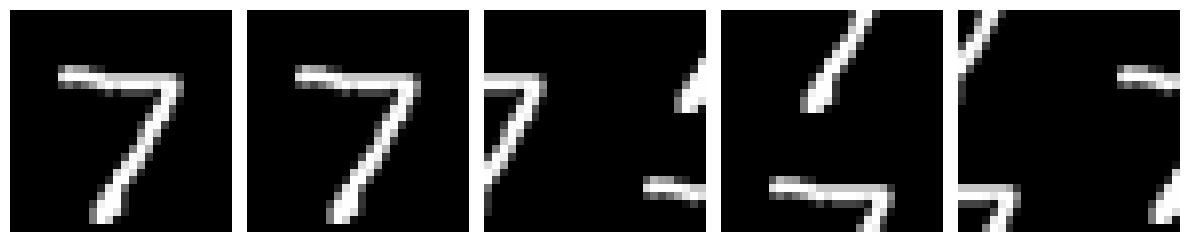

In [94]:
# Data augmentation: define cyclic_permutations
import matplotlib.pyplot as plt

def cyclic_permutations(x):
    """Makes 3 copies of x by dividing into 14x14 images
    and overlapping. output is (-1, 4, 28, 28)"""
    q00 = x[:, 0, :14, :14]  # Top-left
    q01 = x[:, 0, :14, 14:]  # Top-right
    q10 = x[:, 0, 14:, :14]  # Bottom-left
    q11 = x[:, 0, 14:, 14:]  # Bottom-right

    y = x.repeat(1, 4, 1, 1)

    y[:, 1, :14, :14] = q01
    y[:, 1, :14, 14:] = q10
    y[:, 1, 14:, :14] = q11
    y[:, 1, 14:, 14:] = q00

    y[:, 2, :14, :14] = q10
    y[:, 2, :14, 14:] = q11
    y[:, 2, 14:, :14] = q00
    y[:, 2, 14:, 14:] = q01

    y[:, 3, :14, :14] = q11
    y[:, 3, :14, 14:] = q00
    y[:, 3, 14:, :14] = q01
    y[:, 3, 14:, 14:] = q10

    return y

for x, y in test_loader:
    break
y = cyclic_permutations(x)
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 5))
ax0.imshow(x[0, 0], cmap='gray')
ax0.axis('off')
ax1.imshow(y[0, 0], cmap='gray')
ax1.axis('off')
ax2.imshow(y[0, 1], cmap='gray')
ax2.axis('off')
ax3.imshow(y[0, 2], cmap='gray')
ax3.axis('off')
ax4.imshow(y[0, 3], cmap='gray')
ax4.axis('off')
plt.tight_layout()
plt.show()

In [95]:
# Architecture 1: many CNN layers
def get_num_channels(num_layers, num_channels):
    """
    num_layers is the number of layers in the NN.
    num_channels is the number of channels in the hidden layers.
    """
    if num_layers == 1:
        return [1]
    if num_layers >= 2:
        return [1] + [num_channels] * (num_layers - 2) + [1]

class ImgEncoder(nn.Module):
    """
    This extracts global features from the image to be used
      for the TimeConv2d layers. The output has 64 dim
    """
    def __init__(self):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=5)  # -> 10x24x24 -> 10x12x12
        self.cnn2 = nn.Conv2d(10, 4, kernel_size=5)  # -> 4x8x8 -> 4x4x4

    def forward(self, x):
        """
        (batch, 1, 28, 28) -> (batch, 64)
        """
        x = self.ac(self.max(self.cnn1(x)))
        x = self.ac(self.max(self.cnn2(x)))
        return x.view(-1, 4 * 4 * 4)

class TimeConv2d(nn.Module):
    """
    It's a convolutional layer but the linear transformation has a time
      component and a global image component.
    time_d: dimension of the intermediate time representation vector.
    img_d: dimension of the image representation vector.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding, time_d=None):
        super().__init__()
        if time_d is None:
            time_d = 4 * out_channels
        self.ac = nn.GELU()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.time_enc = nn.Sequential(
            nn.Linear(1, time_d),
            self.ac,
            nn.Linear(time_d, out_channels, bias=False),
            )
        self.img_enc = nn.Linear(64, out_channels, bias=False)

    def forward(self, x, t, img):
        """
        x: (batch, in_channels, h, w) -> (batch, out_channels, h, w)
        t: (batch, 1, 1, 1) -> (batch, 1, 1, out_channels)
        img: (batch, 64) -> (batch, out_channels)
        The three computations are done in parallel.
        """
        x = self.conv(x)
        img = self.img_enc(img)[:, :, None, None]
        t = self.time_enc(t).view((x.shape[0], -1, 1, 1))
        return x + t + img

class MNISTGenerator(nn.Module):
    """
    Takes as inputs the image and a time stamp and predicts the vector field.
    time_d: dimension of the intermediate time representation vector.
    """
    def __init__(self, num_layers=4, num_channels=4, kernel_size=3):
        """Applies CNNs that don't change the size of the image."""
        assert kernel_size % 2 == 1, "The kernel size must be odd."
        super().__init__()
        self.ac = nn.GELU()
        sizes = get_num_channels(num_layers, num_channels)
        n_args = dict(kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.layers = nn.ModuleList([
            TimeConv2d(a, b, time_d=2*b, **n_args) for a, b in zip(sizes, sizes[1:])
        ])
        self.img_enc = ImgEncoder()

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        img = self.img_enc(x)
        for layer in self.layers[:-1]:
            x = self.ac(layer(x, t, img))
        return self.layers[-1](x, t, img)

class dummy_model(nn.Module):
    """
    MLP
    """
    def __init__(self, hidden_size = 4 * 784):
        super().__init__()
        self.ac = nn.GELU()
        self.linear1 = nn.Linear(784, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 784)

    def forward(self, x, t):
        x = x.view((-1, 784))
        x = self.ac(self.linear1(x))
        x = self.linear2(x)
        return x.view((-1, 1, 28, 28))

In [96]:
# Architecture 2: U-net
class UNetMNIST(nn.Module):
    """
    U-net used for the flow/diffussion models.
    It has three layers:
      - To go down it uses a convolutional layer, activation, and maxpool.
      - To go up it uses a convolutional layer, activation and upsample.
    It combines the outputs in layers of the same height when going up.
    """
    def __init__(self, num_ch=10):
        super().__init__()
        self.ac    = nn.GELU()
        self.max   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dcnn1 = nn.Conv2d(1, num_ch, kernel_size=7, padding=3)  # change to 5, 2
        self.dcnn2 = nn.Conv2d(num_ch, num_ch, kernel_size=5, padding=1)
        self.dcnn3 = nn.Conv2d(num_ch, num_ch, kernel_size=5, padding=1)
        self.ups2  = nn.Upsample(scale_factor=2)
        self.ups1  = nn.Upsample(scale_factor=2)
        # self.ucnn3 = nn.Linear(num_ch * 4**2, num_ch * 6**2)
        self.ucnn3 = nn.Conv2d(num_ch, num_ch, kernel_size=7, padding=4)
        self.ucnn2 = nn.Conv2d(2 * num_ch, num_ch, kernel_size=5, padding=3)
        self.ucnn1 = nn.Conv2d(2 * num_ch, 1, kernel_size=5, padding=2)
        self.tmlp  = nn.Sequential(
            nn.Linear(1, 100),
            self.ac,
            nn.Linear(100, 6 * 6, bias=False),
        )

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        # B = x.shape[0]
        d1 = self.ac(self.dcnn1(x))                  # 28x28
        d2 = self.ac(self.dcnn2(self.max(d1)))       # 12x12
        d3 = self.ac(self.dcnn3(self.max(d2)))       # 4x4
        t = self.tmlp(t).view((-1, 1, 6, 6))         # 6x6
        # u3 = self.ucnn3(d3.view(B, -1)).view(B, -1, 6, 6)
        u3 = self.ucnn3(d3)                          # 6x6
        u2 = self.ups2(self.ac(u3 + t))              # 12x12
        u1 = self.ups1(                              # 28x28
            self.ac(self.ucnn2(torch.cat((d2, u2), dim=1)))
            )
        y  = self.ucnn1(torch.cat((d1, u1), dim=1))  # 28x28
        return y

In [97]:
# Architecture 3: larger U-net
class UNetMNIST2(nn.Module):
    """
    U-net used for the flow/diffussion models.
    It has layers:
      - To go down it uses a convolutional layer, activation, and maxpool.
      - To go up it uses a convolutional layer, activation and upsample.
    It combines the outputs in layers of the same height when going up.
    """
    def __init__(self):
        super().__init__()
        self.ac    = nn.GELU()
        self.max   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dcnn0 = nn.Conv2d(1, 4, kernel_size=7, padding=3)
        self.dcnn1 = nn.Conv2d(4, 8, kernel_size=7, padding=3)
        self.dcnn2 = nn.Conv2d(8, 16, kernel_size=5, padding=1)
        self.dcnn3 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.ups2  = nn.Upsample(scale_factor=2)
        self.ups1  = nn.Upsample(scale_factor=2)
        self.ucnn3 = nn.Conv2d(32, 16, kernel_size=7, padding=4)
        self.ucnn2 = nn.Conv2d(2 * 16, 8, kernel_size=5, padding=3)
        self.ucnn1 = nn.Conv2d(2 * 8, 4, kernel_size=5, padding=2)
        self.ucnn0 = nn.Conv2d(2 * 4, 1, kernel_size=7, padding=3)
        self.tmlp  = nn.Sequential(
            nn.Linear(1, 100),
            self.ac,
            nn.Linear(100, 6 * 6, bias=False),
        )

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        d0 = self.ac(self.dcnn0(x))                  # 28x28
        d1 = self.ac(self.dcnn1(d0))                 # 28x28
        d2 = self.ac(self.dcnn2(self.max(d1)))       # 12x12
        d3 = self.ac(self.dcnn3(self.max(d2)))       # 4x4
        t = self.tmlp(t).view((-1, 1, 6, 6))
        u3 = self.ucnn3(d3)                          # 6x6
        u2 = self.ups2(self.ac(u3 + t))              # 12x12
        u1 = self.ups1(                              # 28x28
            self.ac(self.ucnn2(torch.cat((d2, u2), dim=1)))
            )
        u0 = self.ac(self.ucnn1(torch.cat((d1, u1), dim=1)))
        y  = self.ucnn0(torch.cat((d0, u0), dim=1))  # 28x28
        return y

In [98]:
# Architecture 4: different U-net
class UNetMNIST3(nn.Module):
    """
    U-net used for the flow/diffussion models.
    It has up and down layers:
      - To go down it uses a convolutional layer, activation, and maxpool.
      - To go up it uses a convolutional layer, activation and upsample.
    It combines the outputs in layers of the same height when going up.
    """
    def __init__(self):
        super().__init__()
        self.ac    = nn.GELU()
        self.max   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dcnn0 = nn.Conv2d(1, 2, kernel_size=7, padding=3)
        self.dcnn1 = nn.Conv2d(2, 4, kernel_size=7, padding=3)
        self.dcnn2 = nn.Conv2d(4, 8, kernel_size=7, padding=2)
        self.dcnn3 = nn.Conv2d(8, 16, kernel_size=5, padding=1)
        self.ups2  = nn.Upsample(scale_factor=2)
        self.ups1  = nn.Upsample(scale_factor=2)
        self.mlp1  = nn.Sequential(
            nn.Linear(2 * 4 * 4, 8 * 4 * 4),
            self.ac,
            nn.Linear(8 * 4 * 4, 4 * 4),
        )
        self.ucnn3 = nn.Conv2d(16, 8, kernel_size=5, padding=3)
        self.ucnn2 = nn.Conv2d(2 * 8, 4, kernel_size=7, padding=4)
        self.ucnn1 = nn.Conv2d(2 * 4, 2, kernel_size=7, padding=3)
        self.ucnn0 = nn.Conv2d(2 * 2, 1, kernel_size=7, padding=3)
        self.t_enc = nn.Sequential(
            nn.Linear(100, 16 * 4 * 4),
            self.ac,
        )

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        B = x.shape[0]
        d0 = self.ac(self.dcnn0(x))                  # 28x28
        d1 = self.ac(self.dcnn1(d0))                 # 28x28
        d2 = self.ac(self.dcnn2(self.max(d1)))       # 12x12
        d3 = self.ac(self.dcnn3(self.max(d2)))       # 4x4

        T  = torch.linspace(0, 1, 50, device=device).view((1, 1, 1, -1)) * t
        t  = torch.concat((torch.sin(T), torch.cos(T)), dim=-1)
        t = self.t_enc(t).view((-1, 16, 4 * 4))       # (batch, 16, 4 * 4)
        u3 = torch.concat((d3.view((-1, 16, 4 * 4)), t), dim=-1)
        u3 = self.ac(self.mlp1(u3)).view((-1, 16, 4, 4))

        u3 = self.ucnn3(u3)                          # 6x6
        u2 = self.ups2(self.ac(u3))                  # 12x12
        u1 = self.ups1(                              # 28x28
            self.ac(self.ucnn2(torch.cat((d2, u2), dim=1)))
            )
        u0 = self.ac(self.ucnn1(torch.cat((d1, u1), dim=1)))
        y  = self.ucnn0(torch.cat((d0, u0), dim=1))  # 28x28
        return y

In [99]:
# Architecture 5: even larger U-net
class UNetMNIST5(nn.Module):
    """
    U-net used for the flow/diffussion models.
    It has layers:
      - To go down it uses a convolutional layer, activation, and maxpool.
      - To go up it uses a convolutional layer, activation and upsample.
    It combines the outputs in layers of the same height when going up.
    """
    def __init__(self, num_ch=50, time_d=50):
        super().__init__()
        self.ac    = nn.GELU()
        self.max   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dcnn1 = nn.Conv2d(1, num_ch, kernel_size=5, padding=2)
        self.dcnn2 = nn.Conv2d(num_ch, num_ch, kernel_size=5, padding=1)
        self.dcnn3 = nn.Conv2d(num_ch, 2 * num_ch, kernel_size=5, padding=1)
        self.ups2  = nn.Upsample(scale_factor=2)
        self.ups1  = nn.Upsample(scale_factor=2)
        self.ucnn3 = nn.Conv2d(2 * 2 * num_ch, num_ch, kernel_size=5, padding=3)
        self.ucnn2 = nn.Conv2d(2 * num_ch, num_ch, kernel_size=5, padding=3)
        self.ucnn1 = nn.Conv2d(2 * num_ch, 1, kernel_size=5, padding=2)
        self.t_enc = nn.Sequential(
            nn.Linear(2 * time_d, 2 * num_ch * 4 * 4),
            self.ac,
        )
        self.time_d = time_d

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        B = x.shape[0]
        d1 = self.ac(self.dcnn1(x))                  # 28x28
        d2 = self.ac(self.dcnn2(self.max(d1)))       # 12x12
        d3 = self.ac(self.dcnn3(self.max(d2)))       # 4x4

        T  = torch.linspace(0, 1, self.time_d, device=device).view((1, 1, 1, -1)) * t
        t  = torch.concat((torch.sin(T), torch.cos(T)), dim=-1)
        t = self.t_enc(t).view((B, -1, 4, 4))      # 4x4

        u3 = self.ucnn3(torch.cat((d3, t), dim=1))   # 6x6
        u2 = self.ups2(self.ac(u3))                  # 12x12
        u1 = self.ups1(                              # 28x28
            self.ac(self.ucnn2(torch.cat((d2, u2), dim=1)))
            )
        y  = self.ucnn1(torch.cat((d1, u1), dim=1))  # 28x28
        return y

In [100]:
# Architecture 6: more time embeddings + large U-net
pi = torch.pi
class UNetMNIST6(nn.Module):
    """
    U-net used for the flow/diffussion models.
    It has layers:
      - To go down it uses a convolutional layer, activation, and maxpool.
      - To go up it uses a convolutional layer, activation and upsample.
    It combines the outputs in layers of the same height when going up.
    """
    def __init__(self, num_ch=60):
        super().__init__()
        self.ac    = nn.GELU()
        self.max   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dcnn1 = nn.Conv2d(2, num_ch, kernel_size=5, padding=2)
        self.dcnn2 = nn.Conv2d(num_ch, num_ch, kernel_size=5, padding=1)
        self.dcnn3 = nn.Conv2d(num_ch, 2 * num_ch, kernel_size=5, padding=1)
        self.ups2  = nn.Upsample(scale_factor=2)
        self.ups1  = nn.Upsample(scale_factor=2)
        self.ucnn3 = nn.Conv2d(2 * num_ch, num_ch, kernel_size=5, padding=3)
        self.ucnn2 = nn.Conv2d(2 * num_ch, num_ch, kernel_size=5, padding=3)
        self.ucnn1 = nn.Conv2d(2 * num_ch, 1, kernel_size=5, padding=2)

    def forward(self, x, t):
        """
        x: (batch, 1, 28, 28)
        t: (batch, 1, 1, 1)
        out: (batch, 1, 28, 28)
        """
        T = torch.linspace(-pi/2, pi/2, 28, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 28) * c.view(-1, 1, 28, 1)
        d0 = torch.cat((x, t), dim=1)

        d1 = self.ac(self.dcnn1(d0))                 # 28x28
        d2 = self.ac(self.dcnn2(self.max(d1)))       # 12x12
        d3 = self.ac(self.dcnn3(self.max(d2)))       # 4x4

        u3 = self.ac(self.ucnn3(d3))                 # 6x6
        u2 = self.ups2(u3)                           # 12x12
        u1 = self.ups1(                              # 28x28
            self.ac(self.ucnn2(torch.cat((d2, u2), dim=1)))
            )
        y  = self.ucnn1(torch.cat((d1, u1), dim=1))  # 28x28
        return y

The U-net architecture is the following:
- To go down, repeat the pattern: conv, save, max, conv, save, ..., max, conv, save
- To go up, repeat the pattern: conv, ups, cat, conv, ..., ups, cat, conv

where conv is a convolution (including the activation, if any), max is maxpooling, cat is concatenation, and ups is upsampling.

In [101]:
# Architecture 7: Unet6 + botlenecks
class MBUnet(nn.Module):
    """
    It's a Unet but the layers are MBConv instead of just Conv.
    MBConv is using linear bottlenecks (see MobileNetV2).
    """
    def __init__(self, d=16):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up   = nn.Upsample(scale_factor=2)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2, d, kernel_size=3, padding=1),
            self.ac,
        )
        # Unet starts here
        self.dwnn1 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 28x28
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 14x14
            MBConv2d(d, d, self.ac),    # -> 14x14
        )
        self.dwnn3 = nn.Sequential(
            self.max,                   # -> 7x7
            MBConv2d(d, d, self.ac),    # -> 7x7
        )
        self.upnn3 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 7x7
            self.up,                    # -> 14x14
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 14x14
            self.up,                    # -> 28x28
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 28x28
        )
        # Unet ends here
        self.cnn2 = nn.Conv2d(2*d, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        """
        x: (B, 1, 28, 28)
        t: (B, 1, 1, 1)
        out: (B, 1, 28, 28)
        """
        T = torch.linspace(-pi/2, pi/2, 28, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 28) * c.view(-1, 1, 28, 1)  # (B, 1, 28, 28)

        dw1 = self.cnn1(torch.cat((x, t), dim=1))
        dw2 = self.dwnn1(dw1)
        dw3 = self.dwnn2(dw2)
        end = self.dwnn3(dw3)
        up3 = self.upnn3(end)
        up2 = self.upnn2(torch.cat((up3, dw3), dim=1))
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        y   = self.cnn2(torch.cat((up1, dw1), dim=1))

        return y

In [102]:
# Architecture 8: deeper Unet6 + botlenecks
class MBUnet2(nn.Module):
    """
    It's a Unet but the layers are MBConv instead of just Conv.
    MBConv is using linear bottlenecks (see MobileNetV2).
    """
    def __init__(self, d=16):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up   = nn.Upsample(scale_factor=2)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(5, d, kernel_size=3, padding=1),
            self.ac,
        )
        # Unet starts here
        self.dwnn1 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 28x28
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 14x14
            MBConv2d(d, d, self.ac),    # -> 14x14
        )
        self.dwnn3 = nn.Sequential(
            self.max,                   # -> 7x7
            MBConv2d(d, d, self.ac),    # -> 7x7
        )
        self.dwnn4 = nn.Sequential(
            self.max,                   # -> 3x3
            MBConv2d(d, d, self.ac),    # -> 3x3
        )
        self.upnn4 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 3x3
            nn.Upsample(size=7),        # -> 7x7
        )
        self.upnn3 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),    # -> 7x7
            self.up,                    # -> 14x14
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 14x14
            self.up,                    # -> 28x28
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 28x28
        )
        # Unet ends here
        self.cnn2 = nn.Conv2d(2*d, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        """
        x: (B, 1, 28, 28)
        t: (B, 1, 1, 1)
        out: (B, 1, 28, 28)
        """
        x = cyclic_permutations(x)
        T = torch.linspace(-pi/2, pi/2, 28, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 28) * c.view(-1, 1, 28, 1)  # (B, 1, 28, 28)

        dw1 = self.cnn1(torch.cat((x, t), dim=1))
        dw2 = self.dwnn1(dw1)
        dw3 = self.dwnn2(dw2)
        dw4 = self.dwnn3(dw3)
        end = self.dwnn4(dw4)
        up4 = self.upnn4(end)
        up3 = self.upnn3(torch.cat((up4, dw4), dim=1))
        up2 = self.upnn2(torch.cat((up3, dw3), dim=1))
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        y   = self.cnn2(torch.cat((up1, dw1), dim=1))

        return y

In [ ]:
# Final architecture: Unet + autoencoder
class AutMBUnet(nn.Module):
    """
    It's a Unet but the layers are MBConv instead of just Conv.
    MBConv is using linear bottlenecks (see MobileNetV2).
    The input is the 7x7 encoding of a pretrained autoencoder.
    """
    def __init__(self, d=8):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups   = nn.Upsample(size=7)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2, d, kernel_size=3, padding=1),
            self.ac,
        )
        # Unet start
        self.dwnn1 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 7x7
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 3x3
            MBConv2d(d, d, self.ac),    # -> 3x3
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 3x3
            self.ups,                   # -> 7x7
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 7x7
        )
        # Unet end
        self.cnn2 = nn.Conv2d(d, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        """
        x: (B, 1, 7, 7)
        t: (B, 1, 1, 1)
        out: (B, 1, 7, 7)
        """
        T = torch.linspace(0, torch.pi, 7, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)

        dw1 = self.cnn1(torch.cat((x, t), dim=1))
        dw2 = self.dwnn1(dw1)
        end = self.dwnn2(dw2)
        up2 = self.upnn2(end)
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        y   = self.cnn2(up1)  # could cat with dw1

        return y

In [26]:
# Conditional generation architecture
class CondAutMBUnet(nn.Module):
    """
    It's a Unet but the layers are MBConv instead of just Conv.
    MBConv is using linear bottlenecks (see MobileNetV2).
    The input is the 7x7 encoding of a pretrained autoencoder.
    """
    def __init__(self, d=8):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups   = nn.Upsample(size=7)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2, d, kernel_size=3, padding=1),
            self.ac,
        )
        # Unet start
        self.dwnn1 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 7x7
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 3x3
            MBConv2d(d, d, self.ac),    # -> 3x3
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 3x3
            self.ups,                   # -> 7x7
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 7x7
        )
        # Unet end
        self.cnn2 = nn.Conv2d(d, 1, kernel_size=3, padding=1)
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 7)
        )

    def forward(self, x, t, y):
        """
        x: (B, 1, 7, 7)
        t: (B, 1, 1, 1)
        y: (B, 10)
        out: (B, 1, 7, 7)
        """
        T = torch.linspace(0, torch.pi, 7, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)
        Y = self.yemb(y)
        s, c = torch.sin(Y), torch.cos(Y)
        y = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)

        dw1 = self.cnn1(torch.cat((x, y + t), dim=1))
        dw2 = self.dwnn1(dw1)
        end = self.dwnn2(dw2)
        up2 = self.upnn2(end)
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        y   = self.cnn2(up1)  # could cat with dw1

        return y

The autoencoder with d=5 reduces the image to 5x7x7 dimensions while reaching a total squared error of around 2.5 with less than 4k parameters (only change is to delete the conv2d layers at the end of encoder and beginning of decoder). The reconstructed images look almost the same as the original.

When compressing into 7x7, using d=5 achieves loss of around 7 after 20 epochs.

autoencoder uses d=8 and achieves a loss of around 4. Most images look fine although very fine details are not so good.

autoencoderd16 uses d=16 and achieves a loss of around 3. I trained for 40 epochs. I think the images look good enough.

In [39]:
# Train loop
from tqdm.notebook import tqdm

new_model = False
loss_fn = nn.MSELoss(reduction='sum')

if new_model:
    model = CondAutMBUnet(d=16).to(device)
    train_losses = []

def sample_x0_t(shape):
    x0 = torch.normal(
        mean=torch.zeros(shape, device=device),
        std=torch.ones(shape, device=device),
        ).view(shape)
    t = torch.rand((shape[0], 1, 1, 1), device=device)
    return x0, t

def train_model(model, autoencoder, num_epochs=25, lr=1e-4, num_val=1, p=.2):
    """
    Trains the given model and evaluates it num_val times.
    p: probability that the label is ignored.
    """
    dtype = torch.float32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {num_params}")

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        model.train()
        total_loss = 0
        num_loss = 0
        for x, y in tqdm(train_loader, desc="Batches", leave=False):
            x, y = x.to(device), y.to(device)
            # encoder and conditioning
            x = autoencoder.encoder(x)
            y_hot = nn.functional.one_hot(y, num_classes=10).to(dtype)
            rand_p = torch.rand_like(y.to(dtype)).view(-1, 1).repeat(1, 10)
            y = torch.where(rand_p < p, torch.zeros_like(y_hot), y_hot)

            # sample points
            x1, shape = x, x.shape
            x0, t = sample_x0_t(shape)

            # forward pass
            xt = (1 - t) * x0 + t * x1
            vf = x1 - x0                # vector field
            vf_hat = model(xt, t, y)
            loss = loss_fn(vf_hat, vf)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # keep results
            total_loss += loss.item()
            num_loss += x.shape[0]
        train_losses.append(total_loss / num_loss)

        if epoch % (num_epochs//num_val) != 0:  # only test num_val times
            continue
        model.eval()
        total_loss = 0
        num_loss = 0
        for x, y in tqdm(test_loader, desc="Batches", leave=False):
            x, y = x.to(device), y.to(device)
            # encoder and conditioning
            x = autoencoder.encoder(x)
            y_hot = nn.functional.one_hot(y, num_classes=10).to(dtype)
            rand_p = torch.rand_like(y.to(dtype)).view(-1, 1).repeat(1, 10)
            y = torch.where(rand_p < p, torch.zeros_like(y_hot), y_hot)

            # sample points
            x1, shape = x, x.shape
            x0, t = sample_x0_t(shape)

            # forward pass
            xt = (1 - t) * x0 + t * x1  # interpolated point
            vf = x1 - x0                # vector field
            vf_hat = model(xt, t, y)
            loss = loss_fn(vf_hat, vf)

            # keep results
            total_loss += loss.item()
            num_loss += shape[0]

        print(f"Epoch {epoch}: train_loss={round(train_losses[-1], 3)}, val_loss={total_loss / num_loss}")

train_model(model, autoencoder=autoencoder, num_epochs=5, lr=5*1e-4, num_val=1)

Number of parameters: 24400


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: train_loss=33.394, val_loss=33.24875416870117


The second U-net (first architecture, second version) reached a loss of 161 after 300 epochs. The curve is logarithmic, and for example it reached 178 by 100 epochs and 198 by 50 epochs. The model has 20k parameters and only some images actually look like numbers.

The third U-net (second architecture, first version) reached a loss of 118 after 100 epochs, 128 after 50 epochs, and 150 after 25 epochs. The curve has the same shape and around 50% of images look like numbers. The images are less blurry in the 100 epoch version but they looked more like numbers in the 50 epoch version.

I tried changing the convolutions in the second u-net architecture to time convolutions and it failed miserably. I also tried doing time convolutions first and then the u-net and it also didn't work.

Unet5 is the best so far, but only 50% of images look good and the model has 700k parameters. It reached a loss of 133 after 40 epochs and can probably still go down.

Unet6 is better. Most images look like numbers although they're not the greatest, it has 600k parameters and it reached loss 125 after 45 epochs. I think these models start overfitting after around 50 epochs.

MBUnet1 (layers=3, d=16) reaches a loss of 97 after 25 epochs (with batch_size=64 instead of 128) and it reached loss 137 by 5 epochs. It also has only 37k parameters, so it's the best architecture by far. The main issue with this version is that it doesn't capture global dependencies well, so the images generated don't look like numbers but are very high resolution.

MBUnet2 was an attempt to make it deeper so it has more global features, but it didn't work. However it seems that d=8 is more than enough for reaching the low loss values.

AutMBUnet with d=8 or d=16 achieves loss of around 50 after 10 epochs. Images don't look great, although they are more global.

After around 20 epochs, the model with d=8 using the autoencoder with d=16 learned to always predict a tensor that evaluates to 0 after decoding, and the images that it generated also evaluate to zero. It reached a loss of around 6.
<!-- 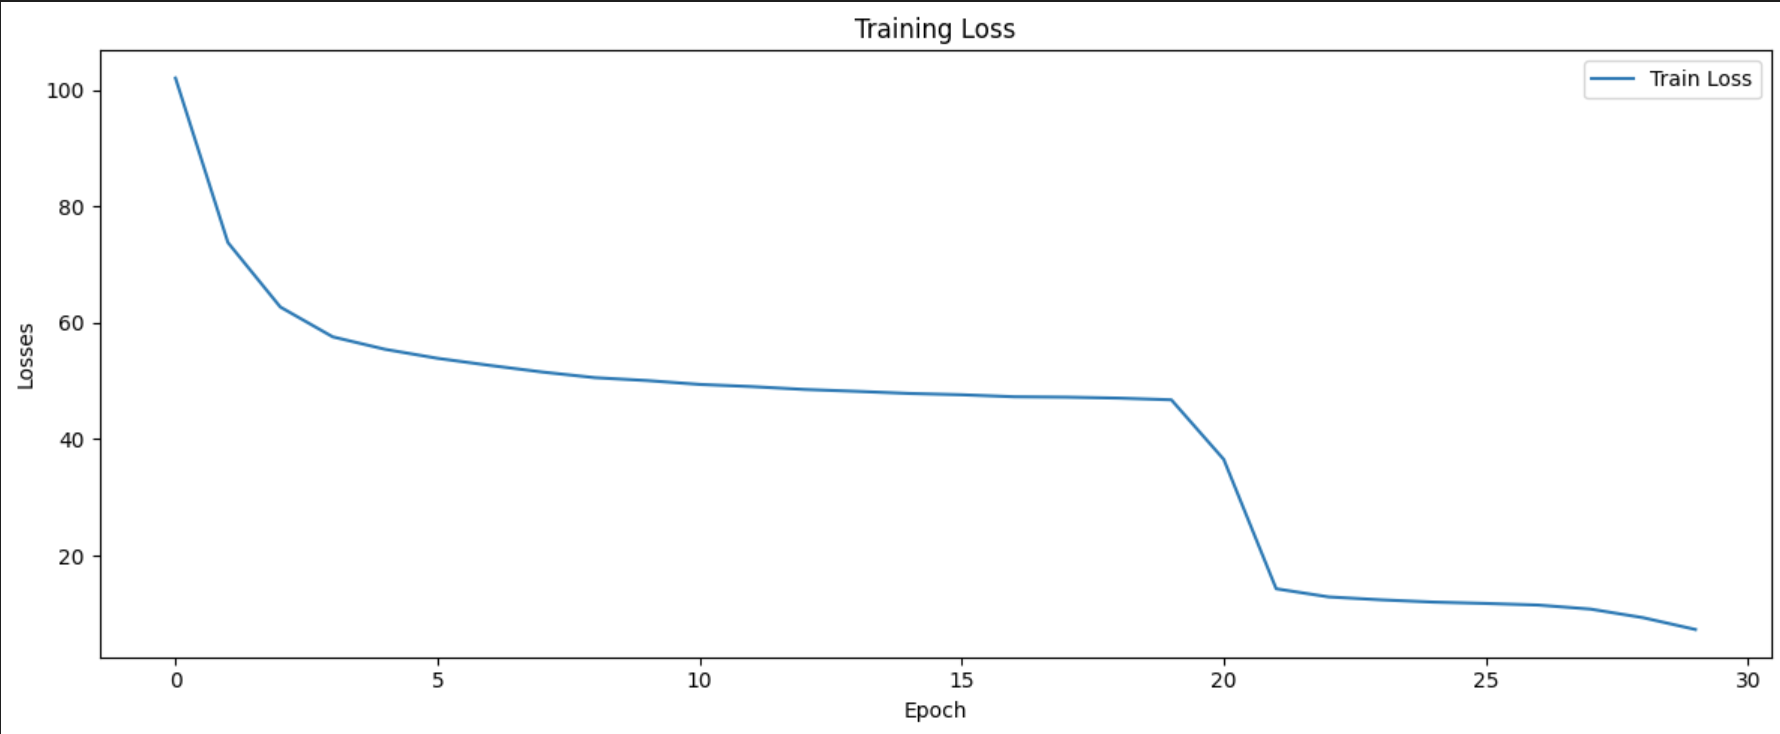 -->
autmbnet2 uses d=16 and the autoencoder with d=8. It has loss of around 32 with 22K params.

autmbunet3 is based on autmbunet2 but it was further trained on the autoencoder with d=16. It has a loss of around 37 and is the model I saved. I tried to continue training but eventually it started getting worse.
When training the conditional, it reaches a loss of around 33.5

In [ ]:
# Clear memory
train_loader = None
torch.cuda.empty_cache()

Label: tensor([9])


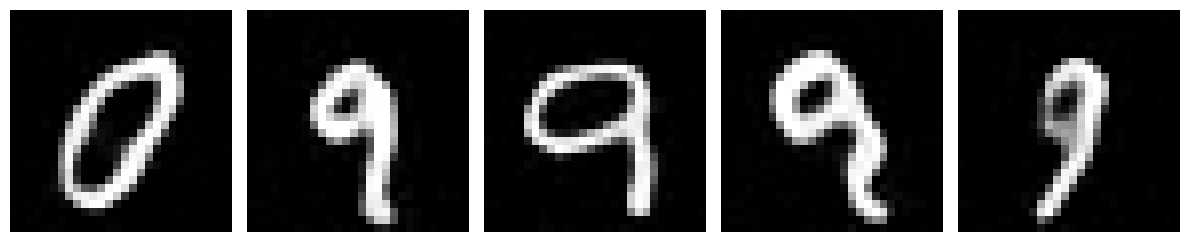

Label: tensor([7])


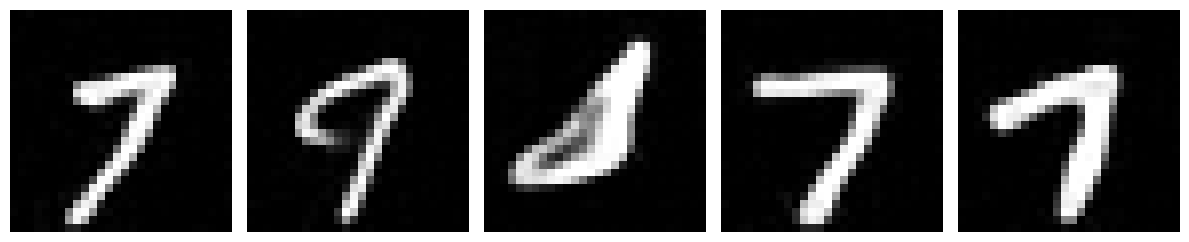

Label: tensor([3])


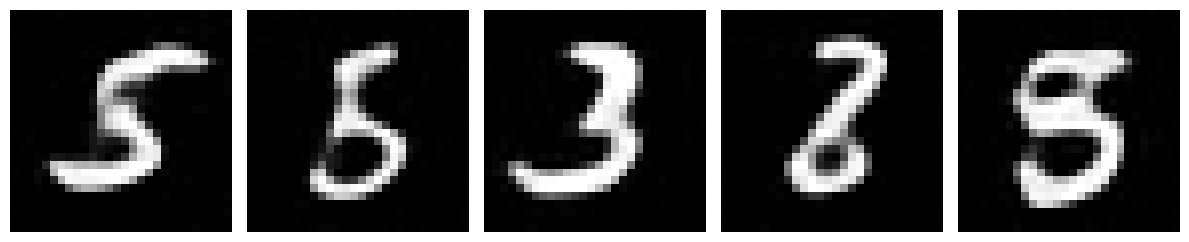

In [44]:
# Generate samples
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def score(model, x, t, y):
    return (t * model(x, t, y) - x)/((1 - t)**2 + t * (1-t))

def EulerMaruyama(f, g, x0, num_steps=100):
    """Returns the solution of dx = f(x, t)dt + g(x, t)dW at x=1
    both x0 and output are in device"""
    h = 1/num_steps
    x = x0
    for n in range(num_steps):
        t = torch.tensor(n*h, device=device, dtype=torch.float32).view((1, 1, 1, 1))
        ep = torch.normal(torch.zeros_like(x), torch.ones_like(x)).view(x.shape)
        x = x + f(x, t) * h + g(x, t) * sqrt(h) * ep
    return x

def generate_sample(model, autoencoder=None, sigma=0, samples=1, x0=None):
    """
    Generates "sample" images using the NN model.
    If x0 is None, it generates a random image.
    If sigma=0, uses a flow model. Otherwise it's diffussion.
    """
    if autoencoder is None:
        decoder = lambda x: x
        w = 28
    else:
        decoder = autoencoder.decoder
        w = 7
    model.eval()
    shape = (samples, 1, w, w)
    if x0 is None:
        x0 = torch.normal(
            mean=torch.zeros(shape, device=device),
            std=torch.ones(shape, device=device),
            ).view(shape)
    x1 = []
    num = torch.randint(10, (1, ))
    print(f"Label: {num}")
    for i in range(samples):
        if sigma == 0:
            ivp_output = solve_ivp(
                lambda t, x: model(
                    torch.tensor(x, dtype=torch.float32, device=device).view(1, 1, w, w),
                    torch.tensor(t, dtype=torch.float32, device=device).view(1, 1, 1, 1)
                    ).to('cpu').detach().numpy().reshape(w**2),
                y0=x0[i, :, :, :].cpu().view(w**2).numpy(), t_span=[0, 1], t_eval=[1],
            )
            img = decoder(torch.tensor(ivp_output["y"], device=device, dtype=torch.float32).view(1, 1, w, w))
            x1.append(img.cpu().detach().view(28, 28).numpy())
        else:
            assert sigma > 0, "sigma must be non-negative"
            y = nn.functional.one_hot(num, num_classes=10).to(torch.float32).to(device).view(1, 10)
            f = lambda x, t: model(x, t, y) + 0.5 * sigma**2 * score(model, x, t, y)
            g = lambda x, t: sigma
            img = decoder(EulerMaruyama(f, g, x0[i][None, :, :, :], num_steps=300))
            x1.append(img.cpu().detach().view(28, 28).numpy())
    x1 = np.array(x1)
    x1 = np.clip(x1, 0, 1)
    return x1

with torch.no_grad():
    samples = 5
    for sigma in [1, 1, 1]:
        x1 = generate_sample(model, autoencoder=autoencoder, sigma=sigma, samples=samples)
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, samples, figsize=(12, 5))
        for i in range(1, samples + 1):
            exec(f"ax{i}.imshow(x1[i-1], cmap='gray')")
            exec(f"ax{i}.axis('off')")
        plt.tight_layout()
        plt.show()

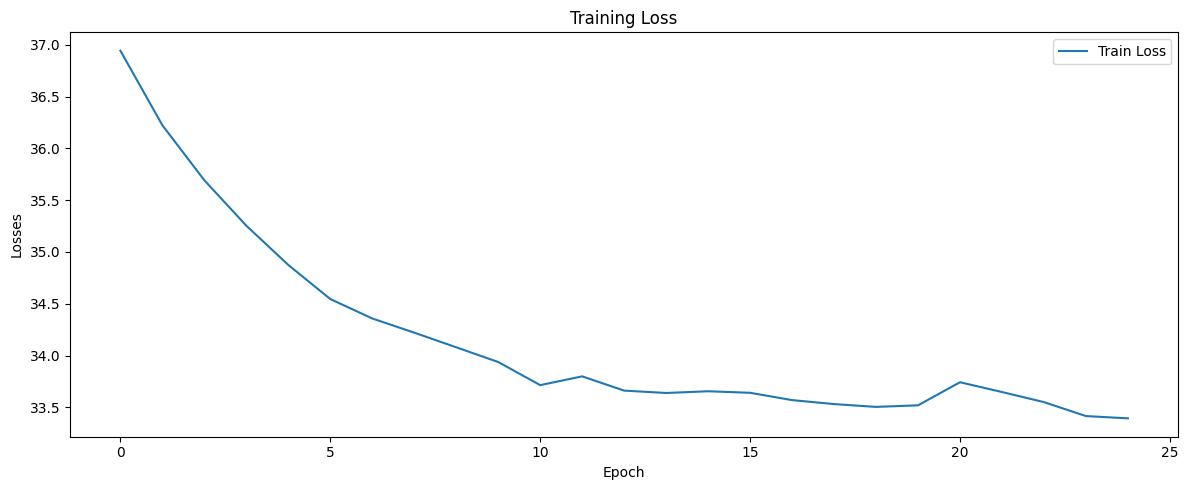

In [40]:
# Loss function plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot train losses
ax.plot(train_losses[0:], label='Train Loss')
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Losses')
# ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Train autoencoder
from tqdm.notebook import tqdm

new_model = False
loss_fn = nn.MSELoss(reduction='sum')

if new_model:
    autoencoderd16 = AutoEncoder(d=16).to(device)
    train_losses = []

def train_autoencoder(model, num_epochs=25, lr=1e-4, num_val=1):
    """
    Trains the given model and evaluates it num_val times.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {num_params}")

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        model.train()
        total_loss = 0
        num_loss = 0
        for x, _ in tqdm(train_loader, desc="Batches", leave=False):
            # forward pass
            x = x.to(device)
            x_hat = model(x)
            loss = loss_fn(x_hat, x)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # keep results
            total_loss += loss.item()
            num_loss += x.shape[0]
        train_losses.append(total_loss / num_loss)

        if epoch % (num_epochs//num_val) != 0:  # only test num_val times
            continue
        model.eval()
        total_loss = 0
        num_loss = 0
        for x, _ in tqdm(test_loader, desc="Batches", leave=False):
            # forward pass
            x = x.to(device)
            x_hat = model(x)
            loss = loss_fn(x_hat, x)

            # keep results
            total_loss += loss.item()
            num_loss += x.shape[0]

        print(f"Epoch {epoch}: train_loss={round(train_losses[-1], 3)}, val_loss={total_loss / num_loss}")

train_autoencoder(autoencoderd16, num_epochs=10, lr=1e-4, num_val=1)

Number of parameters: 25474


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: train_loss=3.099, val_loss=2.9933894638061522


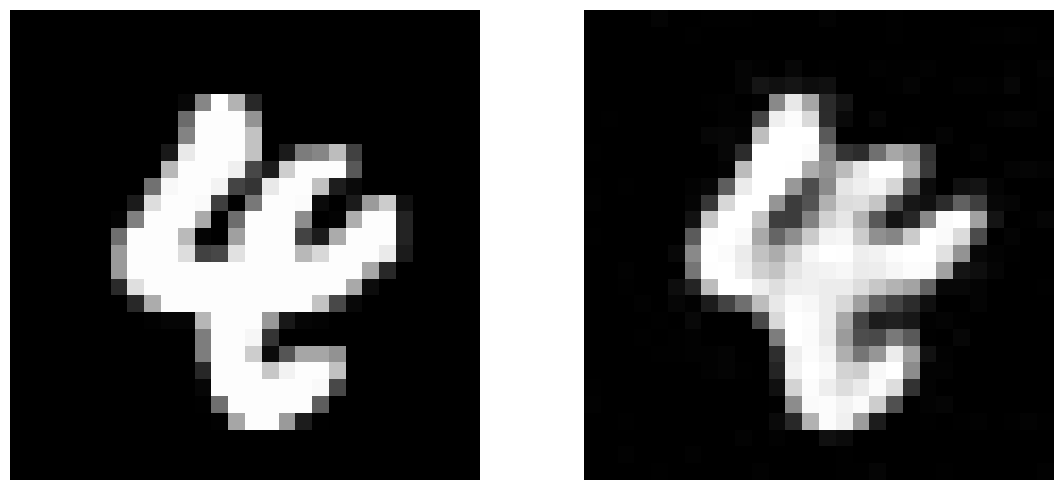

In [ ]:
# Test autoencoder
num_batch = np.random.randint(64)
for i, (x, y) in enumerate(test_loader):
    if i < num_batch:
        continue
    break
x_hat = autoencoder(x.to(device)).cpu().detach().numpy()
x_hat = np.clip(x_hat, 0, 1)                    # may remove if it works
img_num = np.random.randint(64)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(x[img_num, 0], cmap='gray')
ax1.axis('off')
ax2.imshow(x_hat[img_num, 0], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [27]:
# Load model
import os

model_name = "MNIST_flowmatching"
save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
# model = MNISTGenerator(num_layers=12, num_channels=20, kernel_size=21).to(device)
# model = UNetMNIST(num_ch=10).to(device)
model = CondAutMBUnet(d=16).to(device)
model.load_state_dict(torch.load(save_path), strict=False)

_IncompatibleKeys(missing_keys=['yemb.0.weight', 'yemb.0.bias', 'yemb.2.weight', 'yemb.2.bias'], unexpected_keys=[])

In [42]:
# Save model
import os

model_name = "MNIST_conditional_flowmatching"
save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ..\NN_parameters\Generative models\MNIST_conditional_flowmatching.pth


Summary of results
---

I trained 3 models:
- A classfier with 1K parameters that achieves 95% in the test set.
- An autoencoder with 25K parameters that achieves a MSE of 0.004 in the test set.
- A flow-matching model with 23K parameters in the latent space of the autoencoder, and the images generated with diffussion coefficient 1 look very good.

In [2]:
# Define models
import os

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=5)  # -> 24x24 -> 12x12
        self.cnn2 = nn.Conv2d(10, 2, kernel_size=5)  # -> 8x8 -> 4x4
        self.linear = nn.Linear(2 * 4 * 4, 10)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.ac(self.max(self.cnn1(x)))
        x = self.ac(self.max(self.cnn2(x)))
        x = x.view(-1, 2 * 4 * 4)
        x = self.linear(x)
        return self.sm(x)

class MBConv2d(nn.Module):
    """
    Building block of the autoencoder and flow-matching models, it's
      basically a inear bottleneck (see MobileNetV2)
    Input and output are images of the same shape. C -> C or C -> C/2
    """
    def __init__(self, in_channels, out_channels, activation_fn):
        super().__init__()
        d1, d2 = in_channels, out_channels
        assert d1 == d2 or d1 == 2 * d2, "MBConv2d inputs are invalid"
        self.twice = d1 == 2 * d2
        self.network = nn.Sequential(
            nn.Conv2d(d1, 6*d1, kernel_size=1),
            activation_fn,
            nn.Conv2d(6*d1, 6*d2, kernel_size=3, padding=1, groups=6*d2),
            activation_fn,
            nn.Conv2d(6*d2, d2, kernel_size=1),
        )

    def forward(self, x):
        y = (x[:, ::2] + x[:, 1::2])/2 if self.twice else x
        return y + self.network(x)

class AutoEncoder(nn.Module):
    """Reduces the 28x28 image into size 7x7"""
    def __init__(self, d=16):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up   = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            self.ac,
            MBConv2d(d, d, self.ac),
            self.max,                   # -> 14x14
            MBConv2d(d, d, self.ac),
            self.max,                   # -> 7x7
            MBConv2d(d, d, self.ac),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            MBConv2d(d, d, self.ac),
            self.up,                    # -> 14x14
            MBConv2d(d, d, self.ac),
            self.up,                    # -> 28x28
            MBConv2d(d, d, self.ac),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class FlowMatching(nn.Module):
    """Unet whose input is the 7x7 encoding of the autoencoder"""
    def __init__(self, d=16):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups   = nn.Upsample(size=7)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2, d, kernel_size=3, padding=1),
            self.ac,
        )
        self.dwnn1 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 7x7
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 3x3
            MBConv2d(d, d, self.ac),    # -> 3x3
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(d, d, self.ac),    # -> 3x3
            self.ups,                   # -> 7x7
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac),  # -> 7x7
        )
        self.cnn2 = nn.Conv2d(d, 1, kernel_size=3, padding=1)
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 7)
        )

    def forward(self, x, t, y):
        """x: (B, 1, 7, 7),  t: (B, 1, 1, 1),  y: (B, 10)"""
        T = torch.linspace(0, torch.pi, 7, device=device).view(1, -1) * t
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)
        Y = self.yemb(y)
        s, c = torch.sin(Y), torch.cos(Y)
        y = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)

        dw1 = self.cnn1(torch.cat((x, y + t), dim=1))
        dw2 = self.dwnn1(dw1)
        end = self.dwnn2(dw2)
        up2 = self.upnn2(end)
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        out = self.cnn2(up1)  # could cat with dw1
        return out

file_names = ["MNIST_classifier", "MNIST_autoencoder", "MNIST_conditional_flowmatching"]
architectures = ["Classifier", "AutoEncoder", "FlowMatching"]
model_names = ["classifier", "autoencoder", "denoiser"]
for file_name, architecture, model_name in zip(file_names, architectures, model_names):
    save_path = os.path.join("..", "NN_parameters\\Generative models", file_name + ".pth")
    exec(f"{model_name} = {architecture}().to(device)")
    exec(f"{model_name}.load_state_dict(torch.load(save_path))")
    exec(f"{model_name}.eval()")
    exec(f"num_params = sum(p.numel() for p in {model_name}.parameters())")
    exec(f"print('Number of parameters in {model_name}: {num_params}')")

Number of parameters in classifier: 1092
Number of parameters in autoencoder: 25474
Number of parameters in denoiser: 24400


In [4]:
# Calculate the accuracy of the classifier and autoencoder
from torchvision.transforms import ToTensor
from tqdm import tqdm

batch_size = 256
test_dataset = datasets.MNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True, persistent_workers=False,
)

mse_loss = nn.MSELoss(reduction='mean')
accuracy = 0
accuracy2 = 0
avg_loss = 0
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        x_hat = autoencoder(x)
        avg_loss += mse_loss(x_hat, x).item()

        y_pred = classifier(x)
        y_hat = torch.argmax(y_pred, dim=-1)
        acc = (y == y_hat).float().mean().item()
        accuracy += acc

        y2_pred = classifier(x_hat)
        y2_hat = torch.argmax(y2_pred, dim=-1)
        acc2 = (y == y2_hat).float().mean().item()
        accuracy2 += acc2

print(f"Classification accuracy is {round(100*accuracy/len(test_loader), 3)}%")
print(f"MSE of the autoencoder is {round(avg_loss/len(test_loader), 4)}")
print(f"Accuracy in reconstructed images is {round(100*accuracy2/len(test_loader), 3)}%")

Testing: 100%|██████████| 40/40 [00:01<00:00, 23.21it/s]

Classification accuracy is 95.322%
MSE of the autoencoder is 0.0038
Accuracy in reconstructed images is 94.58%


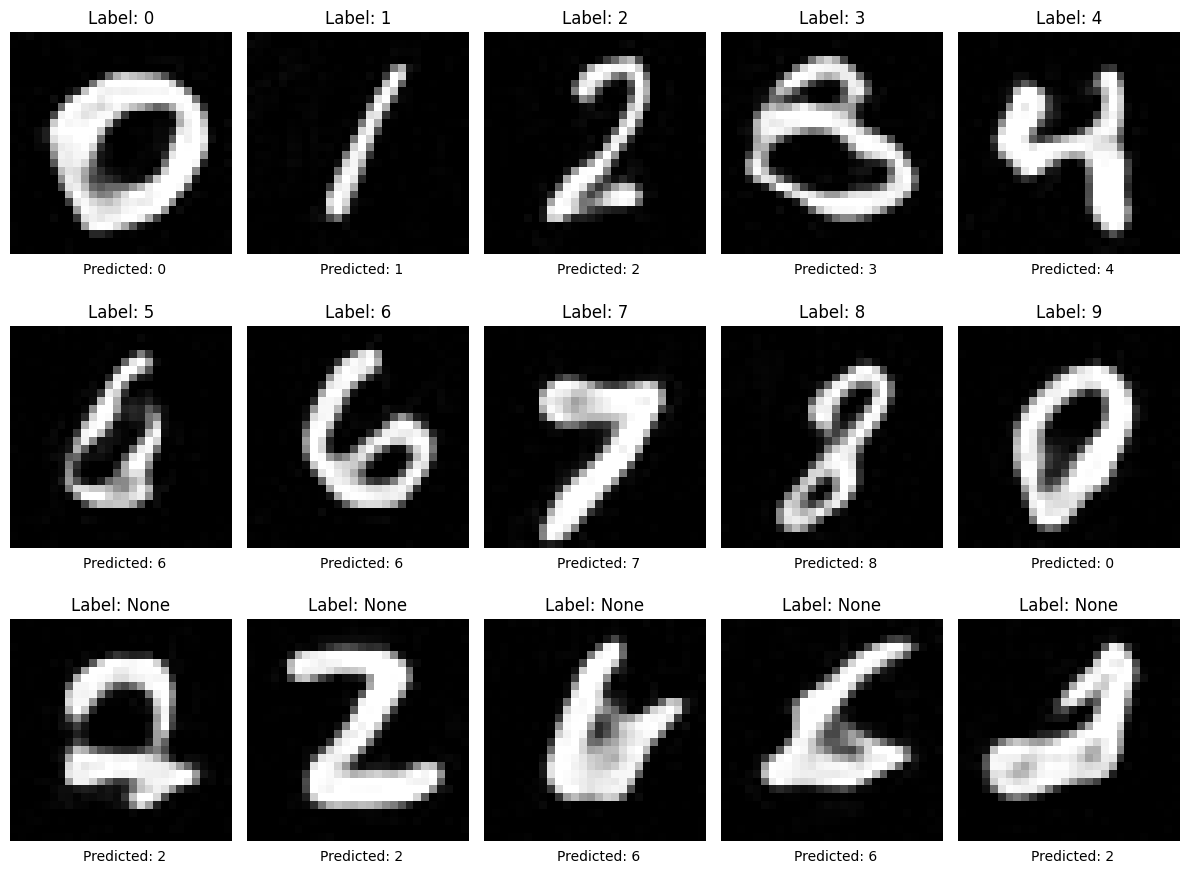

In [14]:
# Generate and classify images
import matplotlib.pyplot as plt
from math import sqrt

height, width, sigma, w = 3, 5, 1, 4
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + 5 *[None]

def score(denoiser, x, t, y):
    """Returns the score asuming that denoiser is the flow"""
    return (t * denoiser(x, t, y) - x)/((1 - t)**2 + t * (1-t))

def flow(denoiser, x, t, y, w=1):
    """Returns the flow using the denoiser(x, t, y) NN"""
    no_y = torch.zeros_like(y)
    return w * denoiser(x, t, y) + (1 - w) * denoiser(x, t, no_y)

def EulerMaruyama(f, g, x0, num_steps=300):
    """Returns the solution of dx = f(x, t)dt + g(x, t)dW at x=1
    both x0 and output are in device"""
    h = 1/num_steps
    x = x0
    B = x.shape[0]
    for n in range(num_steps):
        t = torch.tensor(n*h, device=device, dtype=torch.float32).repeat(B, 1, 1, 1)
        ep = torch.normal(torch.zeros_like(x), torch.ones_like(x)).view(x.shape)
        x = x + f(x, t) * h + g(x, t) * sqrt(h) * ep
    return x

def generate_images(denoiser, autoencoder, num_img, sigma, labels=None):
    """Generates images using the provided denoiser and autoencoder
    output is a tensor of shape (num_img, 1, 28, 28)
    labels: list of length num_img with the labels, None refers to no labels"""
    ones = torch.ones(num_img * 7 * 7, device=device, dtype=torch.float32)
    x0 = torch.normal(0 * ones, ones).view(num_img, 1, 7, 7)
    if labels:
        labels = [k if k is not None else 10 for k in labels]
        y = torch.tensor(labels, device=device)
        y = nn.functional.one_hot(y, num_classes=11).to(torch.float32)  # (B, 11)
        y = y[:, :-1]
    else:
        y = torch.zeros((num_img, 10), dtype=torch.float32, device=device)

    f = lambda x, t: flow(denoiser, x, t, y) + 0.5 * sigma**2 * score(denoiser, x, t, y)
    g = lambda x, t: sigma
    x1 = autoencoder.decoder(EulerMaruyama(f, g, x0, num_steps=300))
    return torch.clip(x1, 0, 1)

with torch.no_grad():
    x = generate_images(denoiser, autoencoder, height * width, sigma, labels=y)
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

Scaling the models
---

I will scale the architectures by 5 times to improve the accuracy and quality of generation.

- The training method for the autoencoder and denoiser is summarized in the corresponding entries.

In [13]:
# Define models
import os

class MBConv2d(nn.Module):
    """
    Building block of the autoencoder and flow-matching models, it's
      basically a inear bottleneck (see MobileNetV2)
    Input and output are images of the same shape. C -> C or C -> C/2
    """
    def __init__(self, in_channels, out_channels, activation_fn, k=6):
        super().__init__()
        d1, d2 = in_channels, out_channels
        assert d1 == d2 or d1 == 2 * d2, "MBConv2d inputs are invalid"
        self.twice = d1 == 2 * d2
        self.network = nn.Sequential(
            nn.Conv2d(d1, k*d1, kernel_size=1),
            activation_fn,
            nn.Conv2d(k*d1, k*d2, kernel_size=3, padding=1, groups=k*d2),  # (groups = 6*d2)
            activation_fn,
            nn.Conv2d(k*d2, d2, kernel_size=1),
        )

    def forward(self, x):
        y = (x[:, ::2] + x[:, 1::2])/2 if self.twice else x
        return y + self.network(x)

class Classifier(nn.Module):
    def __init__(self, d=7):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.network = nn.Sequential(
            nn.Conv2d(1, 2*d, kernel_size=3),  # -> 26
            self.ac,
            MBConv2d(2*d, d, self.ac),
            self.max,                        # -> 13
            MBConv2d(d, d, self.ac),
            self.max,                        # -> 6
            MBConv2d(d, d, self.ac),
            self.max,                        # -> 3
            nn.Conv2d(d, 10, kernel_size=3),
        )
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.network(x).view(-1, 10)
        return self.sm(x)

class AutoEncoder(nn.Module):
    """Reduces the 28x28 image into size 7x7"""
    def __init__(self, d=32):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up   = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2*d, kernel_size=3, padding=1),
            self.ac,
            MBConv2d(2*d, d, self.ac),
            self.max,                   # -> 14x14
            MBConv2d(d, d, self.ac),
            self.max,                   # -> 7x7
            MBConv2d(d, d, self.ac),
            nn.Conv2d(d, 2, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(2, 2*d, kernel_size=3, padding=1),
            MBConv2d(2*d, d, self.ac),
            self.up,                    # -> 14x14
            MBConv2d(d, d, self.ac),
            self.up,                    # -> 28x28
            MBConv2d(d, d, self.ac),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class FlowMatching(nn.Module):
    """Unet whose input is the 7x7 encoding of the autoencoder"""
    def __init__(self, d=32, k=6, n=2):  # d=33 for the previous version
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups   = nn.Upsample(size=7)
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2, 2*d, kernel_size=3, padding=1),
            self.ac,
        )
        self.dwnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac, k),
        )
        self.dwnn2 = nn.Sequential(
            self.max,                   # -> 3x3
            MBConv2d(d, d, self.ac, k),    # -> 3x3
        )
        self.final = nn.Sequential(  # first version has self.final (only one), second (trained longer) has none
            *[MBConv2d(d, d, self.ac, k) for _ in range(n)],
        )
        self.upnn2 = nn.Sequential(
            MBConv2d(d, d, self.ac, k),    # -> 3x3
            self.ups,                   # -> 7x7
        )
        self.upnn1 = nn.Sequential(
            MBConv2d(2*d, d, self.ac, k),  # -> 7x7
        )
        self.cnn2 = nn.Conv2d(d, 1, kernel_size=3, padding=1)
        self.temb = nn.Sequential(
            nn.Linear(1, 50),
            self.ac,
            nn.Linear(50, 7),
        )
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 7)
        )

    def forward(self, x, t, y):
        """x: (B, 1, 7, 7),  t: (B, 1, 1, 1),  y: (B, 10)"""
        T = self.temb(t.view(-1, 1))
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)
        Y = self.yemb(y)
        s, c = torch.sin(Y), torch.cos(Y)
        y = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)

        dw1 = self.cnn1(torch.cat((x, t + y), dim=1))
        dw2 = self.dwnn1(dw1)
        end = self.dwnn2(dw2)
        end = self.final(end)
        up2 = self.upnn2(end)
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1))
        out = self.cnn2(up1)
        return out

file_names = [
    "MNIST_big_classifier",
    # "MNIST_big_autoencoder",
    # "MNIST_big_denoiser_trained_longer",
]
architectures = [
    "Classifier",
    # "AutoEncoder",
    # "FlowMatching",
]
model_names = [
    "classifier",
    # "autoencoder",
    # "denoiser",
]
for file_name, architecture, model_name in zip(file_names, architectures, model_names):
    exec(f"{model_name} = {architecture}().to(device)")
    save_path = os.path.join("..", "NN_parameters\\Generative models", file_name + ".pth")
    exec(f"{model_name}.load_state_dict(torch.load(save_path))")
    exec(f"{model_name}.eval()")
    exec(f"num_params = sum(p.numel() for p in {model_name}.parameters())")
    exec(f"print('Number of parameters in {model_name}: {num_params}')")

Number of parameters in classifier: 5253


Training <class '__main__.Classifier'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Testing <class '__main__.Classifier'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 98.69


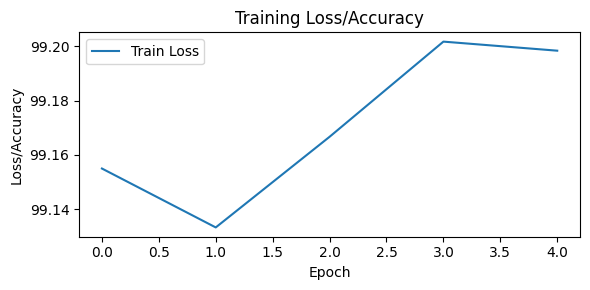

In [153]:
# Train classifier (saved version achieves 98.69% acc in test set)
train_losses = tloop(
    classifier, train_loader, forward_classification,
    training=True, num_epochs=5, lr=4*1e-4, train_losses=[],
)
tloop(classifier, test_loader, forward_classification, training=False)
plot_train_losses(train_losses, log=False)

Training <class '__main__.AutoEncoder'>...


Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Testing <class '__main__.AutoEncoder'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 1.44211223487854


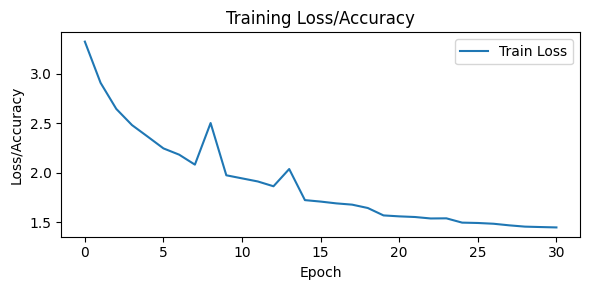

In [ ]:
# Train autoencoder (saved version achieves test reconstruction MSE of 1.44),
#   The only issues it has is that sometimes it closes loops that shouldn't close.
# 10 with 3*1e-3, 5 with 2*1e-3, 5 with 1e-3, 5 with 7*1e-4, 5 with 4*1e-4
train_losses = tloop(
    autoencoder, train_loader, forward_autoencoding,
    training=True, num_epochs=4, lr=4*1e-4, train_losses=train_losses,
)
tloop(autoencoder, test_loader, forward_autoencoding, training=False)
plot_train_losses(train_losses[2:], log=False)

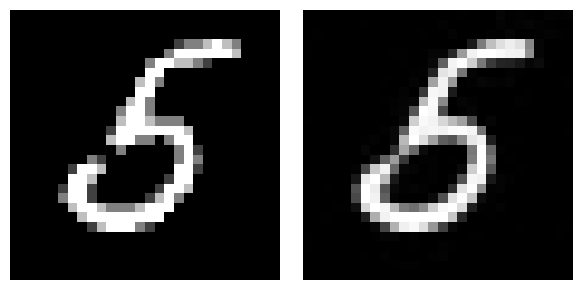

In [158]:
# Test autoencoder
import numpy as np
import matplotlib.pyplot as plt

# num_batch = np.random.randint(64)
# img_num = np.random.randint(64)
for i, (x, y) in enumerate(test_loader):
    if i < num_batch:
        continue
    break
x_hat = autoencoder(x.to(device)).cpu().detach().numpy()
x_hat = np.clip(x_hat, 0, 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(x[img_num, 0], cmap='gray')
ax1.axis('off')
ax2.imshow(x_hat[img_num, 0], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 27.199648818969727


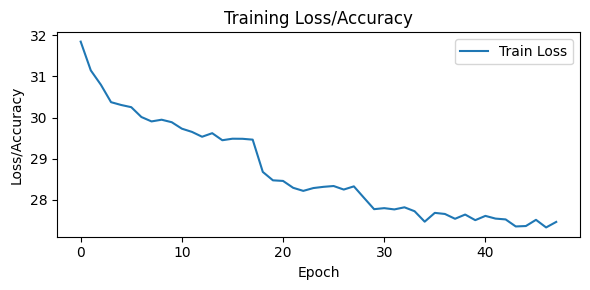

In [ ]:
# Train flowmatching model (saved version achieves test MSE of 49.80)
# Train flowmatching model 2 (saved version achieves test MSE of 27.2)
# 20 at 5*1e-3, 10 at 2*1e-3, 5 at 1e-3, 10 at 5*1e-4, 5 at 1e-4
train_losses = tloop(
    denoiser, train_loader, forward_denoising,
    training=True, num_epochs=5, lr=1e-4,
    train_losses=train_losses, encoder=autoencoder.encoder,
)
tloop(
    denoiser, test_loader, forward_denoising,
    training=False, encoder=autoencoder.encoder,
)
plot_train_losses(train_losses[2:], log=False)

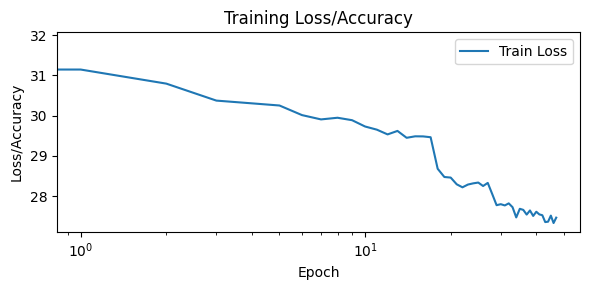

27.466551599121093


In [193]:
plot_train_losses(train_losses[2:], log=True)
print(train_losses[-1])

In [201]:
# Functions to generate and classify images
import matplotlib.pyplot as plt
from math import sqrt

def flow(denoiser, x, t, y, w=1):
    """Returns the flow using the denoiser(x, t, y) NN"""
    no_y = torch.zeros_like(y)
    return w * denoiser(x, t, y) + (1 - w) * denoiser(x, t, no_y)

def score(denoiser, x, t, y):
    """Returns the score asuming that denoiser is the flow"""
    return (t * denoiser(x, t, y) - x)/((1 - t)**2 + t * (1-t))

def EulerMaruyama(f, g, x0, num_steps=200):
    """Returns the solution of dx = f(x, t)dt + g(x, t)dW at x=1
    both x0 and output are in device"""
    h = 1/num_steps
    x = x0
    B = x.shape[0]
    for n in range(num_steps):
        t = torch.tensor(n*h, device=device, dtype=torch.float32).repeat(B, 1, 1, 1)
        ep = torch.normal(torch.zeros_like(x), torch.ones_like(x)).view(x.shape)
        x = x + f(x, t) * h + g(x, t) * sqrt(h) * ep
    return x

def generate_images(denoiser, autoencoder, num_img, sigma, size=(1, 7, 7), labels=None):
    """Generates images using the provided denoiser and autoencoder
    output is a tensor of shape (num_img, 1, 28, 28)
    labels: list of length num_img with the labels, None refers to no labels"""
    ones = torch.ones(num_img * size[0] * size[1] * size[2], device=device, dtype=torch.float32)
    x0 = torch.normal(0 * ones, ones).view(num_img, *size)
    if labels:
        labels = [k if k is not None else 10 for k in labels]
        y = torch.tensor(labels, device=device)
        y = nn.functional.one_hot(y, num_classes=11).to(torch.float32)  # (B, 11)
        y = y[:, :-1]
    else:
        y = torch.zeros((num_img, 10), dtype=torch.float32, device=device)

    f = lambda x, t: flow(denoiser, x, t, y) + 0.5 * sigma(t)**2 * score(denoiser, x, t, y)
    g = lambda x, t: sigma(t)
    x1 = autoencoder.decoder(EulerMaruyama(f, g, x0, num_steps=300))
    return torch.clip(x1, 0, 1)

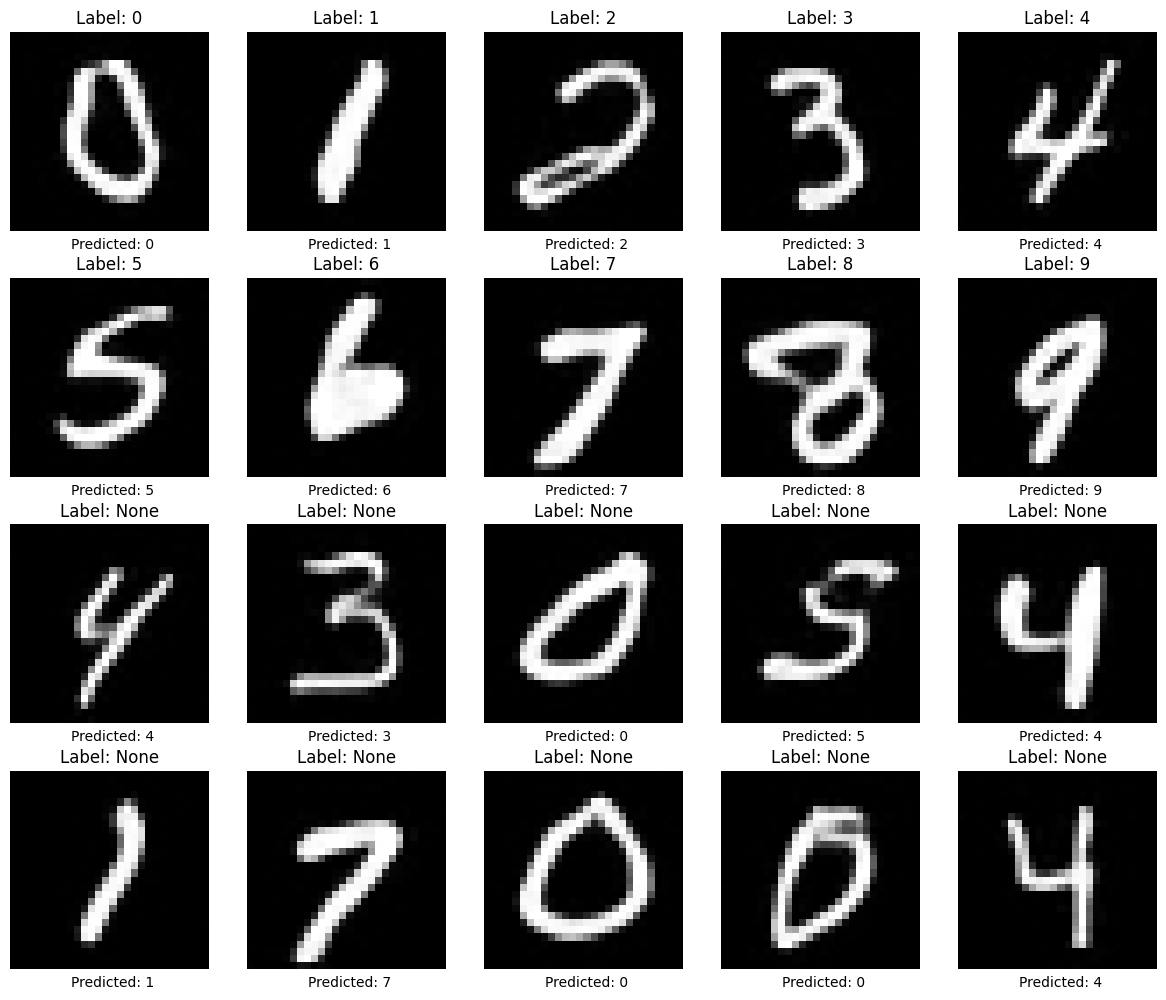

In [19]:
# Generate and classify images
with torch.no_grad():
    x = generate_images(denoiser, autoencoder, height * width, sigma, labels=y)
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [111]:
# Save models
import os

# model_name = "MNIST_big_classifier"
# save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
# torch.save(classifier.state_dict(), save_path)
# print(f"Model saved to {save_path}")

# model_name = "MNIST_big_autoencoder"
# save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
# torch.save(autoencoder.state_dict(), save_path)
# print(f"Model saved to {save_path}")

model_name = "MNIST_variational_autoencoder"
save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
torch.save(autoencoder.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ..\NN_parameters\Generative models\MNIST_variational_autoencoder.pth


IMPORTANT: MNIST_big_denoiser_trained_longer is like MNIST_big_denoiser but it doesn't have the layer at the bottom and it uses d=32, k=6 instead of d=33.

Optimizing model size
---

I will try to make the models smaller while retaining their functionality. I test three things:
- Decreasing the dimension of the bottleneck.
- Decreasing the depth of the model.

Spoiler: I wasn't able to reduce the model's size. In fact it was hard to recreate at all. The previous architecture is probably the minimum that can generate the MNIST under these autoencoder embeddings. It could be fault of the embedding but it could also be that a factor k larger than 8 is not so helpful.

Results are the following (using the scheduler that varies linearly from lr=5*1e-3 to lr=1e-4):
- Deleting a layer and changing the dimensions to d=16, k=12 (instead of d=33, k=6) halves the number of parameters and achieves a loss of 28.0 (vs 27.2) in 30 epochs (vs 50 epochs), although it seems this difference in losses affects the output considerably. However their expressiveness seems to be the same, since both achieve a loss of around 32 at 2 epochs and around 27-28 when the lr goes to around 3*1e-4.
- Deleting a layer and using d=12, k=12 gives less expressiveness although it has a third of parameters. At 2 epochs the loss is almost 32.7 and at 30 epochs the loss is 28.74. The images don't look as great.
- Deleting a layer and using d=12, k=20 and deleting the 2*d in the first layer makes the model default to zero in the first epoch. When I keep it reaches 32.5 in epoch 2 and 28.5 in epoch 30.
- Adding a layer and using d=14, k=14 gives
- MLP probably performs worse (loss 35 at epoch 3).
- Keeping the same num of layers and d=24, k=8 works best. Loss 32.0 at epoch 3 and 27.7 at epoch 30.
- d=28, k=7 still performs worse (27.7 at 40 epochs) with one layer less.
- d=32, k=6 still is worse (27.4 at 40 epochs) with one layer more.

Important takeaways: reducing the dimensionality of the bottleneck is fine as long as the first layer is big enough, but it doesn't perform as well. Also making the network deeper helps significantly. Also tuning the learning rate helps a lot too, and linear rate was definitely not the best.

I really should do some kind of grid search from now on. Dimensions could've been width (d, k), detph (# layers), and lr (both the value and the rate of decay).

In [ ]:
# lr search for d=28, k=7
# 6*1e-3: 41.64, 32.22, 31.85 best
# 1e-2:   43.00, 33.53,
# 4*1e-3: 43.87, 
# 7*1e-3: 41.97, 33.32, 32.03

In [ ]:
# num_layers search for d=32, k=6
# 2: 42.30, 33.08, 31.59
# 2: 41.90, 32.87, 31.45
# 0: ????          32.00
# 3: 41.71, 33.01, 31.58

Number of parameters: 131065
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 27.468488224283853


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 27.39786072184245


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 27.475124731445312


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1, train loss: 27.40433327331543
Average loss in test set: 27.40433327331543


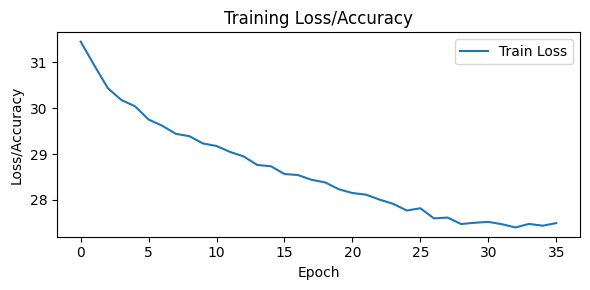

In [129]:
# Train flow-matching model
import matplotlib.pyplot as plt
# denoiser = FlowMatching(d=32, k=6).to(device)
print(f"Number of parameters: {sum(p.numel() for p in denoiser.parameters())}")
train_losses = tloop(
    denoiser, train_loader, forward_denoising,
    training=True, num_epochs=5, lr=1e-4, end_factor=0.8,
    train_losses=train_losses, encoder=autoencoder.encoder,
)
tloop(
    denoiser, test_loader, forward_denoising,
    training=False, encoder=autoencoder.encoder,
)
plot_train_losses(train_losses[2:], log=False)

In [ ]:
# denoiserd16k12 = denoiser.cpu()
# denoiserd12k12 = denoiser.cpu()
# denoiserd12k20 = denoiser.cpu()
# denoiserd24k8 = denoiser.cpu()

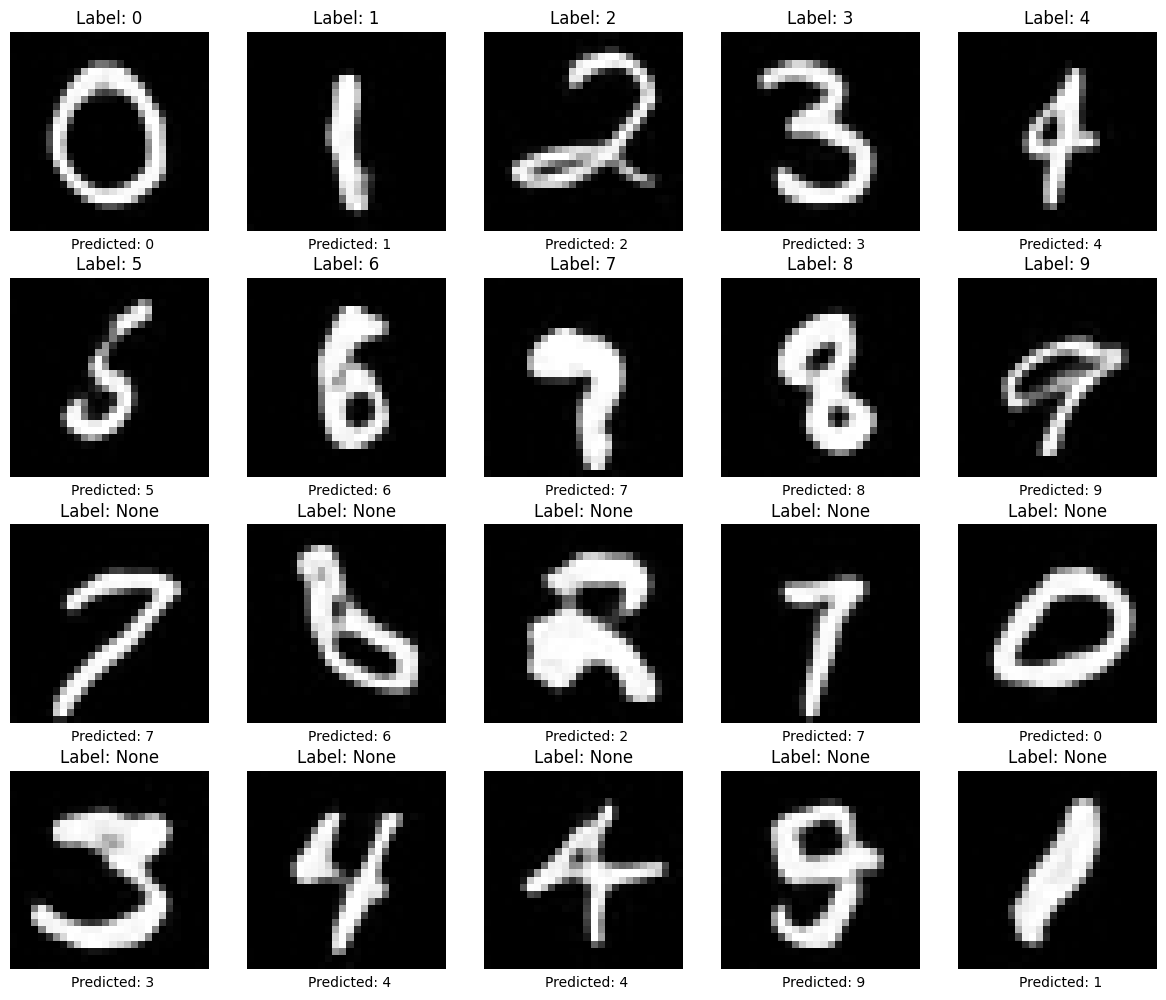

In [139]:
# Generate and classify images
import matplotlib.pyplot as plt
from math import sqrt

height, width, w = 4, 5, 1
sigma = lambda t: 0.7 * torch.sqrt(1 - t)
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + width * (height - 2) * [None]

def flow(denoiser, x, t, y, w=1):
    """Returns the flow using the denoiser(x, t, y) NN"""
    no_y = torch.zeros_like(y)
    return w * denoiser(x, t, y) + (1 - w) * denoiser(x, t, no_y)

def score(denoiser, x, t, y):
    """Returns the score asuming that denoiser is the flow"""
    return (t * denoiser(x, t, y) - x)/((1 - t)**2 + t * (1-t))

def EulerMaruyama(f, g, x0, num_steps=300):
    """Returns the solution of dx = f(x, t)dt + g(x, t)dW at x=1
    both x0 and output are in device"""
    h = 1/num_steps
    x = x0
    B = x.shape[0]
    for n in range(num_steps):
        t = torch.tensor(n*h, device=device, dtype=torch.float32).repeat(B, 1, 1, 1)
        ep = torch.normal(torch.zeros_like(x), torch.ones_like(x)).view(x.shape)
        x = x + f(x, t) * h + g(x, t) * sqrt(h) * ep
    return x

def generate_images(denoiser, autoencoder, num_img, sigma, labels=None):
    """Generates images using the provided denoiser and autoencoder
    output is a tensor of shape (num_img, 1, 28, 28)
    labels: list of length num_img with the labels, None refers to no labels"""
    ones = torch.ones(num_img * 1 * 7 * 7, device=device, dtype=torch.float32)
    x0 = torch.normal(0 * ones, ones).view(num_img, 1, 7, 7)
    if labels:
        labels = [k if k is not None else 10 for k in labels]
        y = torch.tensor(labels, device=device)
        y = nn.functional.one_hot(y, num_classes=11).to(torch.float32)  # (B, 11)
        y = y[:, :-1]
    else:
        y = torch.zeros((num_img, 10), dtype=torch.float32, device=device)

    f = lambda x, t: flow(denoiser, x, t, y) + 0.5 * sigma(t)**2 * score(denoiser, x, t, y)
    g = lambda x, t: sigma(t)
    x1 = autoencoder.decoder(EulerMaruyama(f, g, x0, num_steps=300))
    return torch.clip(x1, 0, 1)

with torch.no_grad():
    x = generate_images(denoiser, autoencoder, height * width, sigma, labels=y)
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# model_name = "MNIST_big_denoiser_d32k6"  # has two "end" layers
# save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
# torch.save(denoiser.state_dict(), save_path)
# print(f"Model saved to {save_path}")

# model_name = "MNIST_big_denoiser_d24k8"  # has only one "end" layer
# save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
# torch.save(denoiserd24k8.state_dict(), save_path)
# print(f"Model saved to {save_path}")

model_name = "MNIST_big_denoiser_d16k12"  # has no "end" layer
save_path = os.path.join("..", "NN_parameters\\Generative models", model_name + ".pth")
torch.save(denoiserd16k12.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ..\NN_parameters\Generative models\MNIST_big_denoiser_d16k12.pth


Tuning hyperparameters
---

Here I focus on tuning the learning rate and the scheduler, and on using layernorm and dropout layers. I will actually test a few versions and only keep the best.

In [ ]:
# Architecture

class MBConv2d(nn.Module):
    """
    Building block of the autoencoder and flow-matching models, it's
      basically a inear bottleneck (see MobileNetV2)
    Input and output are images of shape (B, C, h, w)
    """
    def __init__(self, channels, k, activation_fn, h=5, w=5):
        super().__init__()
        d = channels
        self.lyn = nn.LayerNorm((k*d, h, w))
        self.network = nn.Sequential(
            nn.Conv2d(d, k * d, kernel_size=1),
            self.lyn,
            activation_fn,
            nn.Conv2d(k * d, k * d, kernel_size=3, padding=1, groups=k*d),
            self.lyn,
            activation_fn,
            nn.Conv2d(k * d, d, kernel_size=1),
        )

    def forward(self, x):
        return x + self.network(x)

class FlowMatching2(nn.Module):
    """
    Unet whose input is the 7x7 encoding of the autoencoder
    TODO: change the number of channels in deeper layers
    """
    def __init__(self, d=12, k=6, num_layers=2):
        super().__init__()
        self.ac  = nn.GELU()
        self.lyn = nn.LayerNorm((d, 5, 5))
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups = nn.Upsample(size=7)
        # self.upcn = nn.Sequential(      # 7x7 -> 7x7
        #     nn.Conv2d(3, 2*d, kernel_size=3, padding=1),
        #     self.ac,
        #     nn.Conv2d(2*d, d, kernel_size=3, padding=1),
        #     # self.ac,
        #     *[MBConv2d(d, k, self.ac) for _ in range(num_layers)],
        # )
        # self.dwcn = nn.Sequential(      # 7x7 -> 3x3 -> 7x7
        #     nn.Conv2d(2, 2*d, kernel_size=3, padding=1),
        #     self.ac,
        #     self.max,
        #     nn.Conv2d(2*d, d, kernel_size=3, padding=1),
        #     # self.ac,
        #     *[MBLinear(d, k, self.ac) for _ in range(num_layers)],
        #     self.ups,
        # )
        # self.cnn = nn.Sequential(     # 7x7 -> 7x7
        #     MBConv2d(d, k, self.ac),
        #     self.ac,
        #     nn.Dropout(p=0.2),
        #     nn.Conv2d(d, 1, kernel_size=1),
        # )
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 2*d, kernel_size=5, padding=2),
            self.ac,
        )
        self.unet = nn.Sequential(      # 7x7 -> 7x7
            nn.Conv2d(2*d, d, kernel_size=3),  # -> 5x5
            self.lyn,
            *[MBConv2d(d, k, self.ac) for _ in range(num_layers)],
            self.ups,
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(3*d, d, kernel_size=1),
            MBConv2d(d, k, self.ac, h=7, w=7),
            # self.ac,
            nn.Dropout(p=0.2),
            nn.Conv2d(d, 1, kernel_size=1),
        )
        self.temb = nn.Sequential(
            nn.Linear(1, 50),
            self.ac,
            nn.Linear(50, 7),
        )
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 7)
        )

    def forward(self, xt, t, y):
        """xt: (B, 1, 7, 7),  t: (B, 1, 1, 1),  y: (B, 10)"""
        T = self.temb(t.view(-1, 1))
        s, c = torch.sin(T), torch.cos(T)
        t = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)
        Y = self.yemb(y)
        s, c = torch.sin(Y), torch.cos(Y)
        y = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)
        x = torch.cat((xt, t, y), dim=1)

        # up = self.upcn(x)
        # x = up
        # dw = self.dwcn(x)
        # x = torch.cat((up, dw), dim=1)
        # x = self.cnn(x)

        x = self.cnn1(x)
        y = self.unet(x)
        z = torch.cat((x, y), dim=1)
        z = self.cnn2(z)
        return z

class MBLinear(nn.Module):
    """
    Like MBConv2d but uses linear layers instead of local convolutions
    Input and output are images of shape (B, C, 3, 3)
    """
    def __init__(self, d, k):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(d, k*d),
            nn.LayerNorm(k*d),
            nn.GELU(),
            nn.Linear(k*d, d),
            nn.LayerNorm(d),
        )

    def forward(self, x):
        return x + self.network(x)

class dummy_model(nn.Module):
    def __init__(self, d=100, k=4, n=2):
        super().__init__()
        self.ac = nn.GELU()
        self.enc = nn.Sequential(
            nn.Linear(49 + 10 + 20, 2*d),
            nn.LayerNorm(2*d),
            self.ac,
            nn.Linear(2*d, d)
        )
        self.layers = nn.Sequential(
            *[MBLinear(d, k) for _ in range(n)]
        )
        self.dec = nn.Linear(d, 49)
        self.temb = nn.Sequential(
            nn.Linear(1, 50),
            self.ac,
            nn.Linear(50, 10),
        )
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 20),
        )

    def forward(self, x, t, y):
        """x: (B, 1, 7, 7),  t: (B, 1, 1, 1),  y: (B, 10)"""
        x = x.view(-1, 49)
        t = self.temb(t.view(-1, 1))
        y = self.yemb(y)
        x = torch.cat((x, t, y), dim=-1)

        x = self.enc(x)
        x = self.layers(x)
        x = self.dec(x)
        return x.view((-1, 1, 7, 7))

In [ ]:
# Architecture part 2
class MBConv2d(nn.Module):
    """(B, d, h, w) -> (B, d, h, w). It uses time and label as arguments"""
    nums = torch.arange(1, 11, device=device, dtype=torch.float32).view(1, 10)

    def __init__(self, d, k, h=5, w=5):
        super().__init__()
        self.temb = nn.Linear(10, k*d)
        self.yemb = nn.Linear(10, k*d, bias=False)

        self.layer1 = nn.Sequential(
            nn.Conv2d(d, k*d, kernel_size=1),
            nn.LayerNorm((k*d, h, w)),
            nn.GELU(),
        )
        self.layer2 = (
            nn.Conv2d(k*d, k*d, kernel_size=3, padding=1, groups=k*d)
        )
        self.layer3 = nn.Sequential(
            nn.LayerNorm((k*d, h, w)),
            nn.GELU(),
            nn.Conv2d(k*d, d, kernel_size=1),
        )

    def forward(self, x, t, y):
        """x: (B, C, h, w),  t: (B, 1),  y: (B, 10)"""
        B = x.shape[0]
        t = torch.cos(self.nums * t)
        t = self.temb(t).view(B, -1, 1, 1)
        y = self.yemb(y).view(B, -1, 1, 1)

        x = self.layer1(x)
        x = self.layer2(x) + t + y
        x = self.layer3(x)
        return x

class FlowMatching3(nn.Module):
    """Just a bunch of convolutional layers and MBConv2d layers"""
    def __init__(self, n=4, k=6):
        super().__init__()
        self.ac  = nn.GELU()
        self.lyn = nn.LayerNorm((5, 5))

        self.cnn1 = nn.Sequential(       # 7x7 -> 5x5
            nn.Conv2d(3, 24, kernel_size=3),
            self.lyn,
            self.ac,
        )

        self.layer1 = nn.Conv2d(24, 16, kernel_size=3, padding=1)
        self.bottl1 = MBConv2d(16, k)
        self.layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.MBlays = nn.ModuleList(
            [MBConv2d(32, k) for _ in range(n)]
        )

        self.cnn2 = nn.Sequential(
            nn.Upsample(size=7),
            nn.Dropout(p=0.2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        )
        self.temb = nn.Sequential(
            nn.Linear(1, 50),
            self.ac,
            nn.Linear(50, 7),
        )
        self.yemb = nn.Sequential(
            nn.Linear(10, 100),
            self.ac,
            nn.Linear(100, 7)
        )

    def forward(self, x, t, y):
        """x: (B, 1, 7, 7),  t: (B, 1, 1, 1),  y: (B, 10)"""
        t = t.view(-1, 1)
        T = self.temb(t)
        s, c = torch.sin(T), torch.cos(T)
        T = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)

        Y = self.yemb(y)
        s, c = torch.sin(Y), torch.cos(Y)
        Y = s.view(-1, 1, 1, 7) * c.view(-1, 1, 7, 1)  # (B, 1, 7, 7)

        x = torch.cat((x, T, Y), dim=1)
        x = self.cnn1(x)

        x = self.lyn(self.layer1(x))
        x = x + self.bottl1(x, t, y)
        x = self.lyn(self.layer2(x))
        for bottleneck in self.MBlays:
            x = x + bottleneck(x, t, y)

        return self.cnn2(x)

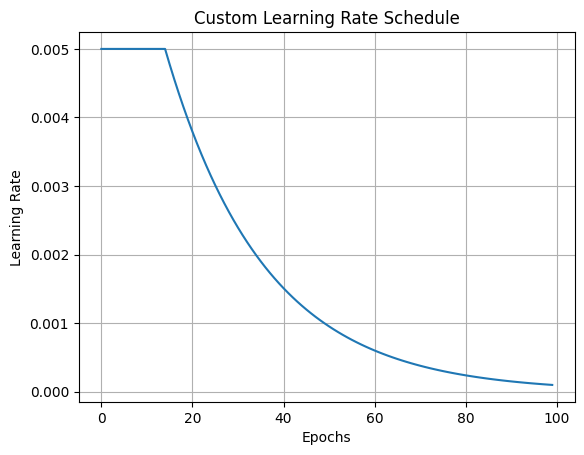

In [174]:
# lr scheduler
class CustomLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    """The learning rate decays exponentially up to factor * initial_lr after warmup_epochs"""
    def __init__(self, optimizer, initial_lr, total_epochs, warmup_epochs=10, factor=0.02):
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.factor = factor  # Controls how fast the learning rate decays
        super().__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            return [self.initial_lr for _ in self.base_lrs]  # Flat start

        decay = self.factor**((epoch - self.warmup_epochs)/(self.total_epochs - self.warmup_epochs))
        return [self.initial_lr * decay for _ in self.base_lrs]

# Example usage
initial_lr = 5e-3
total_epochs = 100
optimizer = torch.optim.SGD([torch.tensor(1.0, requires_grad=True)], lr=initial_lr)
scheduler = CustomLRScheduler(optimizer, initial_lr, total_epochs, warmup_epochs=15, factor=0.02)

# Plotting the learning rate schedule
lrs = []
for epoch in range(total_epochs):
    scheduler.step()
    lrs.append(scheduler.get_lr()[0])

plt.plot(range(total_epochs), lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Custom Learning Rate Schedule')
# plt.yscale('log')
plt.grid(True)
plt.show()

Training model using lr=0.01
Number of parameters in denoiser: 278409
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 45.292091878255206


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 34.906305521647134


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 33.633141015625


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 33.1586535929362


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 32.886924047851565
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 32.723599279785155


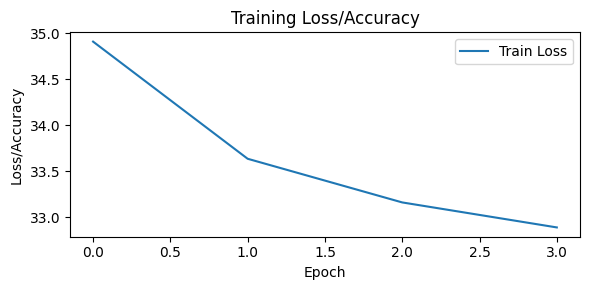

Training model using lr=0.005
Number of parameters in denoiser: 278409
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 42.35782189127604


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 34.52308857421875


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 33.053348579915365


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 32.46477662760417


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 32.15782642415365
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 31.85706480102539


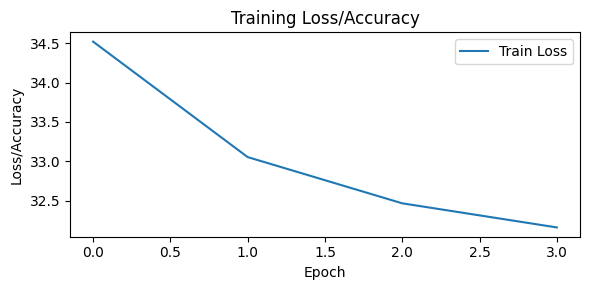

Training model using lr=0.002
Number of parameters in denoiser: 278409
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 45.205590950520836


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 35.273930712890625


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 33.299075118001305


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 32.558112259928386


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 31.94387255045573
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 31.626159106445314


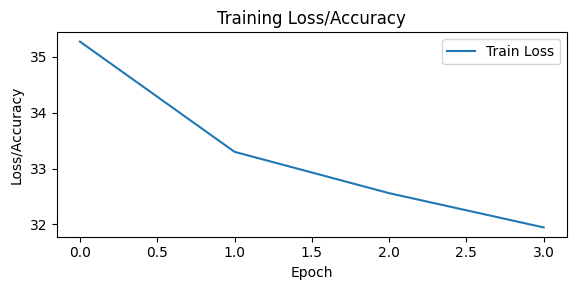

Training model using lr=0.001
Number of parameters in denoiser: 278409
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 49.82937122395833


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 37.34744640299479


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 35.41643474527995


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 34.08943428141276


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 33.26359470214844
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 32.79977490234375


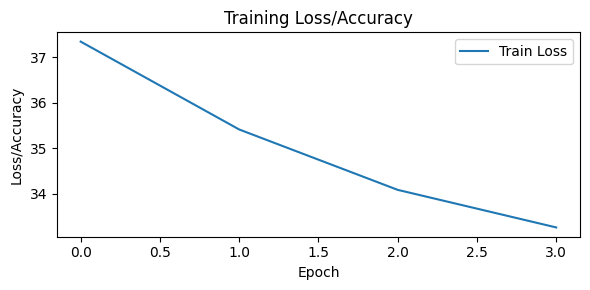

lr=0.01, train_loss=33.633141015625, test_loss=32.723599279785155
lr=0.005, train_loss=33.053348579915365, test_loss=31.85706480102539
lr=0.002, train_loss=33.299075118001305, test_loss=31.626159106445314
lr=0.001, train_loss=35.41643474527995, test_loss=32.79977490234375


In [ ]:
# Find best leraning rate for flowmatching model
import matplotlib.pyplot as plt

lrs = [1e-2, 5e-3, 2e-3, 1e-3]
third_train_losses = []
test_losses = []

for lr in lrs:
    print(f"Training model using lr={lr}")
    # denoiser = FlowMatching2(d=12, k=6, num_layers=4).to(device)
    denoiser = FlowMatching(d=48, k=6).to(device)
    # denoiser = FlowMatching3(n=4, k=6).to(device)
    optimizer = torch.optim.Adam(denoiser.parameters(), lr=lr)
    scheduler = CustomLRScheduler(optimizer, lr, total_epochs=5, warmup_epochs=0, factor=1.0)
    num_params = sum(p.numel() for p in denoiser.parameters())
    print(f"Number of parameters in denoiser: {num_params}")

    train_losses = tloop(
        denoiser, train_loader, forward_denoising, training=True,
        num_epochs=5, num_evals=5, optimizer=optimizer, train_losses=[],
        encoder=autoencoder.encoder, scheduler=scheduler, verbose=True,
    )
    third_train_losses.append(train_losses[2])
    test_losses.append(tloop(
        denoiser, test_loader, forward_denoising,
        training=False, encoder=autoencoder.encoder,
    ))
    plot_train_losses(train_losses[1:], log=False)

for lr, train_loss, test_loss in zip(lrs, third_train_losses, test_losses):
    print(f"lr={lr}, train_loss={round(train_loss, 3)}, test_loss={round(test_loss[-1], 3)}")

After 5 epochs (FlowMatching2) results are as follows for d=12, k=6, num_layers=4 (400k parameters) and I compare with the previous model (d=32, k=6):
- 5e-3: test loss 31.249                oldL 30.530
- 2e-3: test loss 29.771    29.694      old: 30.372
- 1e-3: test loss 30.827    30.085      old: 31.911
- 5e-4: test loss 30.793    30.586      old: 33.870
- 2e-4: test loss 32.420
Also note it takes 1:15min for 5 epochs.

The old model (no hidden layers, 102k params) results are these (lr, train loss at epoch 3, test loss after epoch 5, repeat):
- 2e-2   70.83   64.35
- 1e-2   34.04   32.72      33.94   32.79
- 7e-3   ??.??   32.74
- 5e-3   33.91   32.51      33.78   32.48    best
- 4e-3   34.11   32.68
- 2e-3   35.21   33.04      35.11   33.09   
- 1e-3   36.90   34.24
- 5e-4   39.53   ??.??

Results for the old model with d=48 and no hidden layers (so 216k params), same format as above:
lr=0.01,  train_loss=33.58, test_loss=32.80
lr=0.005, train_loss=33.47, test_loss=32.23
lr=0.002, train_loss=34.15, test_loss=32.07     best
lr=0.001, train_loss=35.53, test_loss=33.20
If I add two hidden layers (so 278k params) we get:
lr=0.01,  train_loss=33.63, test_loss=32.72
lr=0.005, train_loss=33.05, test_loss=31.85
lr=0.002, train_loss=33.29, test_loss=31.62     best
lr=0.001, train_loss=35.41, test_loss=32.79

For some reason it seems literally impossible to improve the first model I tried. Maybe Unet is just so good, or maybe it's because it mimics the structure of the autoencoder, or maybe it's because of the max operator. I have no idea.

Training model with d=48, n=4
Number of parameters in denoiser: 340137
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 50.30012729492187


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 37.4288539469401


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 35.08715148111979


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 33.73288944498698


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 32.98865310872396
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 32.10080380249023


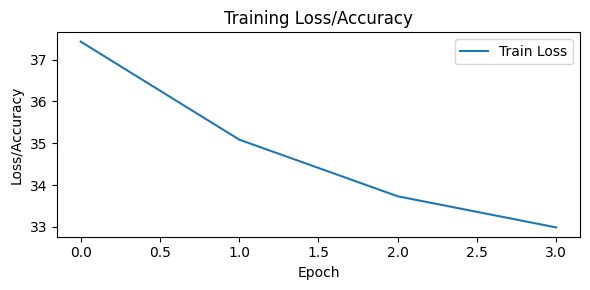

Training model with d=48, n=6
Number of parameters in denoiser: 401865
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 49.79715380859375


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 37.40143612060547


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 34.901760717773435


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 33.6054644124349


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, train loss: 32.82960198567709
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 32.22226780700684


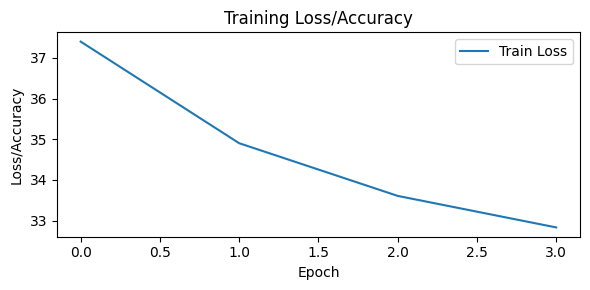

Training model with d=48, n=8
Number of parameters in denoiser: 463593
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 48.39508300374349


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 36.464145385742185


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 34.22211396077474


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
# Find best hyperparameters for flowmatching model
best_lr = 2e-3

for d, n in zip([48, 48, 48], [4, 6, 8]):
    print(f"Training model with d={d}, n={n}")
    denoiser = FlowMatching(d=d, n=n).to(device)
    optimizer = torch.optim.Adam(denoiser.parameters(), lr=lr)
    scheduler = CustomLRScheduler(optimizer, lr, total_epochs=5, warmup_epochs=0, factor=1.0)
    num_params = sum(p.numel() for p in denoiser.parameters())
    print(f"Number of parameters in denoiser: {num_params}")

    train_losses = tloop(
        denoiser, train_loader, forward_denoising, training=True,
        num_epochs=5, num_evals=5, optimizer=optimizer, train_losses=[],
        encoder=autoencoder.encoder, scheduler=scheduler, verbose=True,
    )
    tloop(
        denoiser, test_loader, forward_denoising,
        training=False, encoder=autoencoder.encoder,
    )
    plot_train_losses(train_losses[1:], log=False)

To compare the results for d, k, n=num_layers, I fix k=5, n=3 and test d for 5 epochs:
- d=6: params 107k, loss 31.556
- d=8: params 159k, loss 30.423
- d=10: params 220k, loss 30.94
Now I fix d=8, n=3 and test k:
- k=5: params 159k, loss 30.423
- k=6: params 186k, loss 30.102
- k=7: params 213k, loss 30.113
Now I fix d=8, k=6 and test n:
- n=3: params 186k, loss 30.102
- n=4: params 225k, loss 31.361
- n=5: params 265k, loss 30.233
Also note it takes 1:23-1:29min for 5 epochs

I test the standard model with lr=2e-3.
d=48, n=0: train_loss=34.15, test_loss=32.07, 215k
d=48, n=2: train_loss=33.29, test_loss=31.62, 280k
d=48, n=4: train_loss=35.08, test_loss=32.10, 340k
d=48, n=6: train_loss=34.90, test_loss=32.22, 400k

Number of parameters in denoiser: 131065
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, train loss: 43.53392946777344


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 34.97834072672526


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, train loss: 33.453839888509115


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, train loss: 30.464438598632814


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, train loss: 29.21448506266276
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 29.032862017822264


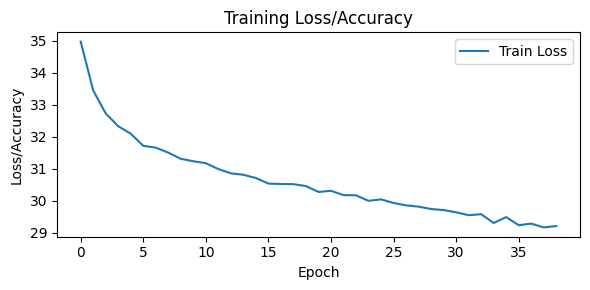

In [37]:
# Test speed and other things
lr = 5e-3
d, k, num_layers = 32, 6, 2
num_epochs = 40

# denoiser = FlowMatching2(d=d, k=k, num_layers=num_layers).to(device)
denoiser = FlowMatching(d=32, k=6).to(device)
num_params = sum(p.numel() for p in denoiser.parameters())
print(f"Number of parameters in denoiser: {num_params}")

train_losses = tloop(
    denoiser, train_loader, forward_denoising,
    training=True, num_epochs=num_epochs, lr=lr,
    train_losses=[], encoder=autoencoder.encoder, end_factor=0.02,
)
tloop(
    denoiser, test_loader, forward_denoising,
    training=False, encoder=autoencoder.encoder,
)
plot_train_losses(train_losses[1:], log=False)

- There's no significant improvement in speed by using paralelization.
- Going from 4*d to 2*d features in the down layer reduces parameters from ~180k to 109k and loss from ~30.4 to 31.379
- Removing layernorm makes the loss go from 31.379 to 31.882 (not significant)
- Going from 2*d to d in down and doubling d (to 16) instead goes from 109k to 150k and from 31.379 to 30.241
- Removing the down part and going d from 16 to 24 goes from 150k to 126k and from 30.241 to 30.741
Note that images are not soo bad even at loss 30.741.

New architecture:
Baseline:                      131k     32.61            31.28
- d=16, k=3, n=2, lr=2e-3 gives 42k and 35.08 (at 3) and 31.71 (at test after 5)
- d=16, k=3, n=3, lr=2e-3 gives 51k and 35.14 (at 3) and 31.76 (at test after 5)
- d=16, k=3, n=6, lr=2e-3 gives 69k and 34.93 (at 3) and 31.62 (at test after 5)
- d=24, k=3, n=2, lr=2e-3 gives 73k and 33.76 (at 3) and 31.26 (at test after 5) and 28.64 (at test after 20)

Using p=0.5 instead of p=0.2, the loss is 30.06 after 25 epochs starting at 5e-3 with the new architecture.
The old architecture gives 29.03 after 40 epochs starting at 5e-3

Number of parameters in denoiser: 278409
Training <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, train loss: 35.644976025390626


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, train loss: 32.664958154296876


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, train loss: 31.75696291503906


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, train loss: 30.915798767089843


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, train loss: 30.411752201334636


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, train loss: 30.078675541178384


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, train loss: 29.889066320800783


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, train loss: 29.824726924641926


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, train loss: 29.728429927571614


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, train loss: 29.57724560546875
Testing <class '__main__.FlowMatching'>...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Average loss in test set: 29.431469302368164


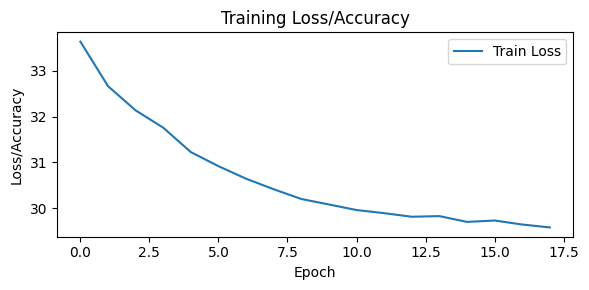

In [45]:
# Final train loop
lr = 2e-3
d, n = 48, 2
num_epochs = 20
warmup_epochs = 5

denoiser = FlowMatching(d=d, n=n).to(device)
optimizer = torch.optim.Adam(denoiser.parameters(), lr=lr)
scheduler = CustomLRScheduler(
    optimizer, initial_lr=lr, total_epochs=num_epochs,
    warmup_epochs=warmup_epochs, factor=0.02
)

num_params = sum(p.numel() for p in denoiser.parameters())
print(f"Number of parameters in denoiser: {num_params}")

train_losses = tloop(
    denoiser, train_loader, forward_denoising,
    training=True, num_epochs=num_epochs, optimizer=optimizer,
    train_losses=[], encoder=autoencoder.encoder, scheduler=scheduler,
)
tloop(
    denoiser, test_loader, forward_denoising,
    training=False, encoder=autoencoder.encoder,
)
plot_train_losses(train_losses[2:], log=False)

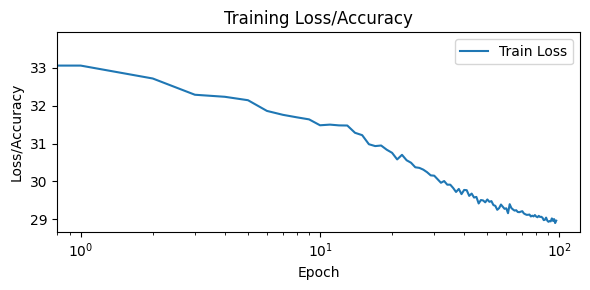

In [34]:
plot_train_losses(train_losses[2:], log=True)

Even training the d=32, k=6, n=0 for 100 epochs and achieving a loss of 29.14 in the test set is not enough. The images present the same problems as the ones trained for 20 epochs or less, it's just that now it's slightly less common.
model name: MNIST_big_denoiser_trained_longer

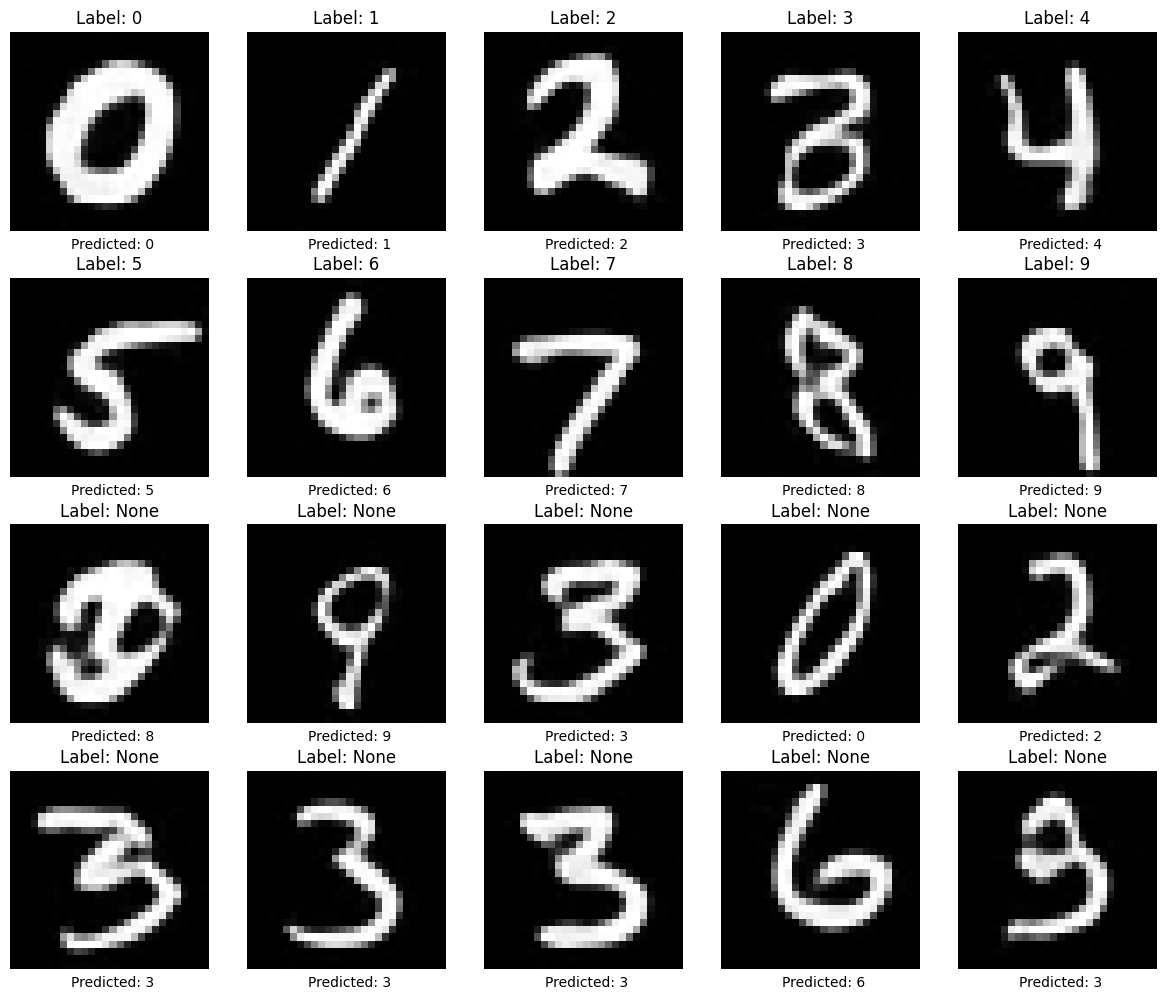

In [49]:
# Generate and classify images
import matplotlib.pyplot as plt

with torch.no_grad():
    denoiser.eval()
    x = generate_images(denoiser, autoencoder, height * width, sigma, labels=y)
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

Improving architecture
---

Why did the first model work so well? I try to find out, and I learn to use Ligthning once and for all.

In [193]:
# Architecture
# class Unet(nn.Module):
#     """(B, d, 7, 7) -> (B, d, 7, 7)"""
#     def __init__(self, d, k):
#         super().__init__()
#         self.ac = nn.GELU()
#         self.network = nn.Sequential(
#             # MBConv2d part: 7x7 -> 3x3
#             nn.Conv2d(d, k*d, kernel_size=1),
#             nn.Conv2d(k*d, k*d, kernel_size=2, groups=k*d),
#             self.ac,
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # MLP part: 3x3 -> 9 -> 9*m -> 9 -> 3x3
#             nn.Flatten(-2, -1),
#             nn.Linear(3*3, 3*3),
#             self.ac,
#             nn.Unflatten(-1, (3, 3)),
#             # MBConv2d part: 3x3 -> 7x7
#             nn.Upsample(size=7),
#             nn.Conv2d(k*d, k*d, kernel_size=3, padding=1, groups=k*d),
#             nn.Conv2d(k*d, d, kernel_size=1),
#         )
#     def forward(self, x):
#         return x + self.network(x)

class AutoEncoder2(nn.Module):
    def __init__(self, d=4, k=6):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups = nn.Upsample(scale_factor=2.5)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2*d, kernel_size=3),    # -> 26x26
            self.ac,
            self.max,                          # -> 13x13
            MBConv2d(2*d, 2*d, self.ac, k),
            nn.Conv2d(2*d, d, kernel_size=2),    # -> 12x12
            self.ac,
            self.max,                          # -> 6x6
            MBConv2d(d, d, self.ac, k),
            nn.Conv2d(d, 2, kernel_size=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(2, 2*d, kernel_size=1),
            MBConv2d(2*d, 2*d, self.ac, k),
            self.ac,
            nn.Upsample(size=15),
            nn.Conv2d(2*d, d, kernel_size=3),
            MBConv2d(d, d, self.ac, k),
            self.ac,
            nn.Upsample(size=30),
            nn.Conv2d(d, 1, kernel_size=3),
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class MaxPoolUnet(nn.Module):
    """(B, d, 7, 7) -> (B, d, 7, 7)"""
    def __init__(self, d, k):
        super().__init__()
        self.ac = nn.GELU()
        self.network = nn.Sequential(
            # MBConv2d part: 7x7 -> 3x3
            nn.Conv2d(d, k*d, kernel_size=1),
            nn.Conv2d(k*d, k*d, kernel_size=2, groups=k*d),
            self.ac,
            nn.MaxPool2d(kernel_size=2, stride=2),
            # MBConv2d part: 3x3 -> 7x7
            # nn.Conv2d(k*d, 2*d, kernel_size=1),
            # self.ac,
            nn.Upsample(size=8),
            nn.Conv2d(k*d, k*d, kernel_size=3, groups=k*d),
            nn.Conv2d(k*d, d, kernel_size=1),
        )
    def forward(self, x):
        return x + self.network(x)

class FlowMatching4(nn.Module):
    """Based on Unet and FlowMatching (original). Doesn't use padding."""
    def __init__(self, d=32, n=2, m=3, k=6):
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups  = nn.Upsample(size=8)
        self.network = nn.Sequential(
            # Convolutional part: 3 -> d
            self.ups,
            nn.Conv2d(4, 2*d, kernel_size=3),
            self.ac,
            self.ups,
            nn.Conv2d(2*d, d, kernel_size=3),
            # Unet part: d -> d
            *[MaxPoolUnet(d, k) for _ in range(n)],
            *[MBConv2d(d, d, self.ac, k) for _ in range(m)],
            # Convolutional part: d -> 1
            self.ups,
            nn.Conv2d(d, 2*d, kernel_size=3),
            self.ac,
            self.ups,
            nn.Conv2d(2*d, 2, kernel_size=3),
        )
        self.yemb = nn.Linear(10, 6*6)

    def forward(self, x, t, y):
        """x: (B, 2, 6, 6),  t: (B, 1, 1, 1),  y: (B, 10)"""
        L = 2 * torch.pi * torch.arange(1, 7, device=device).view(1, 1, 1, -1) / 7
        t = torch.cos(L * t + torch.transpose(L, -2, -1) * t**2)
        y = self.yemb(y).view(-1, 1, 6, 6)
        x = torch.cat((x, t, y), dim=1)
        return self.network(x)

In [69]:
# Load datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

batch_size = 128
train_dataset = datasets.MNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(),
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=16, pin_memory=True, persistent_workers=True,
)
test_dataset = datasets.MNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True, persistent_workers=False,
)

In [4]:
# lr scheduler
class CustomLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    """The learning rate decays exponentially up to factor * initial_lr after warmup_epochs"""
    def __init__(self, optimizer, initial_lr, total_epochs, warmup_epochs=10, factor=0.02):
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.factor = factor  # Controls how fast the learning rate decays
        super().__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            return [self.initial_lr for _ in self.base_lrs]  # Flat start

        decay = self.factor**((epoch - self.warmup_epochs)/(self.total_epochs - self.warmup_epochs))
        return [self.initial_lr * decay for _ in self.base_lrs]

# Example usage
initial_lr = 5e-3
total_epochs = 100
optimizer = torch.optim.SGD([torch.tensor(1.0, requires_grad=True)], lr=initial_lr)
scheduler = CustomLRScheduler(optimizer, initial_lr, total_epochs, warmup_epochs=15, factor=0.02)

In [ ]:
# Define Lighting model
import pytorch_lightning as pl
import torch.optim as optim

# Define Losses
CELoss = nn.CrossEntropyLoss(reduction='sum')
MSELoss = nn.MSELoss(reduction='sum')

class GeneralModel(pl.LightningModule):
    def __init__(self, model, forward_pass, encoder=None, lr=5e-3, scheduler=None,
                total_epochs=100, warmup_epochs=10, factor=0.02):
        super().__init__()
        self.model = model
        self.forward_pass = forward_pass
        self.encoder = encoder
        self.lr = lr

        self.scheduler = scheduler  # Scheduler class
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.factor = factor  # what fraction of the initial lr will be the final lr?

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        loss, acc = self.forward_pass(self.model, x, y, self.encoder)
        self.log("train_loss", loss, on_epoch=True, reduce_fx=torch.sum, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        loss, acc = self.forward_pass(self.model, x, y, self.encoder)
        self.log("val_loss", loss, on_epoch=True, reduce_fx=torch.sum, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = self.scheduler(
            optimizer, self.lr, self.total_epochs, self.warmup_epochs, self.factor,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

# Forward pass functions
def forward_classification(model, x, y, encoder):
    y_hat = model(x)
    loss = CELoss(y_hat, y)
    acc = 100 * (torch.argmax(y_hat, dim=1) == y).sum()
    return loss, acc

def forward_autoencoding(model, x, y, encoder):
    x_hat = model(x)
    loss = MSELoss(x_hat, x)
    return loss, loss

def sample_x0_t(x1):
    x0 = torch.normal(torch.zeros_like(x1), torch.ones_like(x1)).view(x1.shape)
    t = torch.rand((x1.shape[0], 1, 1, 1), device=x1.device)
    return x0, t

def erase_label(y, p):
    unif = torch.rand_like(y.to(torch.float32)).view(-1, 1).repeat(1, 10)
    y = nn.functional.one_hot(y, num_classes=10).to(torch.float32)
    return torch.where(unif < p, torch.zeros_like(y), y)

def forward_denoising(model, x, y, encoder):
    y = erase_label(y, p=0.5)
    if x.shape[2] == 28: x = encoder(x)
    x0, t = sample_x0_t(x)
    xt = (1 - t) * x0 + t * x
    vf = x - x0
    vf_hat = model(xt, t, y)
    loss = MSELoss(vf_hat, vf)
    return loss, loss


In [ ]:
# Train autoencoder
from pytorch_lightning import Trainer

autoencoder = AutoEncoder2(d=24, k=6).to(device)
total_epochs = 30
lr = 5e-3
model = GeneralModel(
    autoencoder, forward_autoencoding, encoder=None, lr=lr,
    scheduler=CustomLRScheduler, total_epochs=total_epochs,
    warmup_epochs=10, factor=0.02,
)
trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | AutoEncoder2 | 94.7 K | train
-----------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

d=32 first model achieves 1.38e+6. Doesn't look great.
d=24 second model (94.7k, 5s) achieves 1.42e+5. Looks pretty good (but not perfect).

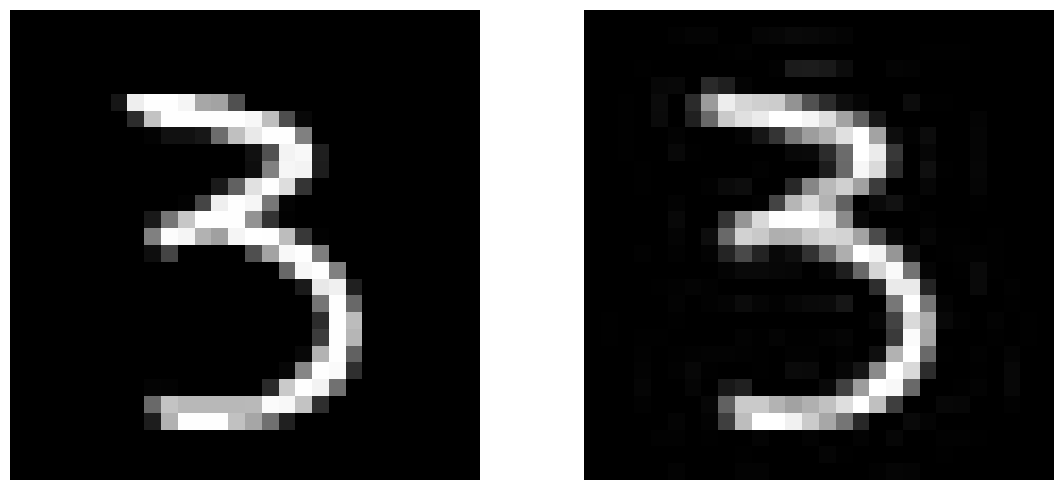

In [189]:
# Test autoencoder
import numpy as np
import matplotlib.pyplot as plt

num_batch = np.random.randint(64)
for i, (x, y) in enumerate(test_loader):
    if i < num_batch:
        continue
    break
x_hat = autoencoder(x).cpu().detach().numpy()
x_hat = np.clip(x_hat, 0, 1)                    # may remove if it works
img_num = np.random.randint(64)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(x[img_num, 0], cmap='gray')
ax1.axis('off')
ax2.imshow(x_hat[img_num, 0], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [210]:
# Train denoiser
from pytorch_lightning import Trainer

denoiser = FlowMatching4(d=32, n=3, m=5, k=6).to(device)
# denoiser = FlowMatching(d=32, n=2).to(device)
total_epochs = 20
lr = 5e-3
model = GeneralModel(
    denoiser, forward_denoising, encoder=autoencoder.encoder, lr=lr,
    scheduler=CustomLRScheduler, total_epochs=total_epochs,
    warmup_epochs=8, factor=0.02,
)
trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | FlowMatching4 | 159 K  | train
1 | encoder | Sequential    | 44.5 K | eval 
--------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.815     Total estimated model params size (MB)
62        Modules in train mode
16        Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


d=24, n=2, m=5 gives 84k and 1.25e+6
d=32, n=3, m=5 gives 159k and 1.21e+6

I wasn't able to come close to the original model.

FlowMatching with d=32, n=2 has 131K params, 3.16e+3 train_loss and 4.32e+3 val_loss or 2.09e+3, 1.97e+6 per epoch
FlowMatching4 with d=48, n=3, m=6, k=6 has 111K params, 3.62e+3 train_loss and 4.99e+3 val_loss
FlowMatching4 with d=48, n=3, m=10, k=6 has 113K params, 3.57e+3 train_loss and 4.96e+3 val_loss
FlowMatching4 with d=32, n=5, m=10, k=6 has 91K params, 3.71e+3 train_loss and 5.16e+3 val_loss
FlowMatching4 with d=64, n=2, m=10, k=6 has 133K params, 3.54e+3 train_loss and 4.83e+3 val_loss    best
FlowMatching4 with d=80, n=1, m=6, k=6 has 115K params, 3.89e+3 train_loss and 4.05e+3 val_loss
FlowMatching4 with d=64, n=3, m=6, k=6 has 188K params, 3.38e+3 train_loss and 4.78e+3 val_loss

Testing FlowMatching4 with batch_size=64, d=64, n=2, m=6, k=6 with 132K params:
lr=5e-3, batch_size=128: 3.76e+3 train_loss and 4.94e+3 val_loss and 19s, batch_size=64: 1.14e+3 train_loss and 2.35e+3 val_loss and 26s or 2.31e+6 per epoch (train)
lr=2e-3: 1.07e+3 train_loss and 2.33e+3 val_loss

Results: original model reaches 1.79e+6 after 25 epochs
2.16e+6 with d=64, n=2
2.14e+6 with lr=2e-3, d=48, n=4, after 10 epochs it reached the noise region, after 25 it reached 1.9e+6
2.20e+6 with lr=1e-3, d=48, n=4
2.22e+6 with lr=5e-3, d=48, n=4

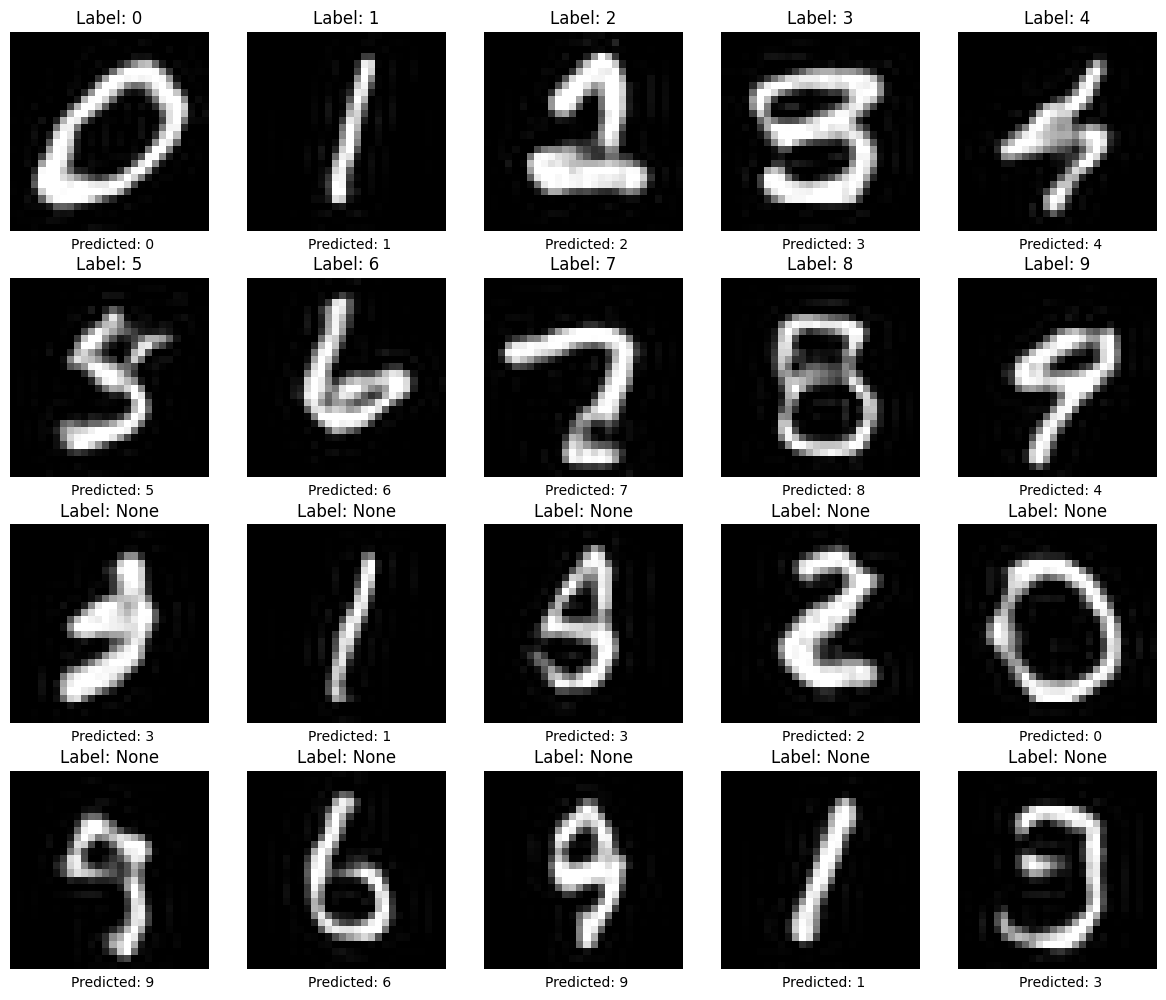

In [217]:
# Generate images
height, width, w = 4, 5, 1
sigma = lambda t: torch.sqrt(1 - t) * 0
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + width * (height - 2) * [None]

with torch.no_grad():
    x = generate_images(denoiser.to(device), autoencoder.to(device), height * width, sigma, labels=y, size=(2, 6, 6))
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

Variational Autoencoder
---

Maybe the model was generating numbers that don't exist because the encoded space doesn't have a good local structure. The idea is that if I use a variational autoencoder then the small errors made by the neural network will still lead to a plausible example.

Conclusion: VAEs in theory give a better encoding space, but they are order of magnitudes harder to train. The MSE reconstruction loss I get from them is 20 times larger than with a normal autoencoder of the same size.

The statistical model is this:

$$z\sim N(0, I)$$
$$z\vert x \sim N(E(x; \varphi), I\cdot V(x; \varphi))\,,$$
$$x\vert z \sim N(D(z; \theta), \sigma^2 I)$$

where $\mu(x;\varphi )$ is denoted by encoder_mean, $\sigma(x;\varphi)$ is encoder_var, $D(z; \theta)$ is decoder, and $\sigma^2$ is sigma.

The function to maximize is
$$ELBO(\theta, \varphi) = -\frac{1}{2}\sum\left[ \frac{\big( D(z; \theta) - x \big)^2}{\sigma} + \log \sigma + V(x; \varphi) - \log V(x;\varphi) + E(x; \varphi)^2 \right]\,,$$
where
$$z = \mu(x; \varphi) + \sqrt{\sigma(x; \varphi)} \cdot \epsilon, \,\,\, \epsilon\sim N(0, I), \,\,\, x\sim \text{Data}$$

In [ ]:
# Architecture
class MBConv2d(nn.Module):
    """
    (B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection
    Arguments are (x, t, y) when conditioning=True, and x when conditioning=False
    """
    def __init__(self, d1, d2, d3, h=5, w=5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.LayerNorm((d2, h, w)),
            nn.GELU(),
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect"),
            nn.LayerNorm((d2, h, w)),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x):
        return self.linear(x) + self.network(x)

class VariationalAutoencoder(nn.Module):
    """
    1x28x28 -> 2x6x6 -> 1x28x28
    channels: 1 -> d -> d*k -> d*k**2
    to go between channels use a factor r from the highest dimension
    """
    def __init__(self, d=5, k=2, r=3, sigma=1):
        """self.encoder and self.decoder output both mu and log_var"""
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.z_shape = (2, 6, 6)
        self.encoder = nn.Sequential(  # (B, 1, 28, 28) -> (B, *self.z_shape)
            nn.Conv2d(1, d, kernel_size=5),  # -> 24
            self.ac,
            MBConv2d(d, r*d, d, h=24, w=24),
            self.max,                          # -> 12
            MBConv2d(d, r*d*k, d*k, h=12, w=12),
            self.max,                          # -> 6
            MBConv2d(d*k, r*d*k**2, d*k**2, h=6, w=6),
            self.ac,
            nn.Dropout(p=0.2),
            nn.Conv2d(d*k**2, 4, kernel_size=3, padding=1),  # -> 1
        )
        self.decoder = nn.Sequential(  # (B, *self.z_shape) -> (B, 1, 28, 28)
            nn.Conv2d(2, 2*d*k**2, kernel_size=3, padding=1),
            self.ac,
            MBConv2d(2*d*k**2, r*d*k**2, d*k, h=6, w=6),
            nn.Upsample(13),
            MBConv2d(d*k, r*d*k, d, h=13, w=13),
            nn.Upsample(28),
            MBConv2d(d, r*d, d, h=28, w=28),
            self.ac,
            nn.Dropout(p=0.2),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )
        self.sigma = sigma  # variance of decoding

    def get_encoding(self, x):
        enc = self.encoder(x)
        mu = enc[:, :2]
        log_var = enc[:, 2:]
        return mu, torch.exp(log_var)

    def get_decoding(self, z):
        mu = self.decoder(z)
        return mu, self.sigma * torch.exp(torch.zeros_like(mu))

    def encode(self, x, random=True):
        mu, var = self.get_encoding(x)
        ep = random * torch.normal(torch.zeros_like(mu), torch.ones_like(mu)).view(mu.shape)
        return mu + torch.sqrt(var) * ep

    def decode(self, z, random=True):
        x_hat, sigma = self.get_decoding(z)
        ep = random * torch.normal(torch.zeros_like(x_hat), torch.ones_like(x_hat)).view(x_hat.shape)
        return x_hat + torch.sqrt(sigma) * ep

class Autoencoder(nn.Module):
    def __init__(self, d=5, k=2, r=3):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ups = nn.Upsample(scale_factor=2)
        self.z_shape = (4*d*k**2, )
        self.encoder = nn.Sequential(  # (B, 1, 28, 28) -> (B, 2*self.z_shape)
            nn.Conv2d(1, d, kernel_size=5),  # -> 24
            self.ac,
            MBConv2d(d, r*d, d, h=24, w=24),
            self.max,                          # -> 12
            MBConv2d(d, r*d*k, d*k, h=12, w=12),
            self.max,                          # -> 6
            MBConv2d(d*k, r*d*k**2, d*k**2, h=6, w=6),
            self.ac,
            nn.Dropout(p=0.2),
            nn.Conv2d(d*k**2, 4*d*k**2, kernel_size=6, groups=d*k**2),  # -> 1
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(  # (B, *self.z_shape) -> (B, 1, 28, 28)
            nn.Unflatten(1, (d*k**2, 2, 2)),
            nn.Upsample(6),
            nn.Conv2d(d*k**2, d*k**2, kernel_size=3, groups=d*k**2, padding=1),
            self.ac,
            MBConv2d(d*k**2, r*d*k**2, d*k, h=6, w=6),
            self.ups,                    # -> 12
            MBConv2d(d*k, r*d*k, d, h=12, w=12),
            nn.Upsample(28),
            MBConv2d(d, r*d, d, h=28, w=28),
            self.ac,
            nn.Dropout(p=0.2),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

for k in [2]:
    for d in [8]:
        for r in [3]:
            model = VariationalAutoencoder(d=d, k=k, r=r)
            print(f"Model with d={d}, k={k} has {round(sum(p.numel() for p in model.parameters())/1000)}k parameters, and hidden_layer is {model.z_shape[0]}")

Model with d=8, k=2 has 242k parameters, and hidden_layer is 2


In [ ]:
# Fit learning rate: 2e-3 is significantly better after 5 epochs, d=12, k=2, r=2 (-1.37e+8)
from pytorch_lightning import Trainer

for lr in [5e-3, 2e-3, 1e-3, 5e-4]:
    autoencoder = VariationalAutoencoder(d=8, k=2, sigma=1).to(device)
    total_epochs = 2
    model = GeneralModel(
        autoencoder, forward_var_aut, encoder=None, lr=lr,
        scheduler=CustomLRScheduler, total_epochs=total_epochs,
        warmup_epochs=0, factor=1.0,
    )
    trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
    trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 77.5 K | train
---------------------------------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 77.5 K | train
---------------------------------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 77.5 K | train
---------------------------------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 77.5 K | train
---------------------------------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

The order of the KL loss is around 8.5e+6, while the order of the MSE loss is around 1.4e+6, at least based on around 8 epochs on a 250k params model. This means that I should take $\sigma = 1/6$ to balance them.

Using $\sigma=1/6$, the 250k params model achieves loss 1.51e+7 after 35 epochs with lr from 2e-3 to 2e-5. Reconstructions look ok from far away most of the time and generation is kinda bad.

In [68]:
# Train model: after 15 epochs it reaches 5.65 mse loss per pixel (vs 2.25 of the normal autoencoder)
from pytorch_lightning import Trainer

var_autoencoder = VariationalAutoencoder(d=8, k=2, r=3, sigma=1/10).to(device)
total_epochs = 30
lr = 5e-3
model = GeneralModel(
    var_autoencoder, forward_var_aut, encoder=None, lr=lr,
    scheduler=CustomLRScheduler, total_epochs=total_epochs,
    warmup_epochs=10, factor=0.1,
)
trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 242 K  | train
---------------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.968     Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [69]:
mse_loss_total = 0
var_autoencoder.to(device)
var_autoencoder.eval()
for x, y in train_loader:
    x = x.to(device)
    z = var_autoencoder.encode(x, random=False)
    x_hat = var_autoencoder.decode(z, random=False)
    mse_loss_total += torch.sum((x_hat - x)**2).cpu().detach().item()
print(f"MSE loss for var_autoencoder: {mse_loss_total/60000}")

MSE loss for var_autoencoder: 4.015012605285644


Generated images by the model look like this:


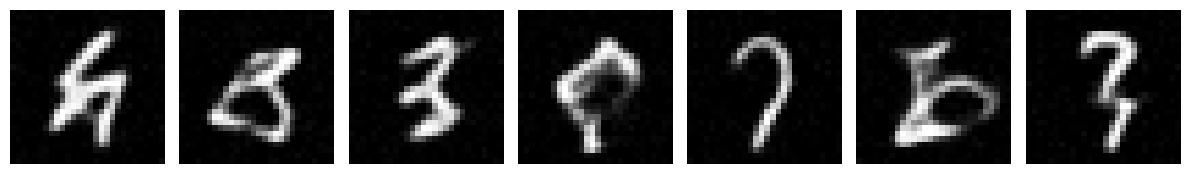

Reconstructed images by the model look like this, encoding key is (original, random, deterministic)


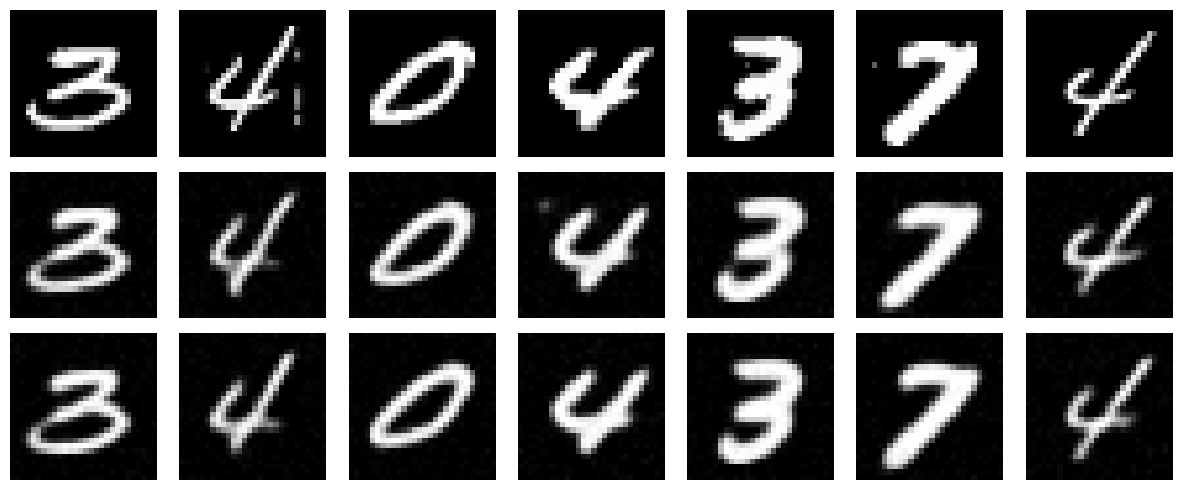

In [74]:
# Test reconstruction and generation
import numpy as np

def plot_images(images, figsize=(12, 5)):
    """images: hxw array of 2d images to plot"""
    h, w = len(images), len(images[0])
    fig, axs = plt.subplots(h, w, figsize=figsize)
    if h == 1: axs = [axs]
    for i in range(h):
        for j in range(w):
            axs[i][j].imshow(images[i][j], cmap='gray')
            axs[i][j].axis('off')
    plt.tight_layout()
    plt.show()

def var_aut_reconstruction(model, num_img=4, random=True):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            break
    z_rand = model.encode(x, random=True)
    z_dete = model.encode(x, random=False)
    x_hat_rand = torch.clip(model.decode(z_rand, random=random).cpu().detach(), 0, 1)
    x_hat_dete = torch.clip(model.decode(z_dete, random=random).cpu().detach(), 0, 1)
    plot_images((
        x[:, 0].cpu().detach(),
        x_hat_rand[:, 0],
        x_hat_dete[:, 0]
    ))

def var_aut_generation(model, num_img=4, random=True):
    """Generate images by sampling from the z distribution"""
    shape, dtype = (num_img, *model.z_shape), torch.float32
    z = torch.normal(torch.zeros(shape, dtype=dtype), torch.ones(shape, dtype=dtype)).view(shape).to(device)
    x_hat = torch.clip(model.decode(z, random=random)[:, 0], 0, 1)
    plot_images([x_hat.cpu().detach()])

var_autoencoder.eval()
var_autoencoder.to(device)
random = 0.05  # decoding key
print("Generated images by the model look like this:")
var_aut_generation(var_autoencoder, random=random, num_img=7)
print("Reconstructed images by the model look like this, encoding key is (original, random, deterministic)")
var_aut_reconstruction(var_autoencoder, random=random, num_img=7)

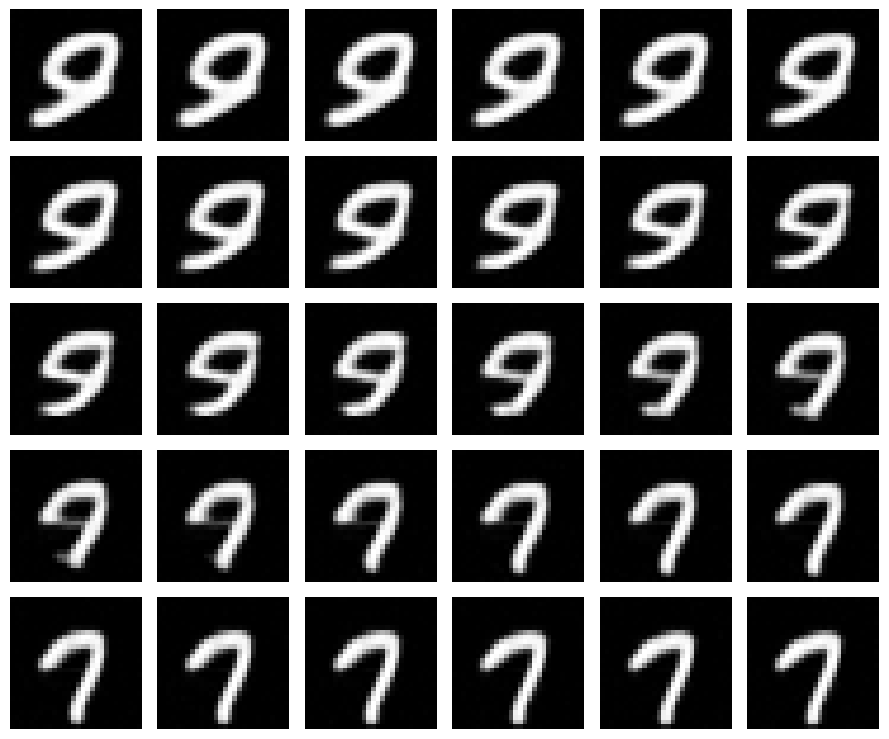

In [77]:
# Playing on the embedding space
var_autoencoder.cpu()
h, w = 5, 6
randomness = 0.01  # for decoding, encoding is always deterministic

num_batch = np.random.randint(64)
img_nums = np.random.randint(0, batch_size, size=2)
for i, (x, y) in enumerate(test_loader):
    if i >= num_batch:
        x = x[img_nums]
        break

z = var_autoencoder.encode(x, random=False)
z0, z1 = z[0], z[1]

def interpolate(z0, z1, t):
    return (1 - t) * z0 + t * z1

Ts = np.linspace(0, 1, h*w)
reconstructions = []
for t in Ts:
    z = interpolate(z0, z1, t)[None, :]
    x_hat = torch.clip(var_autoencoder.decode(z, random=randomness)[:, 0], 0, 1)
    reconstructions.append(x_hat.detach()[0])

plot_images(np.array(reconstructions).reshape(h, w, 28, 28), figsize=(1.5*w, 1.5*h))

In [ ]:
# Architecture
class MBConv2d(nn.Module):
    """(B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection"""
    def __init__(self, d1, d2, d3, h=5, w=5):
        super().__init__()
        self.temb = nn.Linear(10, d2)
        self.yemb = nn.Linear(10, d2, bias=False)
        self.nums = torch.linspace(0, 1, 10, device=device, dtype=torch.float32).view(1, 10)
        self.log_sigma = nn.Parameter(torch.tensor(-6.2, requires_grad=True))

        self.layer1 = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.LayerNorm((d2, h, w)),
            nn.GELU(),
        )
        self.layer2 = (
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect")
        )
        self.layer3 = nn.Sequential(
            nn.LayerNorm((d2, h, w)),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x, t, y):
        """x: (B, C, h, w),  t: (B, 1),  y: (B, 10)"""
        t = torch.exp(-torch.exp(self.log_sigma) * (t - self.nums)**2)
        t = self.temb(t)[:, :, None, None]
        y = self.yemb(y)[:, :, None, None]

        z = self.layer1(x)
        z = self.layer2(z) + t + y
        z = self.layer3(z)
        return self.linear(x) + z

class VarFlowMatching(nn.Module):
    def __init__(self, d=4, k=2, r=2, n=2):  # d=33 for the previous version
        super().__init__()
        self.ac   = nn.GELU()
        self.max  = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.ups  = nn.Upsample(size=5)
        self.cnn1 = nn.Sequential(
            nn.Linear(80, 100),
            nn.Unflatten(1, (5, 4, 4)),  ###
            # c_Conv2d(4, d, kernel_size=3, padding=1),
            self.ac,
        )
        self.dwnn1 = MBConv2d(d, r*k*d, k*d, 5, 5)
        self.dwnn2 = MBConv2d(k*d, r*d*k**2, d*k**2, 3, 3)
        self.final = MBConv2d(d*k**2, r*d*k**2, d*k**2, 3, 3)
        self.upnn2 = MBConv2d(d*k**2, r*d*k, d*k, 3, 3)
        self.upnn1 = MBConv2d(2*d*k, r*d, d, 5, 5)
        self.linear = nn.Linear(100, 80)

    def forward(self, x, t, y):
        """x: (B, 1, 7, 7),  t: (B, 1),  y: (B, 10)"""
        # dw1 = self.cnn1(torch.cat((x, t + y), dim=1))
        dw1 = self.cnn1(x)
        dw2 = self.dwnn1(dw1, t, y)
        end = self.max(dw2)
        end = self.dwnn2(end, t, y)
        end = self.final(end, t, y)
        up2 = self.upnn2(end, t, y)
        up2 = self.ups(up2)
        up1 = self.upnn1(torch.cat((up2, dw2), dim=1), t, y)
        return self.linear(nn.Flatten()(up1))

In [161]:
# Fit learning rate: 5e-3 better for prev model
from pytorch_lightning import Trainer

for lr in [5e-3, 2e-3, 1e-3, 5e-4]:
    denoiser = VarFlowMatching(d=4, k=4, r=2, n=2).to(device)
    total_epochs = 5
    model = GeneralModel(
        denoiser, forward_denoising, encoder=autoencoder.encode, lr=lr,
        scheduler=CustomLRScheduler, total_epochs=total_epochs,
        warmup_epochs=0, factor=1.0,
    )
    trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
    trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | VarFlowMatching | 72.9 K | train
--------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does no

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | VarFlowMatching | 72.9 K | train
--------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | VarFlowMatching | 72.9 K | train
--------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | VarFlowMatching | 72.9 K | train
--------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [162]:
denoiser = VarFlowMatching().to(device)
lr = 2e-3
total_epochs = 20
model = GeneralModel(
    denoiser, forward_denoising, encoder=autoencoder.encode, lr=lr,
    scheduler=CustomLRScheduler, total_epochs=total_epochs,
    warmup_epochs=5, factor=0.01,
)
trainer = Trainer(max_epochs=total_epochs, log_every_n_steps=5)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | VarFlowMatching | 72.9 K | train
--------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does no

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


torch.Size([20, 80])


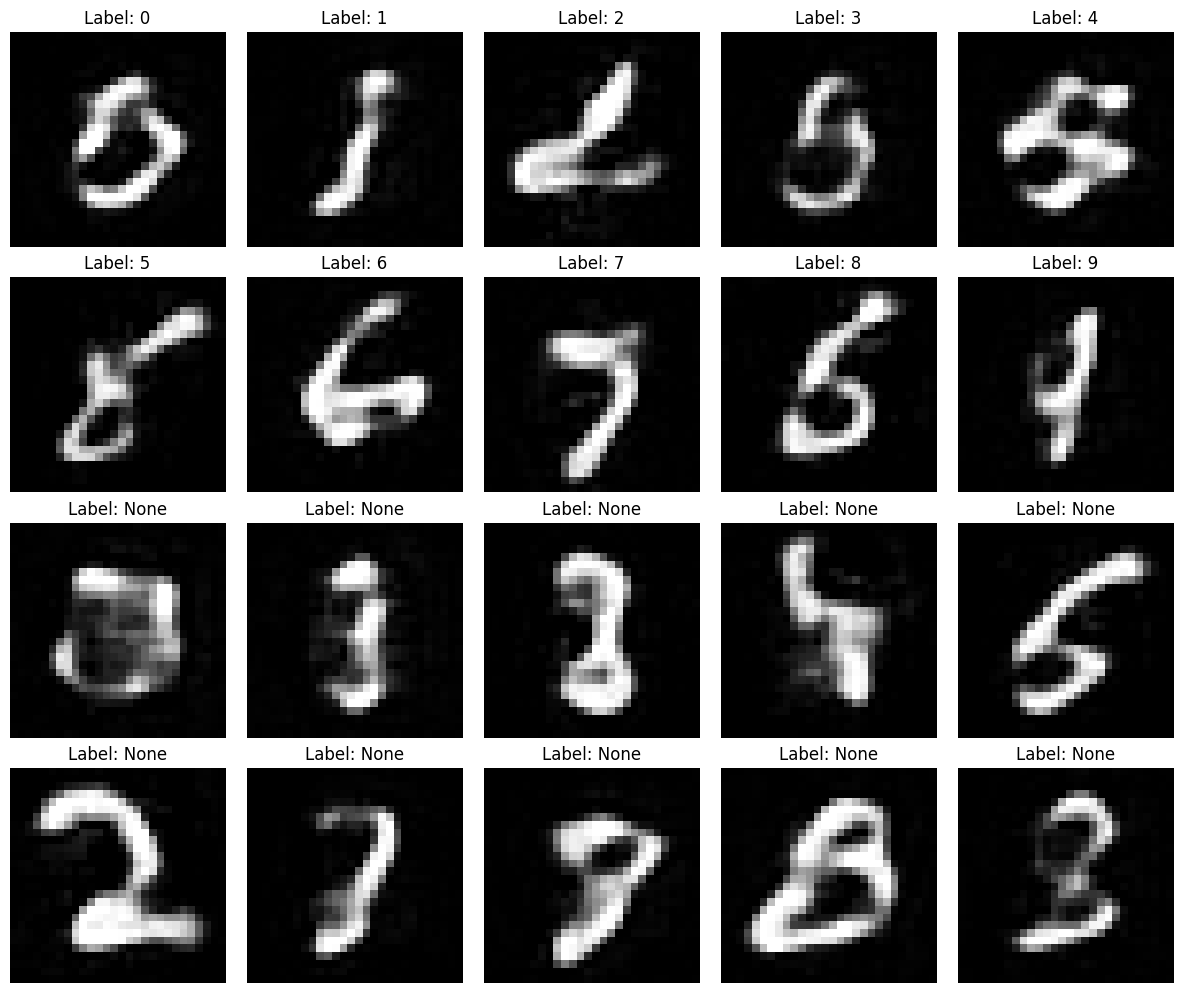

In [177]:
# Generate images
height, width, w = 4, 5, 4
sigma = lambda t: torch.sqrt(1 - t) * 1
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + width * (height - 2) * [None]

with torch.no_grad():
    x = generate_images(denoiser.to(device), autoencoder.to(device), height * width, sigma, labels=y, size=(80,))
    # y_pred = classifier(x)
    # y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()

fig, axes = plt.subplots(height, width, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("Label: " + str(y[i]))
    # ax.text(14, 30, "Predicted: " + str(int(y_pred[i])), fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

Final attempt at generating MNIST
---

This part *will* work.

So far:
- normal autoencoder is much better than the variational one. It reaches MSE loss of 1.11/image, while the vae reaches around 20/image.
- normal autoencoder is really bad for difussion. The embedding space is not continuous and this leads to weird shapes.
- the smaller the embedding dimension in the normal autoencoder, the worse the interpolation becomes (although loss doesn't increase that much)

Important finding:
- the dimensionality of the dataset seems to be 12 when sigma=0.2. When dim=12, the variances of the vae are all small, but when dim=15, the distribution is bimodal and some are around 1 to satisfy the kl term.
- when using this embedding dimension, training seems to be a lot easier. A model of 60k params performed almost the same as a model of 250k in dimension 9, and using dimension 18 is much worse.

Regarding normal autoencoders:
- They work ok if the flow model is good, but it seems like no matter how good it is, many images will still look weird.
- VAEs are a bit blurry but they look more like numbers

In [124]:
# Architectures
class MBConv2d(nn.Module):
    """(B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection"""
    def __init__(self, d1, d2, d3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect"),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x):
        return self.linear(x) + self.network(x)

class MBConv2d_con(nn.Module):
    """(B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection"""
    def __init__(self, d1, d2, d3, h=5, w=5):
        super().__init__()
        self.temb = nn.Linear(10, d2)
        self.yemb = nn.Linear(10, d2, bias=False)
        self.nums = torch.linspace(0, 1, 10, device=device, dtype=torch.float32).view(1, 10)
        self.log_sigma = nn.Parameter(torch.tensor(-6.2, requires_grad=True))

        self.layer1 = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            # nn.LayerNorm((d2, h, w)),
            nn.GELU(),
        )
        self.layer2 = (
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect")
        )
        self.layer3 = nn.Sequential(
            # nn.LayerNorm((d2, h, w)),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x, t, y):
        """x: (B, C, h, w),  t: (B, 1),  y: (B, 10)"""
        t = torch.exp(-torch.exp(self.log_sigma) * (t - self.nums)**2)
        t = self.temb(t)[:, :, None, None]
        y = self.yemb(y)[:, :, None, None]

        z = self.layer1(x)
        z = self.layer2(z) + t + y
        z = self.layer3(z)
        return self.linear(x) + z

class AutoEncoder(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=32, k=6, n=0, z_dim=20):
        super().__init__()
        self.z_shape = (1, 3, 3)
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//2, kernel_size=5, padding=2, stride=2),  # -> 14x14  # delete stride
            self.ac,
            MBConv2d(d//2, k*d//2, d//4),
            self.max,                   # -> 7x7
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 3x3
            MBConv2d(d//2, k*d, d),
            *[MBConv2d(d, k*d, d) for _ in range(n)],
            nn.Flatten(1),                          
            nn.GELU(),
            nn.Linear(d*9, z_dim),
            nn.Unflatten(-1, (1, z_dim, 1))
        )
        self.decoder = nn.Sequential(
            nn.Flatten(1),                           
            nn.Linear(z_dim, 2*9*d),
            nn.Unflatten(-1, (2*d, 3, 3)),
            MBConv2d(2*d, k*d, d),
            *[MBConv2d(d, k*d, d) for _ in range(n)],
            nn.Upsample(7),                    # -> 7x7  # change to self.up
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                                    # delete this
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VarAutoEncoder(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=32, k=6, n=0, sigma=0.2, z_dim=12):
        super().__init__()
        self.z_shape = (1, z_dim, 1)
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        # define models
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//2, kernel_size=5, padding=2, stride=2),  
            self.ac,  
            MBConv2d(d//2, k*d//2, d//4),
            self.max,                   # -> 7x7
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 3x3
            MBConv2d(d//2, k*d, d),
            *[MBConv2d(d, k*d, d) for _ in range(n)],
            # MBConv2d(d, k*d, 2),                  
            nn.Flatten(1),                          
            nn.GELU(),
            nn.Linear(d*9, 2*z_dim),
            nn.Unflatten(-1, (2, z_dim, 1))
        )
        self.decoder = nn.Sequential(
            nn.Flatten(1),                           
            nn.Linear(z_dim, 2*9*d),
            nn.Unflatten(-1, (2*d, 3, 3)),
            # nn.Conv2d(1, 2*d, kernel_size=3, padding=1, padding_mode='reflect'),  
            MBConv2d(2*d, k*d, d),
            *[MBConv2d(d, k*d, d) for _ in range(n)],
            nn.Upsample(7),                    # -> 7x7  
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                            
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )
        self.sigma = torch.tensor(sigma, device=device, dtype=torch.float32, requires_grad=False)

    def get_encoding(self, x):
        repr = self.encoder(x)
        mu = repr[:, :1]
        log_var = repr[:, 1:]
        return mu, torch.exp(log_var) / 100

    def get_decoding(self, z):
        x_hat = self.decoder(z)
        return x_hat, self.sigma * torch.ones_like(x_hat)

    def encode(self, x, random=False):
        mu, var = self.get_encoding(x)
        ep = random * torch.normal(torch.zeros_like(mu), torch.ones_like(mu)).view(mu.shape)
        return mu + torch.sqrt(var) * ep

    def decode(self, z, random=False):  # no randomness
        x_hat, var = self.get_decoding(z)
        return x_hat

class VarAutoEncoder2(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=24, k=6, sigma=0.2, z_dim=12):
        super().__init__()
        self.z_shape = (1, z_dim, 1)
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        # define models
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//4, kernel_size=7, padding=3, stride=2),  
            # self.ac,  
            MBConv2d(d//4, k*d//2, d//4),
            self.max,                   # -> 7x7
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 3x3
            MBConv2d(d//2, k*d, d),
            # MBConv2d(d, k*d, 2),                  
            nn.Flatten(1),                          
            nn.GELU(),
            nn.Linear(d*9, 2*z_dim),
            nn.Unflatten(-1, (2, z_dim, 1))
        )
        self.decoder = nn.Sequential(
            nn.Flatten(1),                           
            nn.Linear(z_dim, 9*d),
            nn.Unflatten(-1, (d, 3, 3)),
            MBConv2d(d, k*d, d),
            nn.Upsample(7),                    # -> 7x7  
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                            
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )
        self.sigma = torch.tensor(sigma, device=device, dtype=torch.float32, requires_grad=False)

    def get_encoding(self, x):
        repr = self.encoder(x)
        mu = repr[:, :1]
        log_var = repr[:, 1:]
        return mu, torch.exp(log_var) / 100

    def get_decoding(self, z):
        x_hat = self.decoder(z)
        return x_hat, self.sigma * torch.ones_like(x_hat)

    def encode(self, x, random=False):
        mu, var = self.get_encoding(x)
        ep = random * torch.normal(torch.zeros_like(mu), torch.ones_like(mu)).view(mu.shape)
        return mu + torch.sqrt(var) * ep

    def decode(self, z, random=False):  # no randomness
        x_hat, var = self.get_decoding(z)
        return x_hat

class FlowMatching(nn.Module):
    """
    Learns to generate images in the encoded space of the saved autoencoder.
    shape of encoding: (B, 1, 7, 7)
    """
    def __init__(self, hidden_layer=150, z_dim=12):
        super().__init__()
        # self.network = nn.Sequential(
        #     nn.Conv2d(3, d//4, kernel_size=3, padding=1, padding_mode='reflect'),
        #     nn.GELU(),
        #     MBConv2d(d//4, k*d//2, d//2),
        #     MBConv2d(d//2, k*d, d),
        #     *[MBConv2d(d, k*d, d) for _ in range(n)],
        #     MBConv2d(d, k*d, d//2),
        #     MBConv2d(d//2, k*d//2, d//4),
        #     nn.Conv2d(d//4, 1, kernel_size=3, padding=1, padding_mode='reflect'),
        # )
        self.z_dim = z_dim
        self.network = nn.Sequential(
            nn.Linear(z_dim + 10 + 2, hidden_layer),
            nn.GELU(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_layer, z_dim),
        )
        # self.temb = nn.Linear(10, 3*3)
        # self.yemb = nn.Linear(10, 3*3, bias=False)
        # self.nums = torch.linspace(0, 1, 10, device=device, dtype=torch.float32).view(1, 10)
        # self.log_sigma = nn.Parameter(torch.tensor(-6.2, requires_grad=True))

    def forward(self, x, t, y):
        """x: (B, 128),  t: (B, 1, 1, 1),  y: (B, 10)"""
        # T = torch.exp(-torch.exp(self.log_sigma) * (t.view(-1, 1) - self.nums)**2)
        # T = self.temb(T).view(-1, 1, 3, 3)
        # Y = self.yemb(y).view(-1, 1, 3, 3)

        # x = torch.cat((x, T, Y), dim=1)
        # x = self.encoder(x)
        # z = self.bottom(x)
        # x = torch.cat((x, z), dim=1)
        # return self.decoder(x)
        # return self.network(x)
        x = x.view(-1, self.z_dim)
        t = t.view(-1, 1)
        x = torch.cat((x, t, t**2, y), dim=1)
        return self.network(x).view(-1, 1, self.z_dim, 1)

class Classifier(nn.Module):
    def __init__(self, d=16, k=6):
        super().__init__()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sm = nn.Softmax(dim=-1)
        self.network = nn.Sequential(
            nn.Conv2d(1, d//4, kernel_size=3, padding=1),
            nn.GELU(),
            self.max,                         # -> 14
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                         # -> 7
            MBConv2d(d//2, k*d, d),
            self.max,                         # -> 3
            MBConv2d(d, k*d, d),
            self.max,                         # -> 1
            nn.Flatten(),
            nn.Linear(d, 10),
        )

    def forward(self, x):
        x = self.network(x).view(-1, 10)
        return self.sm(x)

import os
file_names = [
    "MNIST_vae_dim12_small",
    "MNIST_flowmatching_dim12_small",
    "MNIST_classifier",
]
architectures = [
    "VarAutoEncoder",
    "FlowMatching",
    "Classifier",
]
model_names = [
    "vae",
    "flowmatching",
    "classifier",
]
for file_name, architecture, model_name in zip(file_names, architectures, model_names):
    exec(f"{model_name} = {architecture}().to(device)")
    save_path = os.path.join("..", "NN_parameters\\Generative models", file_name + ".pth")
    exec(f"{model_name}.load_state_dict(torch.load(save_path))")
    exec(f"{model_name}.eval()")
    exec(f"num_params = sum(p.numel() for p in {model_name}.parameters())")
    exec(f"print('Number of parameters in {model_name}: {num_params}')")

Number of parameters in vae: 72001
Number of parameters in flowmatching: 28212
Number of parameters in classifier: 9298


For (1, 3, 3) model, 5e-3 is the best lr, second place is 2.5e-3

In [27]:
# Tune autoencoder hyperparameters. Epoch 1 - MSE: 11075.3975, KL: 14590.0107
# lr=2e-3 is best for d=32, k=6 (110K params), but lr=5e-3 is basically the same
# Code is obsolete now (because of the scheduler)
from pytorch_lightning import Trainer

for lr in [1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]:
    print(f"--------------------------------------training lr={lr}--------------------------------------")
    # autoencoder = VarAutoEncoder(d=32, k=6, sigma=1).to(device)
    autoencoder = AutoEncoder(d=32, k=6).to(device)
    total_epochs = 5
    milestones = [10]
    # Define scheduler
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.5)
    # Define Ligthning model
    model = GeneralModel(autoencoder, forward_autoencoding, optimizer, scheduler, encoder=None)
    trainer = Trainer(max_epochs=total_epochs)
    # Train
    trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 89.5 K | train
----------------------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


--------------------------------------training lr=0.01--------------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 83.8755
Epoch 1 - train_mse: 41.5968
Epoch 2 - train_mse: 30.9368
Epoch 3 - train_mse: 25.2315


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4 - train_mse: 22.2766


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 89.5 K | train
----------------------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


--------------------------------------training lr=0.005--------------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 56.9260
Epoch 1 - train_mse: 29.1994
Epoch 2 - train_mse: 20.8998
Epoch 3 - train_mse: 18.4612


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4 - train_mse: 16.7904


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 89.5 K | train
----------------------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


--------------------------------------training lr=0.0025--------------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 50.0543
Epoch 1 - train_mse: 25.8952
Epoch 2 - train_mse: 20.9471
Epoch 3 - train_mse: 18.8555


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4 - train_mse: 17.5106
--------------------------------------training lr=0.001--------------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 89.5 K | train
----------------------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 60.9377
Epoch 1 - train_mse: 34.2426
Epoch 2 - train_mse: 26.5239
Epoch 3 - train_mse: 23.1688


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4 - train_mse: 21.2855


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 89.5 K | train
----------------------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


--------------------------------------training lr=0.0005--------------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 62.2328
Epoch 1 - train_mse: 41.5679
Epoch 2 - train_mse: 32.9678
Epoch 3 - train_mse: 28.5925


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4 - train_mse: 26.1206


The non variational autoencdoer is orders of magnitude better.
- MSE error is 1.33 for d=64, k=6 (~300k) after 5 epochs, and it takes 21s for batch_size=128.
- MSE error is 1.11 for d=48, k=6 (~200k) after 10 epochs, and it takes 15s for batch_size=128.

Note: lr=3e-3 diverges sometimes, which in theory is good.

d=24, k=5, n=0 achieves 12.64 on lr = 5e-3, total_epochs = 30, milestones = [10, 18, 25], gamma=0.5. It gets stuck around 14 for a while.

d=32, k=5, n=2 achieves 9.63 on lr = 5e-3, total_epochs = 30, milestones = [10, 18, 25], gamma=0.5. It gets stuck around 14 for a while.

In [207]:
# Train autoencoder. mse loss is 1.114 per image (2, 7, 7). 1.75 per image (1, 7, 7)
#                    d=32, k=6 gives 11.8 per image (1, 3, 3)
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
autoencoder = AutoEncoder(d=32, k=6, n=0, z_dim=25).to(device)
lr = 5e-3
total_epochs = 45
milestones = [15, 20, 25, 30, 34, 37, 40]
gamma = 0.7
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = GeneralModel(autoencoder, forward_autoencoding, optimizer, scheduler, encoder=None)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 79.8 K | train
----------------------------------------------
79.8 K    Trainable params
0         Non-trainable params
79.8 K    Total params
0.319     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [15, 20, 25, 30, 34, 37, 40]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 31.4107
Epoch 1 - train_mse: 12.7795
Epoch 2 - train_mse: 10.0250
Epoch 3 - train_mse: 8.7450
Epoch 4 - train_mse: 8.0754
Epoch 5 - train_mse: 7.5459
Epoch 6 - train_mse: 7.1411
Epoch 7 - train_mse: 6.8478
Epoch 8 - train_mse: 6.6293
Epoch 9 - train_mse: 6.4465
Epoch 10 - train_mse: 6.3093
Epoch 11 - train_mse: 6.1341
Epoch 12 - train_mse: 6.0518
Epoch 13 - train_mse: 5.9790
Epoch 14 - train_mse: 5.8300
Epoch 15 - train_mse: 5.4946
Epoch 16 - train_mse: 5.4732
Epoch 17 - train_mse: 5.4746
Epoch 18 - train_mse: 5.4181
Epoch 19 - train_mse: 5.3712
Epoch 20 - train_mse: 5.1536
Epoch 21 - train_mse: 5.1349
Epoch 22 - train_mse: 5.1268
Epoch 23 - train_mse: 5.1018
Epoch 24 - train_mse: 5.0726
Epoch 25 - train_mse: 4.9349
Epoch 26 - train_mse: 4.9168



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

sigma=1 gives a mediocre mse and good kl. Images in general are bad.

sigma=0.1, 0.2 gives a good mse and super bad kl. Reconstructed images are good but embedding space is not dense.

when sigma=0.01, the embedding space dies completely

when sigma=2, the model is not able to reconstruct images

Finally, kl_loss=49 seems to be the minimum attainable. When the loss is this low, the only one that changes is the mse.

The graph of variances (in encoding space) is bimodal. Variances near 1 are so the distribution is close to N(0, 1). Variances near 0 are so the reconstruction loss is low.

(1, 3, 3), d=32, k=5, n=2, sigma=0.2 gives mse=12.82, kl=24.24 with epochs=25, milestones=[8, 15, 20], gamma=0.7

(1, 3, 3), d=48, k=5, n=2, sigma=0.2 gives mse=10.9, kl=34.4 with epochs=45, milestones=[15, 20, 25, 30, 34, 37, 40], gamma=0.8

d=32, k=5, n=0, sigma=0.2, z_dim=12 and got to mse=10.8, kl=36.5

d=24, k=6, sigma=0.2 gives 13.7, 36.2 at 10 epochs

d=32, k=8 -> 12.5

old model -> 12.9

In [160]:
# Train vae. sigma=1 gives mse~20, kl~50. sigma=0.1 gives mse~5, kl~150. sigma=0.2 gives mse~9, kl~100
#   d=32, k=6, n=1, sigma=0.5, epochs=20 gives mse=17.6, kl=28.0 (after normalization)
#   d=64, k=6, n=3, sigma=0.5, epochs=10 gives mse=16.0, kl=26.7, epochs=20 gives mse=14.7, kl=26.7
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
vae = VarAutoEncoder(d=32, k=6, sigma=0.1, z_dim=16).to(device)
lr = 5e-3
total_epochs = 45
milestones = [15, 20, 25, 30, 34, 37, 40]
gamma = 0.7
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(vae.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = VAEModel(vae, forward_var_aut, optimizer, scheduler, encoder=None)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | VarAutoEncoder | 76.6 K | train
-------------------------------------------------
76.6 K    Trainable params
0         Non-trainable params
76.6 K    Total params
0.306     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [15, 20, 25, 30, 34, 37, 40]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 39.1468, train_kl: 27.8286
Epoch 1 - train_mse: 18.1862, train_kl: 44.3854
Epoch 2 - train_mse: 14.8537, train_kl: 47.5247
Epoch 3 - train_mse: 13.2957, train_kl: 48.9275
Epoch 4 - train_mse: 12.4907, train_kl: 49.5334
Epoch 5 - train_mse: 11.8889, train_kl: 49.9508
Epoch 6 - train_mse: 11.5544, train_kl: 50.0889
Epoch 7 - train_mse: 11.1077, train_kl: 50.2370
Epoch 8 - train_mse: 10.9152, train_kl: 50.3751
Epoch 9 - train_mse: 10.6416, train_kl: 50.5050
Epoch 10 - train_mse: 10.5323, train_kl: 50.6970
Epoch 11 - train_mse: 10.2153, train_kl: 50.8400
Epoch 12 - train_mse: 10.0833, train_kl: 51.0287
Epoch 13 - train_mse: 9.9931, train_kl: 51.0629
Epoch 14 - train_mse: 9.9089, train_kl: 51.1446
Epoch 15 - train_mse: 9.4305, train_kl: 51.3733
Epoch 16 - train_mse: 9.3674, train_kl: 51.3450
Epoch 17 - train_mse: 9.3020, train_kl: 51.4432
Epoch 18 - train_mse: 9.3040, train_kl: 51.4381
Epoch 19 - train_mse: 9.2418, train_kl: 51.4094
Epoch 20 - train_mse: 8.9140, train_k


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

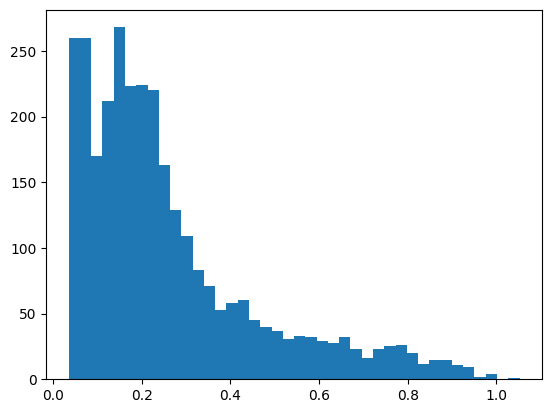

In [161]:
# Distribution of standard deviations of embedding space
for x, y in test_loader:
    break
vae.to(device)
mu, var = vae.get_encoding(x.to(device))

stds = torch.sqrt(var).reshape(-1).cpu().detach().numpy()
plt.hist(stds, bins=40)
plt.show()

Reconstructed images by the model look like this:


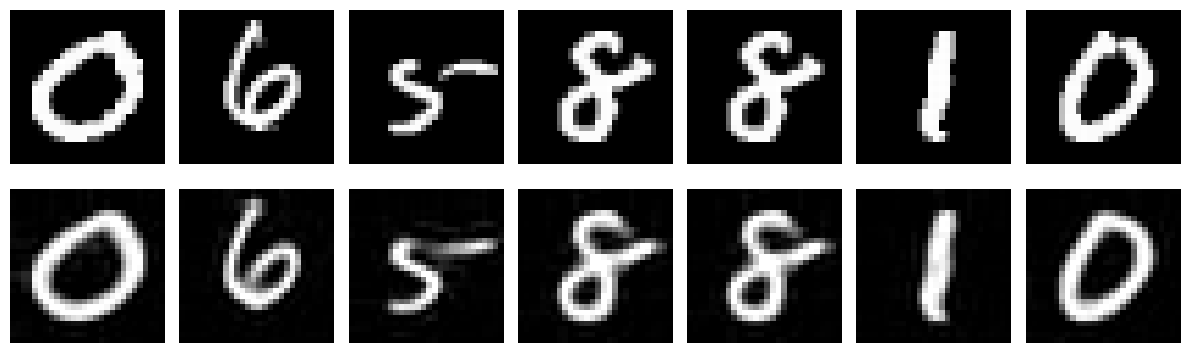

In [ ]:
# Test reconstruction
import numpy as np

def aut_generation(model, num_img=4):
    shape, dtype = (num_img, *model.z_shape), torch.float32
    z = torch.normal(torch.zeros(shape, dtype=dtype), torch.ones(shape, dtype=dtype)).view(shape).to(device)
    x_hat = torch.clip(model.decode(z)[:, 0], 0, 1)
    plot_images([x_hat.cpu().detach()])

def aut_reconstruction(model, vae_val=False, num_img=4):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            break
    z = model.encode(x, random=1*vae_val) if vae_val else model.encoder(x)
    x_hat = model.decode(z) if vae_val else model.decoder(z)
    x_hat = torch.clip(x_hat.cpu().detach(), 0, 1)
    plot_images((x[:, 0].cpu().detach(), x_hat[:, 0]))

model_ml = vae
model_ml.eval()
model_ml.to(device)
# model_ml.sigma.to(device)
print("Reconstructed images by the model look like this:")
# aut_generation(model_ml, 7)
aut_reconstruction(model_ml, 0.001, num_img=7)

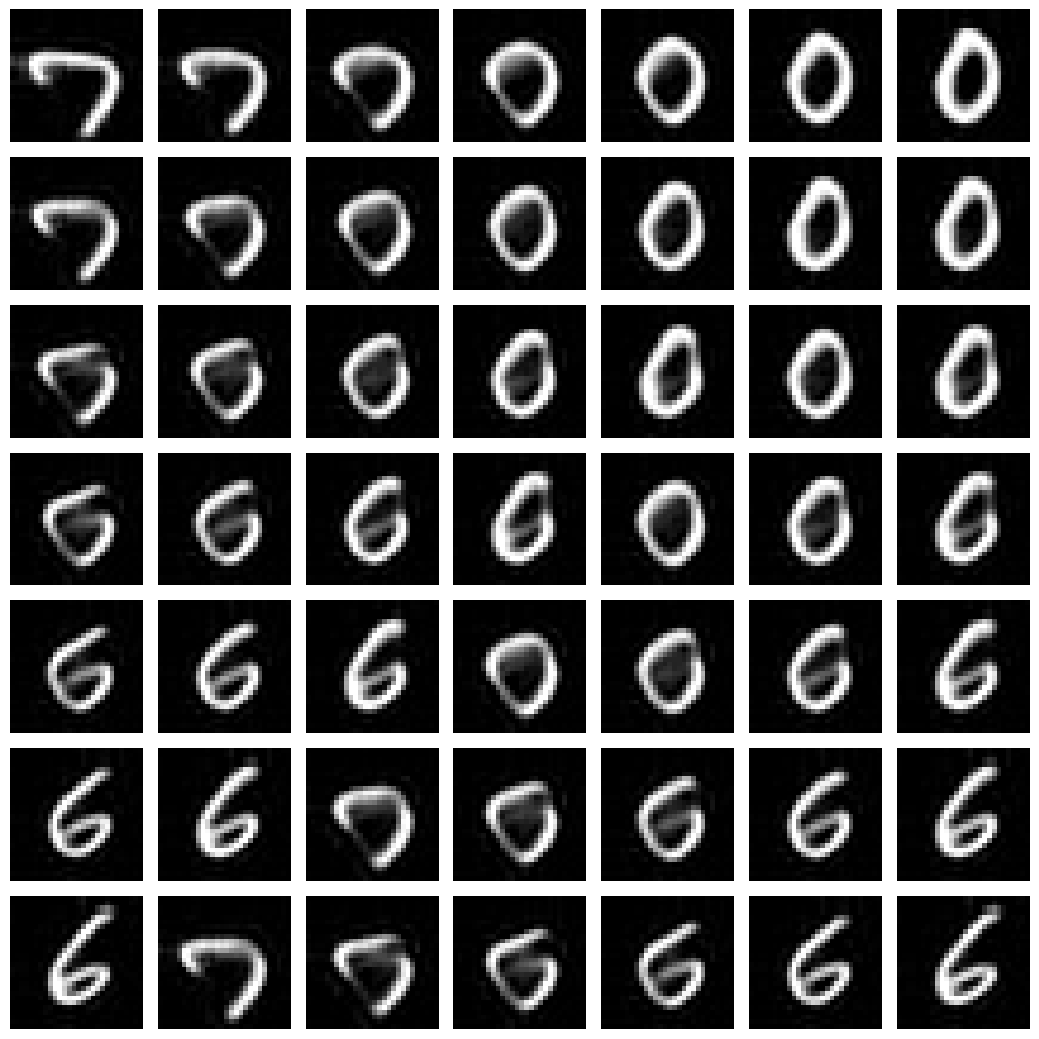

In [ ]:
# Test embedding space interpolation
vae.sigma.to(device)
vae.to(device)
plot_interpolation(vae, use_vae=True, s=3, scale=1.5)

In [221]:
# Initialize encoded dataset
model_ml = vae
encoded_dataset_x = torch.zeros(60000, *model_ml.z_shape)  ###
encoded_dataset_y = torch.zeros(60000, dtype=torch.float64)
encoded_val_x = torch.zeros(10000, *model_ml.z_shape)
encoded_val_y = torch.zeros(10000, dtype=torch.float64)
model_ml.eval()
model_ml.to(device)

# Pass one: record z and y in a list
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    idx = 0
    for x, y in train_loader:
        B = x.shape[0]
        z = model_ml.encode(x.to(device)).detach().cpu()  ###
        encoded_dataset_x[idx: idx + B] = z
        encoded_dataset_y[idx: idx + B] = y
        idx += B

    idx = 0
    for x, y in test_loader:
        B = x.shape[0]
        z = model_ml.encode(x.to(device)).detach().cpu()  ###
        encoded_val_x[idx: idx + B] = z
        encoded_val_y[idx: idx + B] = y
        idx += B

In [222]:
# Define encoded dataloader
class EncodedDataset(torch.utils.data.Dataset):
    """Given tensors of x and y, create a dataset that returns pairs"""
    def __init__(self, x_tensor, y_tensor):
        assert len(x_tensor) == len(y_tensor), "x and y must have the same length"
        self.x = x_tensor.cpu()
        self.y = y_tensor.cpu()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

torch.cuda.empty_cache()
encoded_dataset = EncodedDataset(encoded_dataset_x, encoded_dataset_y)
encoded_val = EncodedDataset(encoded_val_x, encoded_val_y)
encoded_train_loader = torch.utils.data.DataLoader(
    encoded_dataset, batch_size=batch_size, shuffle=True,
    # num_workers=16, pin_memory=True, persistent_workers=True,
)
encoded_val_loader = torch.utils.data.DataLoader(
    encoded_val, batch_size=batch_size, shuffle=False,
)

In [237]:
# Train flowmatching model. mse loss is 1.114 per image
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
flowmatching = FlowMatching(hidden_layer=300, z_dim=autoencoder.z_shape[1]).to(device)
lr = 1e-2
total_epochs = 20
milestones = [5, 9, 12, 15, 18]
gamma = 0.3
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(flowmatching.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = GeneralModel(flowmatching, forward_denoising, optimizer, scheduler, encoder=None)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(
    model,
    encoded_train_loader,
    # encoded_val_loader,
    # val_check_interval=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | FlowMatching | 109 K  | train
-----------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [5, 9, 12, 15, 18]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 0.6692
Epoch 1 - train_mse: 0.6199
Epoch 2 - train_mse: 0.6048
Epoch 3 - train_mse: 0.6017
Epoch 4 - train_mse: 0.5957
Epoch 5 - train_mse: 0.5602
Epoch 6 - train_mse: 0.5515
Epoch 7 - train_mse: 0.5514
Epoch 8 - train_mse: 0.5501
Epoch 9 - train_mse: 0.5397
Epoch 10 - train_mse: 0.5387
Epoch 11 - train_mse: 0.5380
Epoch 12 - train_mse: 0.5344
Epoch 13 - train_mse: 0.5340
Epoch 14 - train_mse: 0.5326
Epoch 15 - train_mse: 0.5323
Epoch 16 - train_mse: 0.5332
Epoch 17 - train_mse: 0.5333
Epoch 18 - train_mse: 0.5321


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 - train_mse: 0.5322


In [29]:
# Train classifier
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
classifier = Classifier(d=16, k=6).to(device)
lr = 3e-3
total_epochs = 10
milestones = [4, 7]
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.5)
# Define Ligthning model
model = ClassifierModel(classifier, forward_classification, optimizer, scheduler, encoder=None)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Classifier | 9.3 K  | train
---------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [4, 7]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - val_acc: 10.1562


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - val_acc: 85.3100
Epoch 0 - train_acc: 68.4283


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - val_acc: 91.7300
Epoch 1 - train_acc: 86.1967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - val_acc: 96.7000
Epoch 2 - train_acc: 95.0550


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - val_acc: 96.8500
Epoch 3 - train_acc: 96.1867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - val_acc: 97.5400
Epoch 4 - train_acc: 97.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - val_acc: 97.7100
Epoch 5 - train_acc: 97.6167


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - val_acc: 97.8000
Epoch 6 - train_acc: 97.7483


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - val_acc: 98.3400
Epoch 7 - train_acc: 98.2167


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - val_acc: 98.1000
Epoch 8 - train_acc: 98.3433


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9 - val_acc: 98.2800
Epoch 9 - train_acc: 98.4400


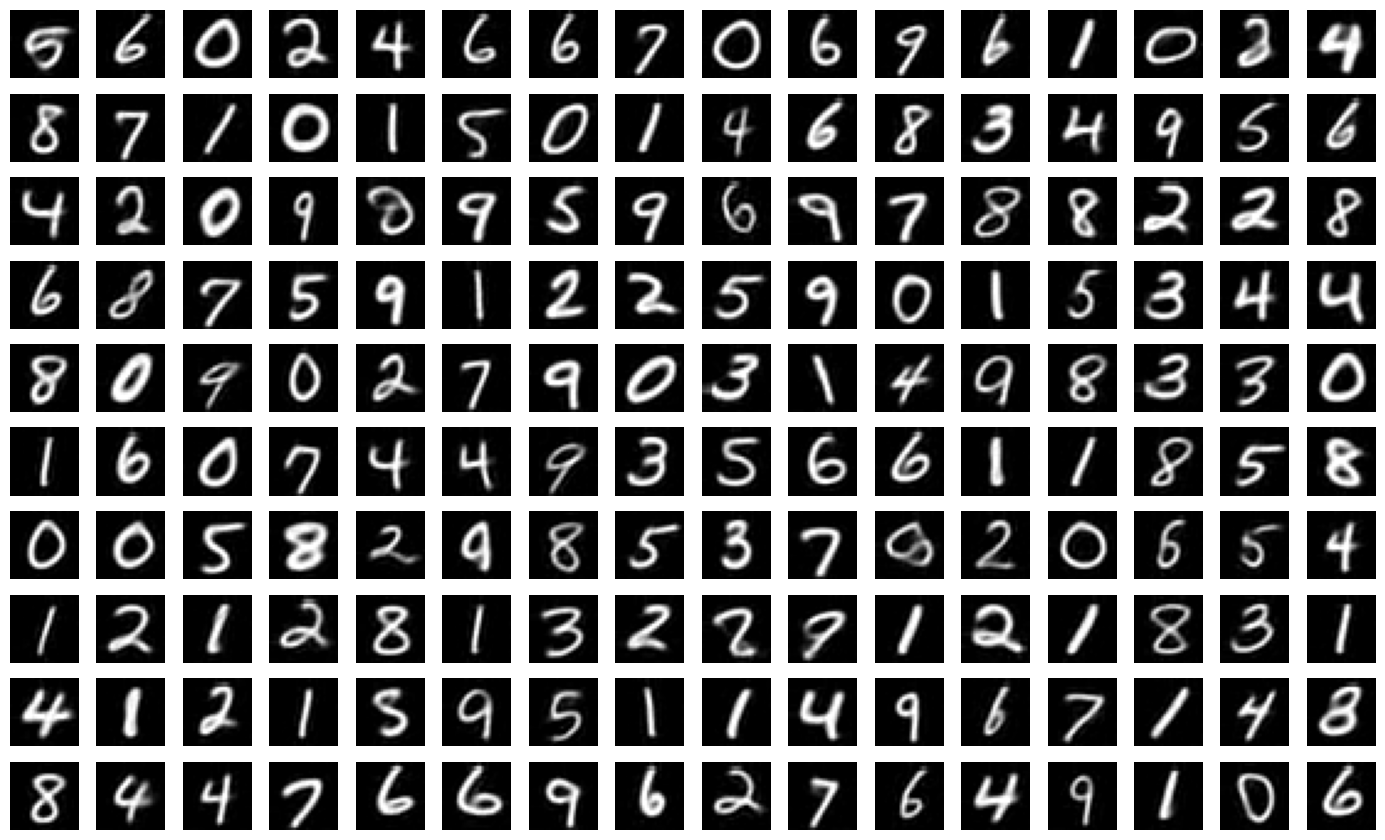

In [125]:
# Generate and classify images
import matplotlib.pyplot as plt
import random
from sigfig import round

width, height, w = 16, 10, 1.2
sigma = lambda t: torch.sqrt(1 - t)
y = random.choices([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], k=width*height)

flowmatching.eval()
flowmatching.to(device)
vae.eval()
vae.to(device)
classifier.eval()
classifier.to(device)
with torch.no_grad():
    x = generate_images(flowmatching, vae.decoder, height * width, sigma, labels=y, size=vae.z_shape, w=w, num_steps=100)
    y_pred = classifier(x)
    y_pred = torch.argmax(y_pred, dim=-1).cpu().numpy().squeeze()
    # density = calculate_density(vae, flowmatching, sigma, x, y=None, num_steps=50).cpu().numpy()

fig, axes = plt.subplots(height, width, figsize=(14, 8.5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    # ax.set_title(f"Label: {y[i]}, pred: {int(y_pred[i])}")
    # ax.text(14, 30, f"Density: {round(density[i], 3, notation='sci')}", fontsize=10, ha="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

This was achieved with vae dim12

Other experiments
---

Now that I have a system that generates numbers reliably, I will try to increase the resolution of the images and then use it to train a classifier.

  0%|          | 0/11 [00:00<?, ?it/s]

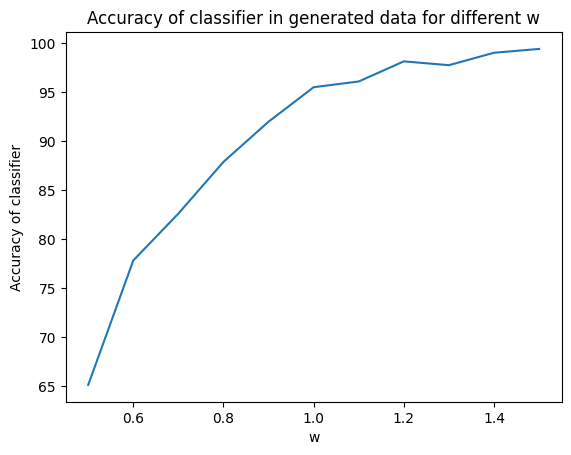

In [193]:
# How good is the classifier with the generated images?
import random
gen_batch_size = 256 * 4
sigma = lambda t: torch.sqrt(1 - t)
W = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

for model in [vae, flowmatching, classifier]:
    model.to(device)
    model.eval()

accuracies = []
with torch.no_grad():
    for w in tqdm(W):
        labels = random.choices(range(10), k=gen_batch_size)
        x = generate_images(flowmatching, vae.decode, gen_batch_size, sigma, labels=labels, size=vae.z_shape, w=w, num_steps=10)
        y = torch.tensor(labels, dtype=torch.long, device=device)
        _, acc = forward_classification(classifier, x, y, None)
        accuracies.append(acc.cpu())

plt.plot(W, accuracies)
plt.xlabel("w")
plt.ylabel("Accuracy of classifier")
plt.title("Accuracy of classifier in generated data for different w")
plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

loss: 2.3023, acc: 11.4583
loss: 1.8687, acc: 57.2917
loss: 1.7817, acc: 68.2292
loss: 1.6913, acc: 76.5625
loss: 1.6331, acc: 82.8125
loss: 1.5508, acc: 91.1458
loss: 1.5480, acc: 91.6667
loss: 1.5611, acc: 90.1042
loss: 1.4888, acc: 97.3958
loss: 1.5265, acc: 93.2292
loss: 1.5125, acc: 94.7917
loss: 1.5267, acc: 93.7500
loss: 1.5394, acc: 92.7083
loss: 1.5410, acc: 91.6667
loss: 1.4901, acc: 96.8750


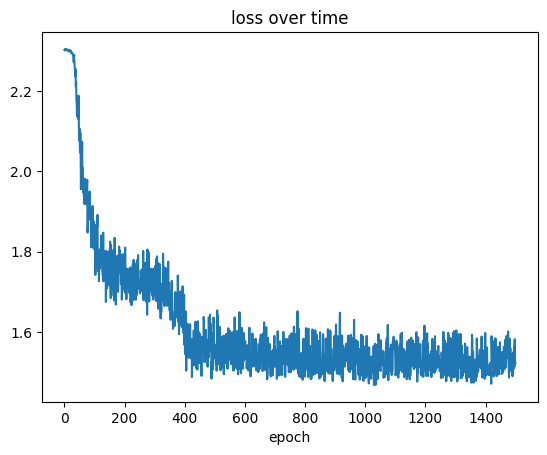

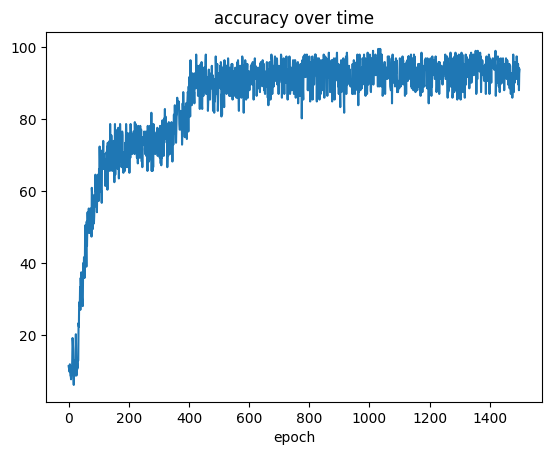

In [95]:
# Train classifier in generated data
from pytorch_lightning import Trainer
from torch import optim

# Move to cuda
for model in [vae, flowmatching]:
    model.to(device)
vae.sigma = vae.sigma.cpu()
losses = []
accuracies = []
# Hyperparameters
classifier = Classifier(d=16, k=6).to(device)
lr = 3e-3
total_epochs = 1500
sigma = lambda t: torch.sqrt(1 - t)
optimizer = optim.Adam(classifier.parameters(), lr=lr)
# Train loop
for epoch in tqdm(range(total_epochs)):
    # forward pass
    w = 0.8 + 0.4 * random.random()  # [0.8, 1.2]
    labels = random.choices(range(10), k=batch_size)
    x = generate_images(flowmatching, vae.decode, batch_size, sigma, labels=labels, size=vae.z_shape, w=w, device=device, num_steps=10)
    y = torch.tensor(labels, dtype=torch.long, device=device)
    loss, acc = forward_classification(classifier, x, y, None)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # results
    losses.append(loss.item())
    accuracies.append(acc.item())
    if epoch % 100 == 0:
        print(f"loss: {loss:.4f}, acc: {acc:.4f}")
# Plot results
plt.plot(range(total_epochs), losses)
plt.title("loss over time")
plt.xlabel("epoch")
plt.show()
plt.plot(range(total_epochs), accuracies)
plt.title("accuracy over time")
plt.xlabel("epoch")
plt.show()

In [105]:
# Test classifier on MNIST
classifier.to(device)
total_acc = 0
num_acc = 0
for x, y in test_loader:
    _, acc = forward_classification(classifier, x.to(device), y.to(device), None)
    total_acc += acc.item()
    num_acc += 1
print(f"Test classification score is: {total_acc/num_acc:.2f}%")

Test classification score is: 92.60%


Solving FashionMNIST
---

Images are also 28x28, and there are only 10 labels. I got ~90% classification accuracy and images look kinda blurry and don't have many details. I found it best not to use an autoencoder tho, and I found that VAEs completely die here.

In [101]:
# Architectures
import torch.nn.functional as F

class MBConv2d(nn.Module):
    """(B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection"""
    def __init__(self, d1, d2, d3, linear=True):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect"),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        if linear:
            self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x):
        if hasattr(self, "linear"):
            return self.linear(x) + self.network(x)
        return x + self.network(x)

class SpatialSelfAttentionModule(nn.Module):
    def __init__(self, d, k, n_heads, head_dim):
        """
        Args:
            d (int): Feature dimension at each spatial position.
            k (int): Factor for the MLP/MBConv layer
            n_heads (int): Number of attention heads.
            head_dim (int): Dimension of attention embedding (query/key/value)
        """
        super().__init__()
        self.d = d
        self.n_heads = n_heads
        self.head_dim = head_dim
        attn_dim = n_heads * head_dim

        self.q_proj = nn.Linear(d, attn_dim)
        self.k_proj = nn.Linear(d, attn_dim)
        self.v_proj = nn.Linear(d, attn_dim)
        self.out_proj = nn.Linear(attn_dim, d)

        self.mbconv = MBConv2d(d, k*d, d)

    def forward(self, x):
        B, d, h, w = x.shape
        x_flat = x.view(B, d, h * w).transpose(1, 2)  # (B, h*w, d)

        # (B, h*w, attn_dim)
        q = self.q_proj(x_flat)
        k = self.k_proj(x_flat)
        v = self.v_proj(x_flat)
        # (B, n_heads, h*w, head_dim)
        q = q.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, n_heads, h*w, h*w)
        attn = torch.softmax(scores, dim=-1)

        attended = torch.matmul(attn, v)  # (B, n_heads, h*w, head_dim)
        attended = attended.transpose(1, 2).contiguous().view(B, h*w, -1)  # (B, h*w, attn_dim)
        attended = self.out_proj(attended)  # (B, h*w, d)
        attended = attended.transpose(1, 2).view(B, d, h, w)  # (B, d, h, w)
        out = x + attended

        out = self.mbconv(out)  # (B, d, h, w)

        return out

class AutoEncoder(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=32, k=6, z_dim=12):  # or d=32, n=1 for small version
        super().__init__()
        self.z_shape = (z_dim, )
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//4, kernel_size=5, padding=2, stride=2),  
            nn.GELU(),
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 7x7
            MBConv2d(d//2, k*d, d),
            self.max,                   # -> 3x3
            # MBConv2d(d, k*d, d),
            nn.Flatten(1),                          
            nn.GELU(),
            nn.Linear(d*9, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 9*d),
            nn.Unflatten(-1, (d, 3, 3)),
            # MBConv2d(d, k*d, d),
            nn.Upsample(7),             # -> 7x7  
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                            
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class FlowMatching(nn.Module):
    """
    Learns to generate images in the encoded space of the saved autoencoder.
    shape of encoding: (B, 1, 7, 7)
    """
    def __init__(self, hidden_layer=150, z_dim=12):
        super().__init__()
        self.z_dim = z_dim
        self.network = nn.Sequential(
            nn.Linear(z_dim + 10 + 2, hidden_layer),
            nn.GELU(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_layer, z_dim),
        )

    def forward(self, x, t, y):
        """x: (B, 128),  t: (B, 1, 1, 1),  y: (B, 10)"""
        x = x.view(-1, self.z_dim)
        t = t.view(-1, 1)
        x = torch.cat((x, t, t**2, y), dim=1)
        return self.network(x)

class Classifier(nn.Module):
    def __init__(self, d1=12, d2=16, d3=32):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sm = nn.Softmax(dim=-1)
        self.network = nn.Sequential(
            nn.Conv2d(1, d1, kernel_size=3, padding=1),  # -> 28
            self.ac,
            self.max,                         # 14
            nn.Conv2d(d1, d2, kernel_size=3, padding=1),
            self.ac,
            self.max,                         # 7
            nn.Conv2d(d2, d3, kernel_size=3, padding=1),
            self.ac,
            self.max,                         # 3
            nn.Flatten(),
            nn.Linear(9*d3, 10),
        )

    def forward(self, x):
        x = self.network(x).view(-1, 10)
        return self.sm(x)

class FlowMatching2(nn.Module):
    """
    Learns to generate images directly
    """
    def __init__(self, d=32, k=4, n=1, n_heads=4, head_dim=16):
        super().__init__()
        self.z_dim = (1, 28, 28)
        self.d = d
        self.encoder = nn.Sequential(
            nn.Conv2d(3, d//2, kernel_size=5, padding=2),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(d//2, d, kernel_size=3, padding=1),  # (d, 14, 14)
        )
        self.network = nn.Sequential(
            *[SpatialSelfAttentionModule(d, k, n_heads=n_heads, head_dim=head_dim) for _ in range(n)],
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(d, d//2, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(d//2, 1, kernel_size=5, padding=2),
        )
        self.yemb = nn.Linear(10, 28, bias=False)
        self.temb = nn.Sequential(
            nn.Linear(1, 100),
            nn.GELU(),
            nn.Linear(100, 28),
        )

    def forward(self, x, t, y):
        """x: (B, 1, 28, 28),  t: (B, 1, 1, 1),  y: (B, 10)"""
        t = self.temb(t)
        t = t.view(-1, 1, 28, 1) * t.view(-1, 1, 1, 28)
        y = self.yemb(y)
        y = y.view(-1, 1, 28, 1) * y.view(-1, 1, 1, 28)
        x = torch.cat((x, t, y), dim=1)

        x = self.encoder(x)
        x = self.network(x)
        x = self.decoder(x)
        return x

import os
file_names = [
    # "MNIST_vae_dim12_small",
    # "MNIST_flowmatching_dim12_small",
    # "MNIST_classifier",
]
architectures = [
    # "VarAutoEncoder",
    # "FlowMatching",
    # "Classifier",
]
model_names = [
    # "vae",
    # "flowmatching",
    # "classifier",
]
for file_name, architecture, model_name in zip(file_names, architectures, model_names):
    exec(f"{model_name} = {architecture}().to(device)")
    save_path = os.path.join("..", "NN_parameters\\Generative models", file_name + ".pth")
    exec(f"{model_name}.load_state_dict(torch.load(save_path))")
    exec(f"{model_name}.eval()")
    exec(f"num_params = sum(p.numel() for p in {model_name}.parameters())")
    exec(f"print('Number of parameters in {model_name}: {num_params}')")

In [34]:
# Import datasets
from torchvision.transforms import ToTensor

torch.cuda.empty_cache()
batch_size = 256
train_dataset = datasets.FashionMNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(),
    )
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=16, pin_memory=True, persistent_workers=True,
)
test_dataset = datasets.FashionMNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(),
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    # num_workers=4, pin_memory=True, persistent_workers=False,
)

In [ ]:
# Train classifier  # 17.5k parameters, 91% in test set
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
classifier = Classifier(d1=12, d2=24, d3=48).to(device)
lr = 5e-3
total_epochs = 30
milestones = [15, 25]
gamma = 0.3
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = ClassifierModel(classifier, forward_classification, optimizer, scheduler)
trainer = Trainer(max_epochs=total_epochs, accelerator='auto')
# Train
trainer.fit(model,
            train_loader,
            # test_loader,
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Classifier | 17.5 K | train
---------------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [15, 25]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - val_acc: 91.0156


c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# Train autoencoder # d=32, k=6, z_dim=32, 93.2k parameters, mse=6.4 # d=64, k=6, z_dim=32, 148k parameters, L1=36.7
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
autoencoder = AutoEncoder(d=64, k=6, z_dim=32).to(device)
lr = 5e-3
total_epochs = 45
milestones = [15, 20, 25, 30, 34, 37, 40]
gamma = 0.7
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = GeneralModel(autoencoder, forward_autoencoding, optimizer, scheduler)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 41.7 K | train
----------------------------------------------
41.7 K    Trainable params
0         Non-trainable params
41.7 K    Total params
0.167     Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [15, 20, 25, 30, 34, 37, 40]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 85.3267
Epoch 1 - train_mse: 54.3438
Epoch 2 - train_mse: 47.7971
Epoch 3 - train_mse: 42.6192
Epoch 4 - train_mse: 39.9896
Epoch 5 - train_mse: 38.0528
Epoch 6 - train_mse: 40.9092



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

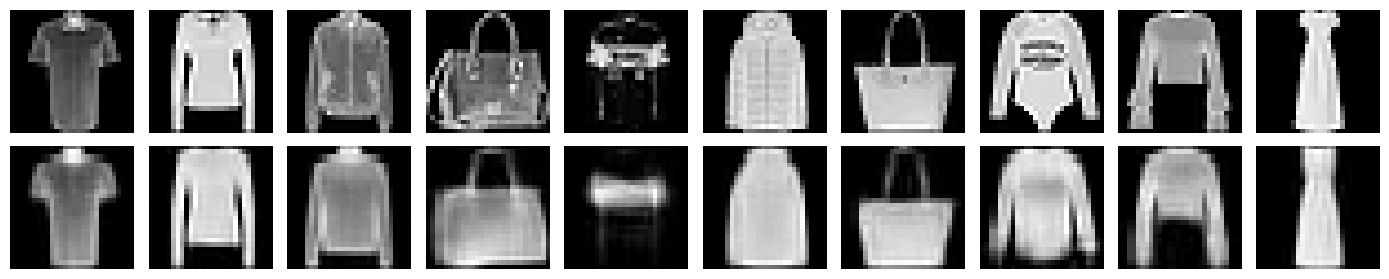

In [421]:
# Test reconstruction
import numpy as np

def aut_reconstruction(model, num_img=4):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            break
    x_hat = model(x.to(device))
    x_hat = torch.clip(x_hat.cpu().detach(), 0, 1)
    plot_images((x[:, 0].cpu().detach(), x_hat[:, 0]), figsize=(1.4*num_img, 3))

autoencoder.eval()
autoencoder.to(device)
aut_reconstruction(autoencoder, num_img=10)

In [426]:
# Initialize encoded dataset
encoded_dataset_x = torch.zeros(60000, *autoencoder.z_shape)  ###
encoded_dataset_y = torch.zeros(60000, dtype=torch.float64)
encoded_val_x = torch.zeros(10000, *autoencoder.z_shape)
encoded_val_y = torch.zeros(10000, dtype=torch.float64)
autoencoder.eval()
autoencoder.to(device)

# Pass one: record z and y in a list
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    idx = 0
    for x, y in train_loader:
        B = x.shape[0]
        z = autoencoder.encoder(x.to(device)).detach().cpu()
        encoded_dataset_x[idx: idx + B] = z
        encoded_dataset_y[idx: idx + B] = y
        idx += B

    idx = 0
    for x, y in test_loader:
        B = x.shape[0]
        z = autoencoder.encoder(x.to(device)).detach().cpu()
        encoded_val_x[idx: idx + B] = z
        encoded_val_y[idx: idx + B] = y
        idx += B

In [427]:
# Define encoded dataloader
class EncodedDataset(torch.utils.data.Dataset):
    """Given tensors of x and y, create a dataset that returns pairs"""
    def __init__(self, x_tensor, y_tensor):
        assert len(x_tensor) == len(y_tensor), "x and y must have the same length"
        self.x = x_tensor.cpu()
        self.y = y_tensor.cpu()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

torch.cuda.empty_cache()
encoded_dataset = EncodedDataset(encoded_dataset_x, encoded_dataset_y)
encoded_val = EncodedDataset(encoded_val_x, encoded_val_y)
encoded_train_loader = torch.utils.data.DataLoader(
    encoded_dataset, batch_size=batch_size, shuffle=True,
    # num_workers=16, pin_memory=True, persistent_workers=True,
)
encoded_val_loader = torch.utils.data.DataLoader(
    encoded_val, batch_size=batch_size, shuffle=False,
)

In [ ]:
# Train flowmatching model. mse loss is 0.166
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
flowmatching = FlowMatching2(d=32, k=5, n=2, n_heads=4, head_dim=6).to(device)
lr = 5e-3
total_epochs = 30
milestones = [10, 15, 20, 25]
gamma = 0.5
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(flowmatching.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = GeneralModel(flowmatching, forward_denoising, optimizer, scheduler)
trainer = Trainer(max_epochs=total_epochs, gradient_clip_val=10, gradient_clip_algorithm="value")  # exploiding gradients
# Train
trainer.fit(model,
            train_loader,
            # test_loader,
            # encoded_train_loader,
            # encoded_val_loader,
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | FlowMatching2 | 46.7 K | train
------------------------------------------------
46.7 K    Trainable params
0         Non-trainable params
46.7 K    Total params
0.187     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [10, 15, 20, 25]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 0.7796
Epoch 1 - train_mse: 0.4001
Epoch 2 - train_mse: 0.3197
Epoch 3 - train_mse: 0.2875
Epoch 4 - train_mse: 0.2640
Epoch 5 - train_mse: 0.2494
Epoch 6 - train_mse: 0.2451
Epoch 7 - train_mse: 0.2351
Epoch 8 - train_mse: 0.2263
Epoch 9 - train_mse: 0.2378
Epoch 10 - train_mse: 0.2145
Epoch 11 - train_mse: 0.2028
Epoch 12 - train_mse: 0.1988
Epoch 13 - train_mse: 0.1968
Epoch 14 - train_mse: 0.1920
Epoch 15 - train_mse: 0.1829
Epoch 16 - train_mse: 0.1812
Epoch 17 - train_mse: 0.1803
Epoch 18 - train_mse: 0.1782
Epoch 19 - train_mse: 0.1766
Epoch 20 - train_mse: 0.1721
Epoch 21 - train_mse: 0.1715
Epoch 22 - train_mse: 0.1711
Epoch 23 - train_mse: 0.1699
Epoch 24 - train_mse: 0.1682
Epoch 25 - train_mse: 0.1683
Epoch 26 - train_mse: 0.1673
Epoch 27 - train_mse: 0.1674
Epoch 28 - train_mse: 0.1678


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29 - train_mse: 0.1663


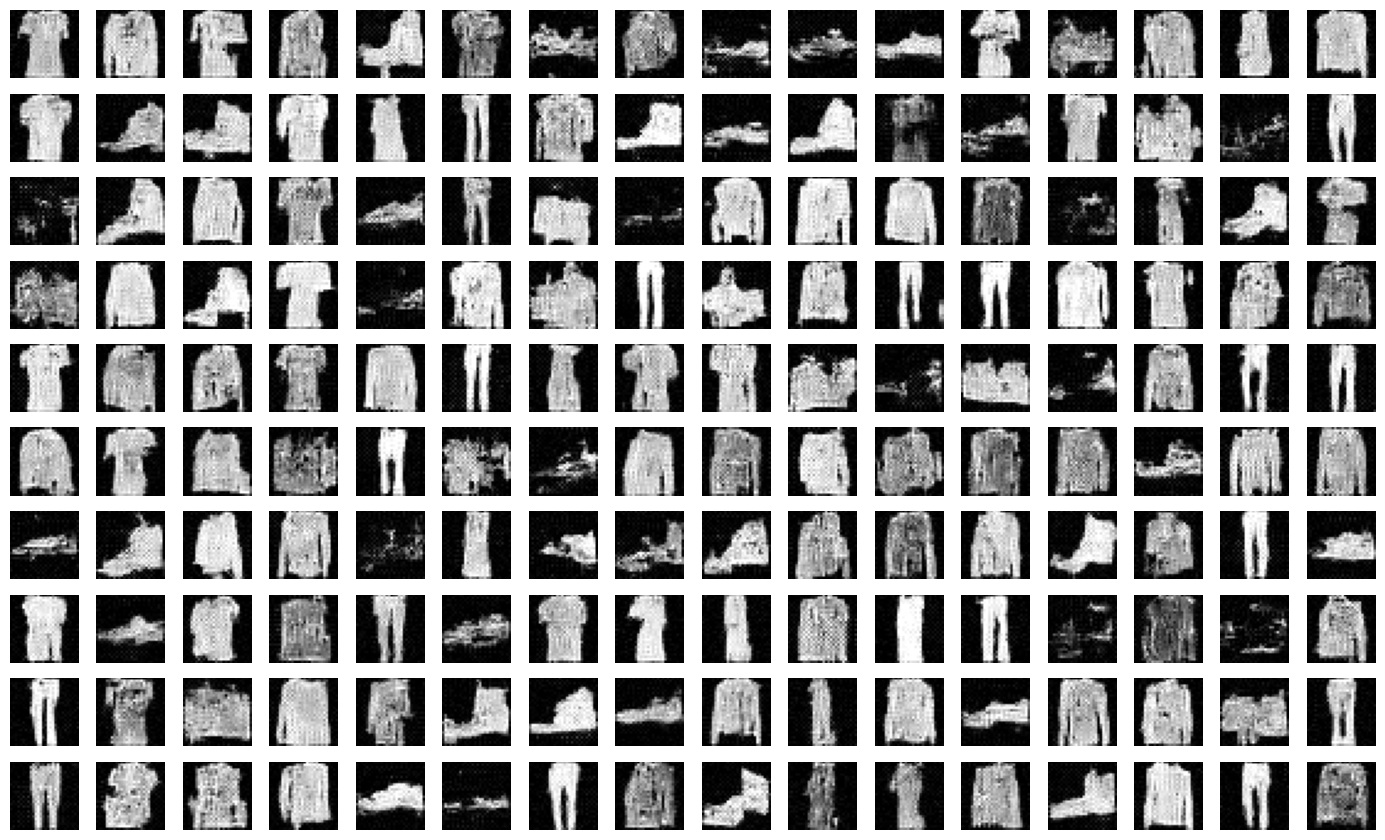

In [118]:
# Generate images
import matplotlib.pyplot as plt
import random

width, height, w = 16, 10, 1.5
sigma = lambda t: torch.sqrt(1 - t) * 1
y = random.choices(range(10), k=width*height)

for model in [
    flowmatching,
    # autoencoder,
    # classifier
]:
    model.to(device)
    model.eval()

with torch.no_grad():
    x = generate_images(flowmatching, lambda x: x, height * width, sigma, labels=y, size=(1, 28, 28), w=w, num_steps=50)
    # density = calculate_density(autoencoder, flowmatching, sigma, x, y=None, num_steps=50).cpu().numpy()

fig, axes = plt.subplots(height, width, figsize=(14, 8.5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().numpy().squeeze(), cmap="gray")
    # ax.set_title(f"Density: {round(density[i], 3, notation='sci')}")
    ax.axis("off")

plt.tight_layout()
plt.show()

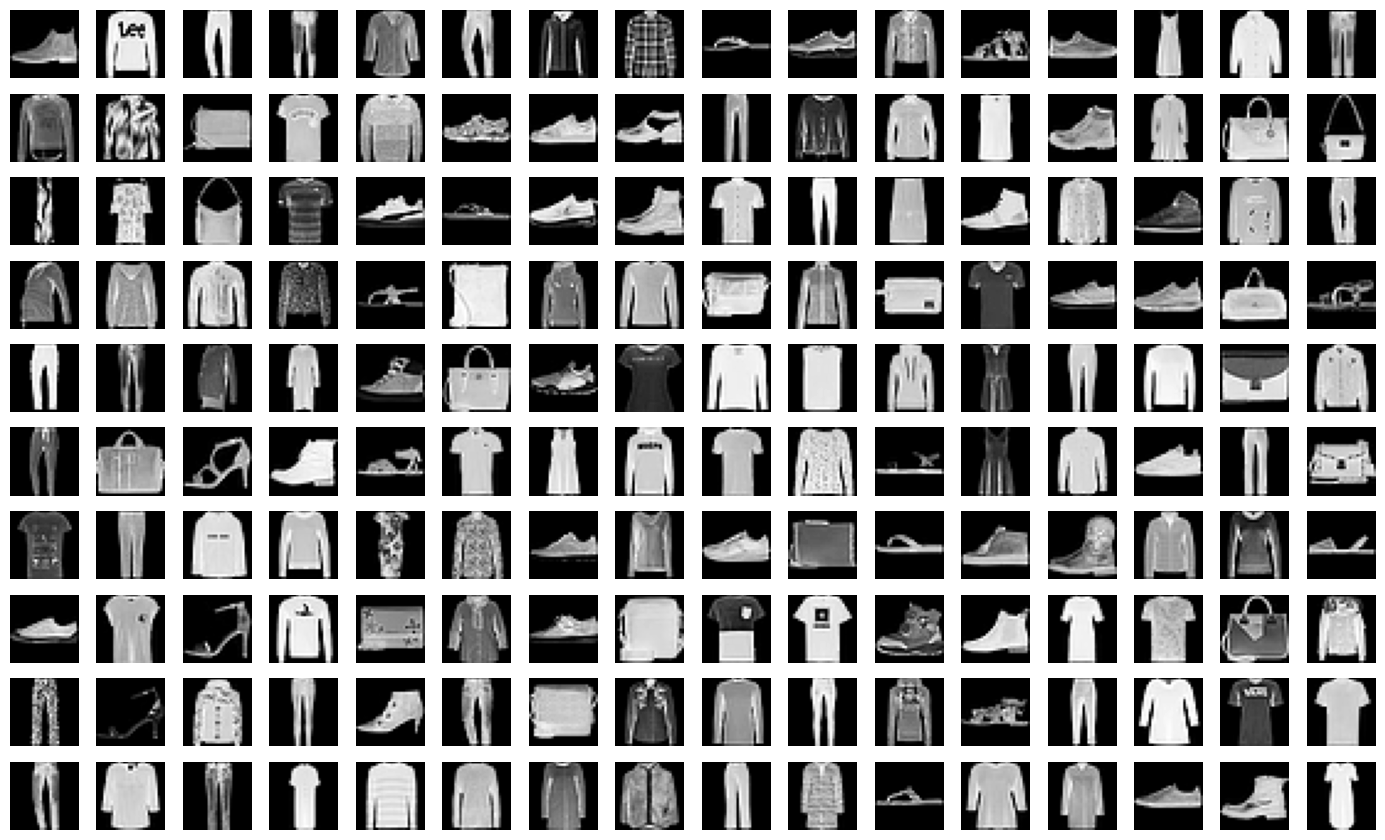

In [394]:
# Plot images from the dataset
import matplotlib.pyplot as plt

width, height, w = 16, 10, 1.2

images = torch.zeros(height * width, 1, 28, 28)
i = 0
for x, y in test_loader:
    if i + x.shape[0] >= height * width:
        images[i:] = x[:height * width - i]
        break
    images[i:i + x.shape[0]] = x
    i += x.shape[0]

fig, axes = plt.subplots(height, width, figsize=(14, 8.5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].cpu().numpy().squeeze(), cmap="gray")
    # ax.set_title(f"Density: {round(density[i], 3, notation='sci')}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Solving EMNIST
---

62 classes: 0-9, [a-z], [A-Z]. The training set (split='byclass') has ~700k images but half are numbers.

47 classes. The balanced version (split='balanced') has 3k images of each class, in total 131k.

Because of some dataloader issues, I need to do the transpose manually on training and inference.

Regarding the classifier, it's very easy (<20k params) to learn a function that achieves 86% accuracy in the test set. However, even when the training accuracy is > 99.99% and the CE loss is < 0.0019 (model with 140k params), the model doesn't improve at all, and in fact it gets worse. I achieved this with ~100 epochs starting at lr=2e-3 and using a factor gamma=0.6 every 6-7 epochs.

In [12]:
# Architectures
class MBConv2d(nn.Module):
    """(B, d1, h, w) -> (B, d2, h, w) -> (B, d3, h, w) with linear residual connection"""
    def __init__(self, d1, d2, d3, linear=True):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode="reflect"),
            nn.GELU(),
            nn.Conv2d(d2, d3, kernel_size=1),
        )
        if linear:
            self.linear = nn.Conv2d(d1, d3, kernel_size=1)

    def forward(self, x):
        if hasattr(self, "linear"):
            return self.linear(x) + self.network(x)
        return x + self.network(x)

class SelfAttention(nn.Module):
    def __init__(self, d, n_heads, head_dim):
        """
        Args:
            d (int): Feature dimension at each spatial position.
            n_heads (int): Number of attention heads.
            head_dim (int): Dimension of attention embedding (query/key/value)
        """
        super().__init__()
        self.d = d
        self.n_heads = n_heads
        self.head_dim = head_dim
        attn_dim = n_heads * head_dim

        self.q_proj = nn.Linear(d, attn_dim)
        self.k_proj = nn.Linear(d, attn_dim)
        self.v_proj = nn.Linear(d, attn_dim)
        self.out_proj = nn.Linear(attn_dim, d)

    def forward(self, x):
        B, d, h, w = x.shape
        x_flat = x.view(B, d, h * w).transpose(1, 2)  # (B, h*w, d)

        # (B, h*w, attn_dim)
        q = self.q_proj(x_flat)
        k = self.k_proj(x_flat)
        v = self.v_proj(x_flat)
        # (B, n_heads, h*w, head_dim)
        q = q.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, n_heads, h*w, h*w)
        attn = torch.softmax(scores, dim=-1)

        attended = torch.matmul(attn, v)  # (B, n_heads, h*w, head_dim)
        attended = attended.transpose(1, 2).contiguous().view(B, h*w, -1)  # (B, h*w, attn_dim)
        attended = self.out_proj(attended)  # (B, h*w, d)
        attended = attended.transpose(1, 2).view(B, d, h, w)  # (B, d, h, w)

        out = x + attended

        return out

class Conformer(nn.Module):
    """Does self attention followed by an MBConv layer.
    It's like a transformer layer, but with spacial convolution
    in the MLP part."""
    def __init__(self, d, k, n_heads, head_dim):
        super().__init__()
        self.attn = SelfAttention(d, n_heads, head_dim)
        self.conv = MBConv2d(d, k*d, d, linear=False)

    def forward(self, x):
        x = self.attn(x)
        x = self.conv(x)
        return x

class AutoEncoder(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=32, k=5):
        super().__init__()
        self.z_shape = (1, 7, 7)
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//4, kernel_size=5, padding=2, stride=2),  
            nn.GELU(),
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 7x7
            MBConv2d(d//2, k*d, d),
            nn.Conv2d(d, 1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                            
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VarAutoEncoder(nn.Module):
    """
    Class for autoencoder that learns an encoding of the MNIST dataset.
    shape of encoding: (B, 2, 7, 7)
    """
    def __init__(self, d=32, k=5, sigma=0.2):
        super().__init__()
        self.z_shape = (1, 7, 7)
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2)
        # define models
        self.encoder = nn.Sequential(
            nn.Conv2d(1, d//4, kernel_size=5, padding=2, stride=2),  
            nn.GELU(),
            MBConv2d(d//4, k*d//2, d//2),
            self.max,                   # -> 7x7
            MBConv2d(d//2, k*d, d),
            nn.Conv2d(d, 2, kernel_size=3, padding=1),
            # nn.Flatten(1),                          
            # nn.GELU(),
            # nn.Linear(d*9, 2*z_dim),
            # nn.Unflatten(-1, (2, z_dim, 1))
        )
        self.decoder = nn.Sequential(
            # nn.Flatten(1),
            # nn.Linear(z_dim, 2*9*d),
            # nn.Unflatten(-1, (2*d, 3, 3)),
            nn.Conv2d(1, d, kernel_size=3, padding=1),
            MBConv2d(d, k*d, d//2),
            self.up,                    # -> 14x14
            MBConv2d(d//2, k*d//2, d//4),
            self.up,                            
            nn.Conv2d(d//4, 1, kernel_size=5, padding=2),
        )
        self.sigma = torch.tensor(sigma, device=device, dtype=torch.float32, requires_grad=False)

    def get_encoding(self, x):
        repr = self.encoder(x)
        mu = repr[:, :1]
        log_var = repr[:, 1:]
        return mu, torch.exp(log_var) / 100

    def get_decoding(self, z):
        x_hat = self.decoder(z)
        return x_hat, self.sigma * torch.ones_like(x_hat)

    def encode(self, x, random=False):
        mu, var = self.get_encoding(x)
        ep = random * torch.normal(torch.zeros_like(mu), torch.ones_like(mu)).view(mu.shape)
        return mu + torch.sqrt(var) * ep

    def decode(self, z, random=False):  # no randomness
        x_hat, var = self.get_decoding(z)
        return x_hat

class Classifier(nn.Module):
    """Works on original images (1, 28, 28)"""
    def __init__(self, d1=48, d2=64, k=6, n=2, n_heads=6, head_dim=8):
        super().__init__()
        self.ac = nn.GELU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.network = nn.Sequential(
            nn.Conv2d(1, d1, kernel_size=5, padding=2, stride=2),  # 14
            self.ac,
            self.max,                         # 7
            nn.Conv2d(d1, d2, kernel_size=1),
            nn.Conv2d(d2, d2, kernel_size=3, padding=1, groups=d2, padding_mode='reflect'),
            self.ac,
            self.max,                         # 3
            *[Conformer(d2, k, n_heads=n_heads, head_dim=head_dim) for _ in range(n)],
            self.ac,
            self.max,
            nn.Flatten(),
            nn.Linear(d2, 47),
        )

    def forward(self, x):
        return self.network(x)

class EncodedClassifier(nn.Module):
    """Works on embedded space of shape (1, 7, 7)"""
    def __init__(self, d0=24, d=32, k=5, n=1, n_heads=2, head_dim=8):
        super().__init__()
        self.ac = nn.GELU()
        self.sm = nn.Softmax(dim=-1)
        self.network = nn.Sequential(
            nn.Conv2d(1, d0, kernel_size=3, padding=1),
            self.ac,
            nn.Conv2d(d0, d, kernel_size=3, padding=1),
            *[Conformer(d, k, n_heads=n_heads, head_dim=head_dim) for _ in range(n)],
            self.ac,
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 3x3
            nn.Flatten(),
            nn.Linear(9*d, 47),
        )

    def forward(self, x):
        x = self.network(x).view(-1, 47)
        return self.sm(x)

class FlowMatching(nn.Module):
    """
    Learns to generate images directly
    """
    def __init__(self, d=32, k=4, n=1, n_heads=4, head_dim=16):
        super().__init__()
        self.z_dim = (1, 28, 28)
        self.d = d
        self.encoder = nn.Sequential(
            nn.Conv2d(3, d//2, kernel_size=5, padding=2),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(d//2, d, kernel_size=3, padding=1),  # (d, 14, 14)
        )
        self.network = nn.Sequential(
            *[Conformer(d, k, n_heads=n_heads, head_dim=head_dim) for _ in range(n)],
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(d, d//2, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(d//2, 1, kernel_size=5, padding=2),
        )
        self.yemb = nn.Linear(10, 28, bias=False)
        self.temb = nn.Sequential(
            nn.Linear(1, 100),
            nn.GELU(),
            nn.Linear(100, 28),
        )

    def forward(self, x, t, y):
        """x: (B, 1, 28, 28),  t: (B, 1, 1, 1),  y: (B, 10)"""
        t = self.temb(t)
        t = t.view(-1, 1, 28, 1) * t.view(-1, 1, 1, 28)
        y = self.yemb(y)
        y = y.view(-1, 1, 28, 1) * y.view(-1, 1, 1, 28)
        x = torch.cat((x, t, y), dim=1)

        x = self.encoder(x)
        x = self.network(x)
        x = self.decoder(x)
        return x

import os
file_names = [
    "EMNIST_autoencoder_L1",
    # "MNIST_flowmatching_dim12_small",
    "EMNIST_classifier",
]
architectures = [
    "AutoEncoder",
    # "FlowMatching",
    "Classifier",
]
model_names = [
    "autoencoder",
    # "flowmatching",
    "classifier",
]
for file_name, architecture, model_name in zip(file_names, architectures, model_names):
    exec(f"{model_name} = {architecture}().to(device)")
    save_path = os.path.join("..", "NN_parameters\\Generative models", file_name + ".pth")
    exec(f"{model_name}.load_state_dict(torch.load(save_path))")
    exec(f"{model_name}.eval()")
    exec(f"num_params = sum(p.numel() for p in {model_name}.parameters())")
    exec(f"print('Number of parameters in {model_name}: {num_params}')")


Number of parameters in autoencoder: 26922
Number of parameters in classifier: 139951


In [ ]:
# Import datasets
from torchvision.transforms import ToTensor

class TransposeTransform:
    def __call__(self, x):
        return x.transpose(-1, -2)

torch.cuda.empty_cache()
batch_size = 256
train_dataset = datasets.EMNIST(
    root='../datasets', train=True, download=False, transform=ToTensor(), split='balanced',
    )
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=16, pin_memory=True, persistent_workers=True,
)
test_dataset = datasets.EMNIST(
    root='../datasets', train=False, download=False, transform=ToTensor(), split='balanced',
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    # num_workers=4, pin_memory=True, persistent_workers=False,
)

def label_name(y, balanced=True):
    """
    y: (B, ) array of labels
    returns: 1d list of str
    """
    def _name(idx, balanced):
        """Maps an index in [0, 61] to a str"""
        if idx < 10:  # numbers
            return str(idx)
        elif idx < 36:  # uppercase
            return chr(idx + 55)
        elif not balanced:  # lowercase
            return chr(idx + 61)
        # if balanced, need to adjust lowercase
        elif idx < 38:
            return chr(idx + 61)
        elif idx < 43:
            return chr(idx + 62)
        elif idx == 43:
            return "n"
        elif idx == 44:
            return "q"
        elif idx == 45:
            return "r"
        return "t"

    return [_name(idx.item(), balanced) for idx in y]

The train dataset has 112800 images.
['h', 'I', 'L', 'N', 'Y'] tensor([42, 18, 21, 23, 34])


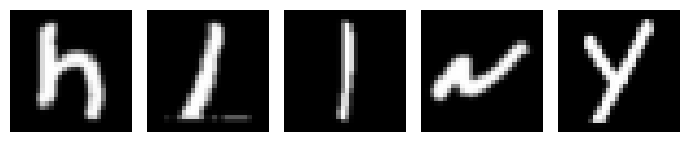

In [41]:
# Visualize dataset
print(f"The train dataset has {len(train_loader.dataset)} images.")
for x, y in test_loader:
    print(label_name(y[:5]), y[:5])
    plot_images((x[:5, 0], ), figsize=(1.4*5, 3))
    break

In [ ]:
# Train classifier. 86% top1 and 95.5% top2
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
# classifier = Classifier(d1=48, d2=64, k=6, n=2, n_heads=6, head_dim=8).to(device)
lr = 2e-3
total_epochs = 35
milestones = [8, 14, 20, 27]
gamma = 0.6
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = ClassifierModel(classifier, forward_classification, optimizer, scheduler, transpose=True)
trainer = Trainer(max_epochs=total_epochs, accelerator='auto', check_val_every_n_epoch=10)
# Train
trainer.fit(model, train_loader, test_loader)
trainer.test(model, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode
--------------------------------------------
0 | model | Classifier | 139 K  | eval
--------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.560     Total estimated model params size (MB)
0         Modules in train mode
36        Modules in eval mode


Training model. lr will decrease at epochs [8, 14, 20, 27]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0 - val_acc: 85.9375


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_acc: 99.97%, train_loss: 0.0041
Epoch 1 - train_acc: 99.97%, train_loss: 0.0039
Epoch 2 - train_acc: 99.97%, train_loss: 0.0037
Epoch 3 - train_acc: 99.97%, train_loss: 0.0036
Epoch 4 - train_acc: 99.97%, train_loss: 0.0035
Epoch 5 - train_acc: 99.97%, train_loss: 0.0033
Epoch 6 - train_acc: 99.98%, train_loss: 0.0032
Epoch 7 - train_acc: 99.98%, train_loss: 0.0031
Epoch 8 - train_acc: 99.98%, train_loss: 0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - val_acc: 86.0745
Epoch 9 - train_acc: 99.98%, train_loss: 0.0028
Epoch 10 - train_acc: 99.98%, train_loss: 0.0027
Epoch 11 - train_acc: 99.99%, train_loss: 0.0026
Epoch 12 - train_acc: 99.99%, train_loss: 0.0026
Epoch 13 - train_acc: 99.99%, train_loss: 0.0025
Epoch 14 - train_acc: 99.99%, train_loss: 0.0024
Epoch 15 - train_acc: 99.99%, train_loss: 0.0024
Epoch 16 - train_acc: 99.99%, train_loss: 0.0023
Epoch 17 - train_acc: 99.99%, train_loss: 0.0023
Epoch 18 - train_acc: 99.99%, train_loss: 0.0022


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 - val_acc: 86.0213
Epoch 19 - train_acc: 99.99%, train_loss: 0.0022
Epoch 20 - train_acc: 99.99%, train_loss: 0.0021
Epoch 21 - train_acc: 99.99%, train_loss: 0.0021
Epoch 22 - train_acc: 99.99%, train_loss: 0.0021
Epoch 23 - train_acc: 99.99%, train_loss: 0.0021
Epoch 24 - train_acc: 99.99%, train_loss: 0.0020
Epoch 25 - train_acc: 99.99%, train_loss: 0.0020
Epoch 26 - train_acc: 99.99%, train_loss: 0.0020
Epoch 27 - train_acc: 100.00%, train_loss: 0.0020
Epoch 28 - train_acc: 100.00%, train_loss: 0.0019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 - val_acc: 86.0000
Epoch 29 - train_acc: 99.99%, train_loss: 0.0019
Epoch 30 - train_acc: 100.00%, train_loss: 0.0019
Epoch 31 - train_acc: 100.00%, train_loss: 0.0019
Epoch 32 - train_acc: 100.00%, train_loss: 0.0019
Epoch 33 - train_acc: 100.00%, train_loss: 0.0019


`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34 - train_acc: 99.99%, train_loss: 0.0019


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        top1_acc             85.97872161865234
        top2_acc             95.31382751464844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'top1_acc': 85.97872161865234, 'top2_acc': 95.31382751464844}]

  0%|          | 0/4 [00:00<?, ?it/s]

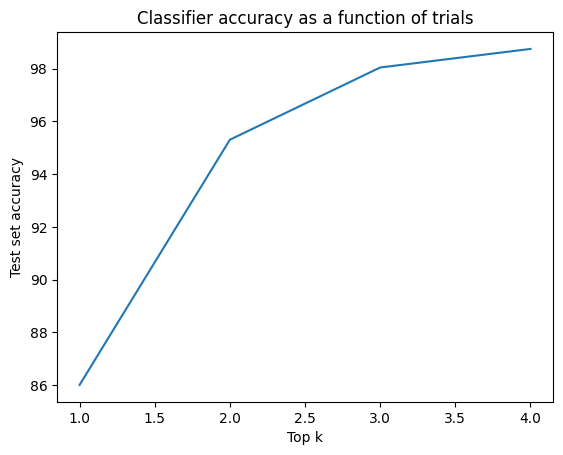

In [158]:
# accuracy as a function of topk
from tqdm.notebook import tqdm

classifier.to(device)
classifier.eval()
acc_per_try = []
topk_options = list(range(1, 5))
with torch.no_grad():
    for num_tries in tqdm(topk_options):
        total_acc = 0
        for x, y in test_loader:
            x, y = x.to(device).transpose(-1, -2), y.to(device)
            _, acc = forward_classification(classifier, x, y, topk=num_tries)
            total_acc += acc.item()
        acc_per_try.append(total_acc / len(test_loader))
plt.plot(topk_options, acc_per_try)
plt.title("Classifier accuracy as a function of trials")
plt.xlabel("Top k")
plt.ylabel("Test set accuracy")
plt.show()

In [ ]:
# Train autoencoder. L1=23.7 (3.7 when evaluated in L2). L2=3.2 (27.0 when evaluated in L1)
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
autoencoder = AutoEncoder(d=32, k=5).to(device)
lr = 5e-3
total_epochs = 25
milestones = [15, 20, 25, 30, 34, 37, 40]
gamma = 0.3
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = GeneralModel(autoencoder, forward_autoencoding, optimizer, scheduler, transpose=True)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader)
trainer.test(model, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightn

Training model. lr will decrease at epochs [15, 20, 25, 30, 34, 37, 40]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 15.3998
Epoch 1 - train_mse: 6.3388
Epoch 2 - train_mse: 5.3999
Epoch 3 - train_mse: 4.9548
Epoch 4 - train_mse: 4.6449
Epoch 5 - train_mse: 4.4118
Epoch 6 - train_mse: 4.2267
Epoch 7 - train_mse: 4.1044
Epoch 8 - train_mse: 3.9946
Epoch 9 - train_mse: 3.9013
Epoch 10 - train_mse: 3.8259
Epoch 11 - train_mse: 3.7504
Epoch 12 - train_mse: 3.6997
Epoch 13 - train_mse: 3.6182
Epoch 14 - train_mse: 3.5781
Epoch 15 - train_mse: 3.3753
Epoch 16 - train_mse: 3.3543
Epoch 17 - train_mse: 3.3385
Epoch 18 - train_mse: 3.3231
Epoch 19 - train_mse: 3.3116
Epoch 20 - train_mse: 3.2612
Epoch 21 - train_mse: 3.2546
Epoch 22 - train_mse: 3.2484
Epoch 23 - train_mse: 3.2418


`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24 - train_mse: 3.2337


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.2396013736724854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.2396013736724854}]

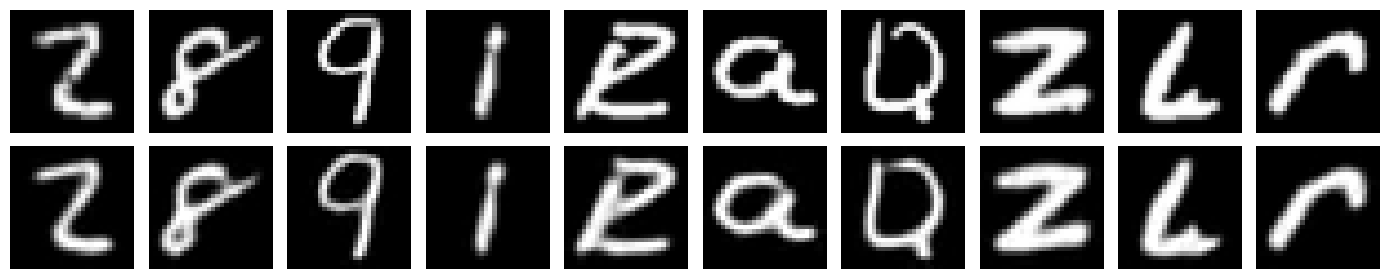

In [27]:
# Test reconstruction: L1 loss
import numpy as np

def aut_reconstruction(model, num_img=4, transpose=True):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            if transpose: x = x.transpose(-1, -2)
            break
    x_hat = model(x)
    x_hat = torch.clip(x_hat.cpu().detach(), 0, 1)
    plot_images((x[:, 0].cpu().detach(), x_hat[:, 0]), figsize=(1.4*num_img, 3))

autoencoder.eval()
autoencoder.to(device)
aut_reconstruction(autoencoder, num_img=10)

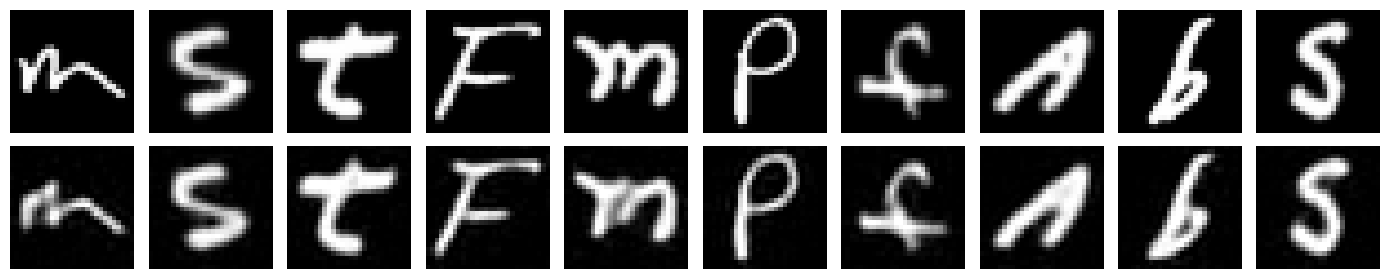

In [ ]:
# Test reconstruction: L2 loss
import numpy as np

def aut_reconstruction(model, num_img=4, transpose=True):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            if transpose: x = x.transpose(-1, -2)
            break
    x_hat = model(x)
    x_hat = torch.clip(x_hat.cpu().detach(), 0, 1)
    plot_images((x[:, 0].cpu().detach(), x_hat[:, 0]), figsize=(1.4*num_img, 3))

autoencoder.eval()
autoencoder.to(device)
aut_reconstruction(autoencoder, num_img=10)

In [131]:
# Train vae
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
vae = VarAutoEncoder(d=32, k=5, sigma=0.2).to(device)
lr = 5e-3
total_epochs = 25
milestones = [15, 20, 25, 30, 34, 37, 40]
gamma = 0.3
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(vae.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = VAEModel(vae, forward_var_aut, optimizer, scheduler, transpose=True)
trainer = Trainer(max_epochs=total_epochs)
# Train
trainer.fit(model, train_loader)
trainer.test(model, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | VarAutoEncoder | 27.2 K | train
-------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [15, 20, 25, 30, 34, 37, 40]


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - train_mse: 23.2927, train_kl: 71.5209
Epoch 1 - train_mse: 15.1862, train_kl: 69.8952
Epoch 2 - train_mse: 14.1522, train_kl: 70.0165
Epoch 3 - train_mse: 13.6777, train_kl: 70.0785
Epoch 4 - train_mse: 13.3253, train_kl: 70.0490
Epoch 5 - train_mse: 13.1002, train_kl: 70.0362
Epoch 6 - train_mse: 12.9666, train_kl: 70.0637
Epoch 7 - train_mse: 12.8365, train_kl: 69.9793



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

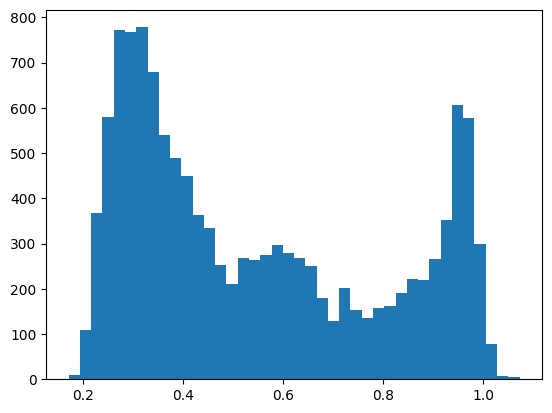

In [132]:
# Distribution of standard deviations of embedding space
for x, y in test_loader:
    x = x.transpose(-1, -2)
    break
vae.to(device)
mu, var = vae.get_encoding(x.to(device))

stds = torch.sqrt(var).reshape(-1).cpu().detach().numpy()
plt.hist(stds, bins=40)
plt.show()

Reconstructed images by the model look like this:


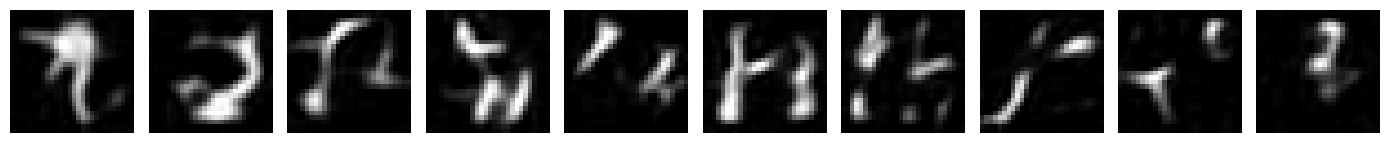

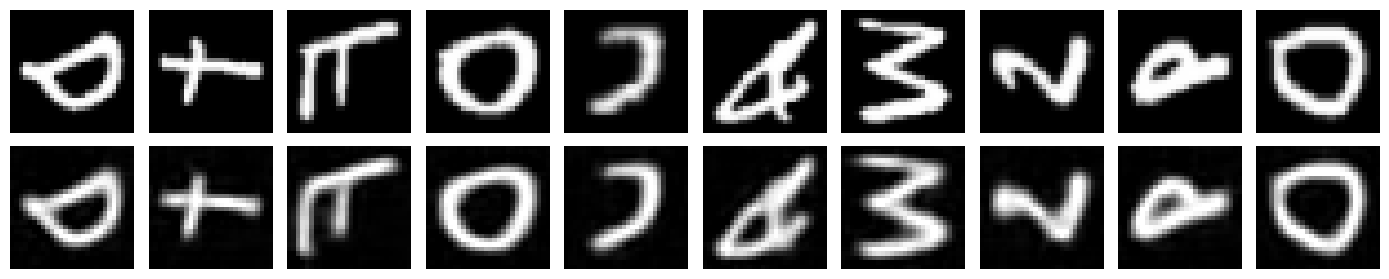

In [ ]:
# Test reconstruction: VAE
import numpy as np

def aut_generation(model, num_img=4):
    shape, dtype = (num_img, *model.z_shape), torch.float32
    z = torch.normal(torch.zeros(shape, dtype=dtype), torch.ones(shape, dtype=dtype)).view(shape).to(device)
    x_hat = torch.clip(model.decode(z)[:, 0], 0, 1)
    plot_images([x_hat.cpu().detach()], figsize=(1.4*num_img, 3))

def aut_reconstruction(model, randomness=0, num_img=4):
    """Grab random images, reconstruct them, and plot the results"""
    num_batch = np.random.randint(64)
    img_nums = np.random.randint(0, batch_size, size=num_img)
    for i, (x, y) in enumerate(test_loader):
        if i >= num_batch:
            x = x[img_nums].to(device)
            break
    z = model.encode(x, random=randomness)
    x_hat = model.decode(z)
    x_hat = torch.clip(x_hat.cpu().detach(), 0, 1)
    plot_images((x[:, 0].cpu().detach(), x_hat[:, 0]), figsize=(1.4*num_img, 3))

vae.eval()
vae.to(device)
vae.sigma.to(device)
print("Reconstructed images by the model look like this:")
aut_generation(vae, 10)
aut_reconstruction(vae, 0, num_img=10)

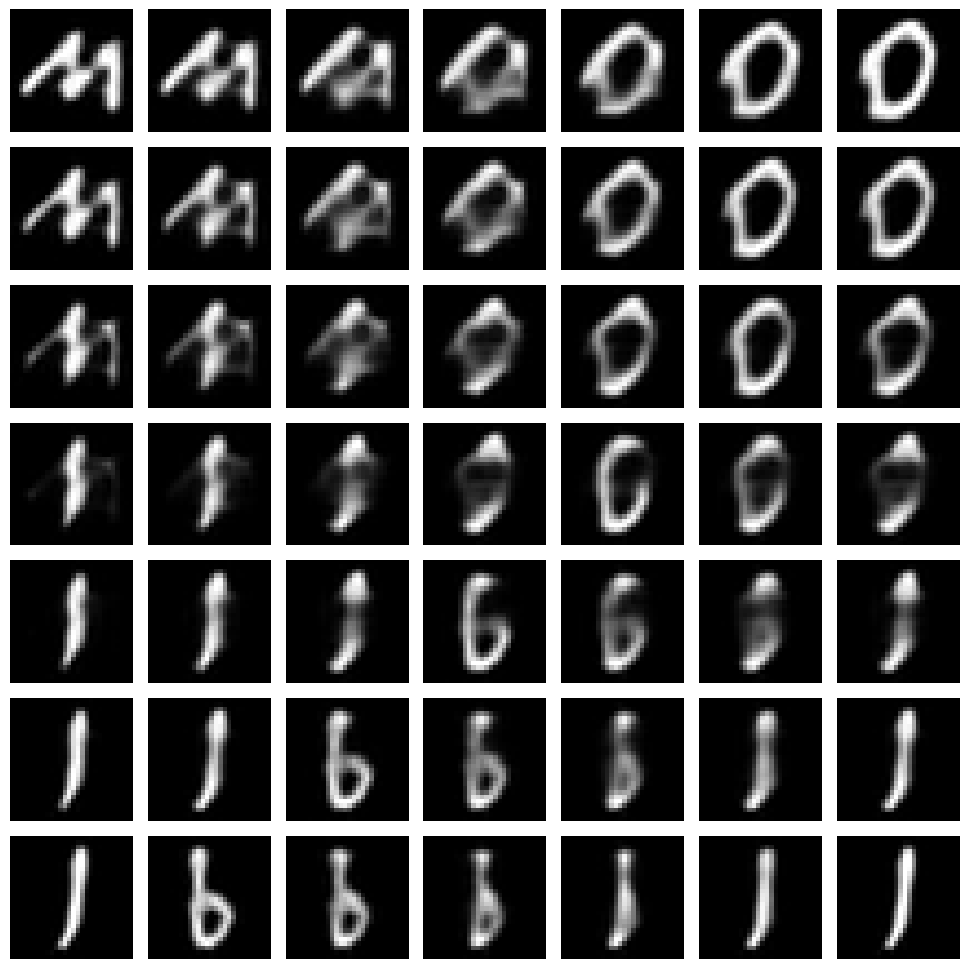

In [ ]:
# Test embedding space interpolation
vae.sigma.to(device)
vae.to(device)
plot_interpolation(vae, use_vae=True, s=3, scale=1.4, transpose=True)

In [14]:
# Initialize encoded dataset
encoded_dataset_x = torch.zeros(len(train_dataset), *autoencoder.z_shape)  ###
encoded_dataset_y = torch.zeros(len(train_dataset), dtype=torch.long)
encoded_val_x = torch.zeros(len(test_dataset), *autoencoder.z_shape)
encoded_val_y = torch.zeros(len(test_dataset), dtype=torch.long)
autoencoder.eval()
autoencoder.to(device)

# Save z and y in a single tensor
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    idx = 0
    for x, y in train_loader:
        B = x.shape[0]
        z = autoencoder.encoder(x.to(device).transpose(-1, -2)).detach().cpu()
        encoded_dataset_x[idx: idx + B] = z
        encoded_dataset_y[idx: idx + B] = y
        idx += B

    idx = 0
    for x, y in test_loader:
        B = x.shape[0]
        z = autoencoder.encoder(x.to(device).transpose(-1, -2)).detach().cpu()
        encoded_val_x[idx: idx + B] = z
        encoded_val_y[idx: idx + B] = y
        idx += B

In [25]:
# Define encoded dataloader

# import os
# os.environ["OMP_NUM_THREADS"] = "1"
# import torch.multiprocessing as mp
# mp.set_start_method("spawn")

class EncodedDataset(torch.utils.data.Dataset):
    """Given tensors of x and y, create a dataset that returns pairs"""
    def __init__(self, x_tensor, y_tensor):
        assert len(x_tensor) == len(y_tensor), "x and y must have the same length"
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

if __name__ == "__main__":
    torch.cuda.empty_cache()
    encoded_dataset_x.cpu()
    encoded_dataset_y.cpu()
    encoded_val_x.cpu()
    encoded_val_y.cpu()
    encoded_dataset = EncodedDataset(encoded_dataset_x, encoded_dataset_y)
    encoded_val = EncodedDataset(encoded_val_x, encoded_val_y)
    encoded_train_loader = torch.utils.data.DataLoader(
        encoded_dataset, batch_size=batch_size, shuffle=True,
        num_workers=16, pin_memory=False, persistent_workers=True,
    )
    encoded_val_loader = torch.utils.data.DataLoader(
        encoded_val, batch_size=batch_size, shuffle=False,
    )

In [26]:
# Train classifier in encoded space. 38k parameters, top1=70%, top3=75%
from pytorch_lightning import Trainer
from torch import optim

# Hyperparameters
classifier = EncodedClassifier(d0=24, d=32, k=5, n=1, n_heads=3, head_dim=8).to(device)
lr = 1e-3
total_epochs = 30
milestones = [13, 21, 27]
gamma = 0.4
print(f"Training model. lr will decrease at epochs {milestones}")
# Define scheduler
optimizer = optim.Adam(classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)
# Define Ligthning model
model = ClassifierModel(classifier, forward_classification, optimizer, scheduler, transpose=False)
trainer = Trainer(max_epochs=total_epochs, accelerator='auto')
# Train
if __name__ == "__main__":
    trainer.fit(model, encoded_train_loader)
    trainer.test(model, encoded_val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sofia\OneDrive - Massachusetts Institute of Technology\Non-Academic\Programming\py_env\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | EncodedClassifier | 36.0 K | train
----------------------------------------------------
36.0 K    Trainable params
0         Non-trainable params
36.0 K    Total params
0.144     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Training model. lr will decrease at epochs [13, 21, 27]


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 17028, 30400, 33152, 23736, 22736, 16780, 17244, 33004, 18024, 18088, 29576, 24112, 440, 26140, 13200, 3352) exited unexpectedly

Visualization
---

I have an ok model already. I'll do some plots of the flow over time and over space.

In [1]:
import os
from dotenv import load_dotenv
import torch
from EMNISTModels import AutoEncoder, FlowMatching, Classifier
from Datasets import load_EMNIST
torch.set_float32_matmul_precision('medium')
load_dotenv()

num_classes = 47
split = 'balanced'
batch_size = 512
device = 'cuda'

# load EMNIST
directory = "c:\\Users\\sofia\\OneDrive - Massachusetts Institute of Technology\\Non-Academic\\Programming"
root_path = os.path.join(directory, os.getenv("NIST_ROOT_PATH"))
# train_loader = load_EMNIST(
#     root_path, True, split, batch_size, num_workers=0,
# )
# test_loader = load_EMNIST(
#     root_path, False, split, batch_size, num_workers=8,
# )

# define model architecture
classifier = Classifier(
    d1=16, d2=24, k=5, n=1, n_heads=2, head_dim=8,
    n_class=num_classes,
).to(device)
classifier_checkpoint = os.path.join(directory, os.getenv("EMNIST_CLASSIFIER"))
classifier.load_state_dict(torch.load(classifier_checkpoint))
classifier.eval()

autoencoder = AutoEncoder(
    d1=24, d2=32, k=4, n=1, n_heads=3, head_dim=8, p_norm=1,
).to(device)
autoencoder_checkpoint = os.path.join(directory, os.getenv("EMNIST_AUTOENCODER_L1"))
autoencoder.load_state_dict(torch.load(autoencoder_checkpoint))
autoencoder.eval()

flow_nn = FlowMatching(
    d=48, k=5, n=2, n_heads=5, head_dim=8, n_class=num_classes,
    p=0.2, z_dim=7,
).to(device)
flow_checkpoint = os.path.join(directory, os.getenv("EMNIST_FLOWMATCHING"))
flow_nn.load_state_dict(torch.load(flow_checkpoint))
flow_nn.eval()

FlowMatching(
  (network): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): GELU(approximate='none')
    (2): Conformer(
      (attn): SelfAttention(
        (q_proj): Linear(in_features=48, out_features=40, bias=True)
        (k_proj): Linear(in_features=48, out_features=40, bias=True)
        (v_proj): Linear(in_features=48, out_features=40, bias=True)
        (out_proj): Linear(in_features=40, out_features=48, bias=True)
      )
      (conv): MBConv2d(
        (network): Sequential(
          (0): Conv2d(48, 240, kernel_size=(1, 1), stride=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=240, padding_mode=reflect)
          (3): GELU(approximate='none')
          (4): Conv2d(240, 48, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (3): Conformer(
      (attn): SelfAttention(
        (q_proj): Linear(in_features=48, out_features=40, bia

In [12]:
### Sample initial noise
from Utils import forward_flow, plot_images
from torch.nn.functional import one_hot
z_shape = autoencoder.z_shape
num_images = 50
labels = list(3 for _ in range(num_images))
w = 2
sigma_fn = lambda t: 0
num_steps_shown = 8
num_steps = 100
img_scale = 1
# sample random noise
ones = torch.empty((num_images, *z_shape), device=device, dtype=torch.float32)
z0 = torch.normal(torch.zeros_like(ones), torch.ones_like(ones))
# process labels
if labels is not None:
    labels = [k if k is not None else num_classes for k in labels]
    y = torch.tensor(labels, device=device)
    y = one_hot(y, num_classes=num_classes + 1).to(torch.float32)
    y = y[:, :-1]  # delete None label
else:
    y = torch.zeros((num_images, num_classes), dtype=torch.float32, device=device)

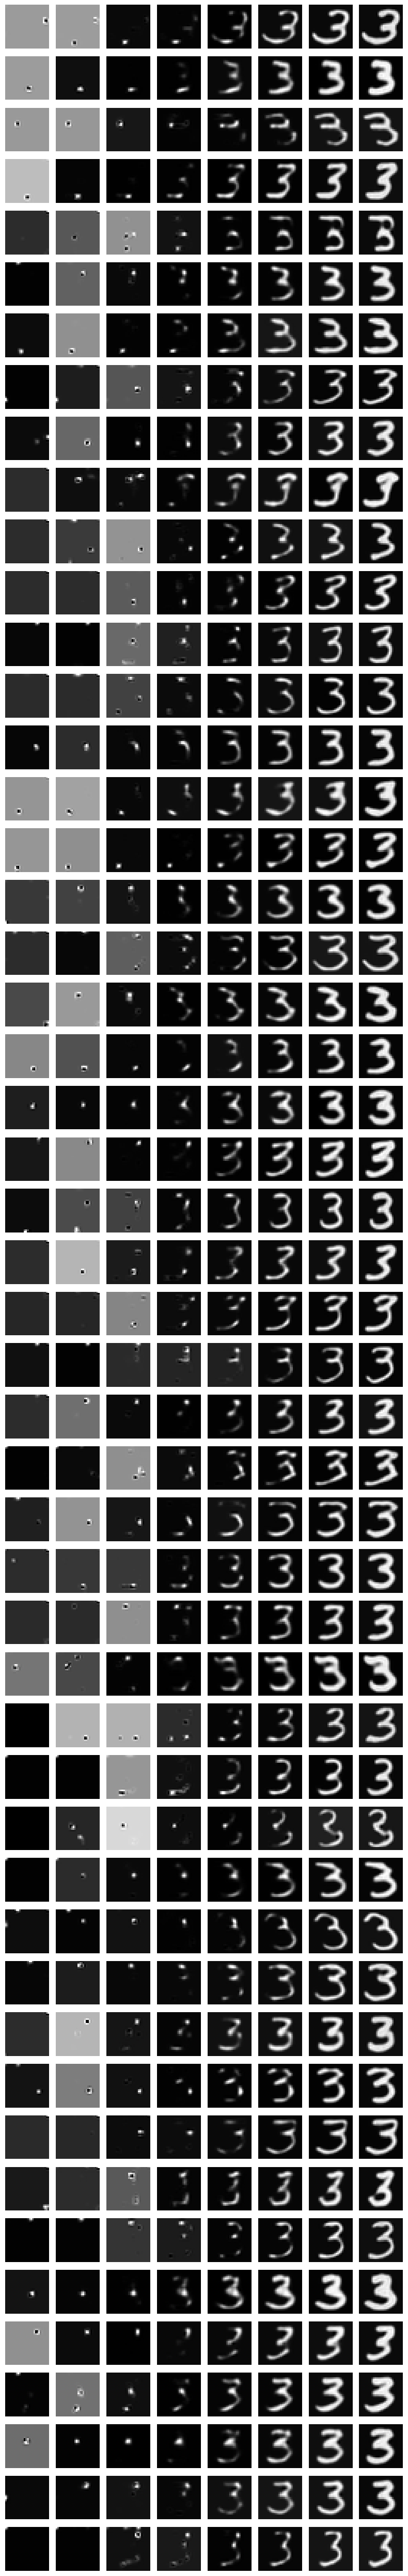

In [13]:
### Visualize intermediate diffussing steps
# solve SDE and recreate images
all_imgs = torch.empty((num_images, num_steps_shown, 28, 28))
inter_steps = torch.linspace(0, 1, num_steps_shown)
with torch.no_grad():
    z = z0
    x = autoencoder.decode(z).detach().cpu()  # (num_images, 1, 28, 28)
    all_imgs[:, 0] = x[:, 0]
    for i, (t0, t1) in enumerate(zip(inter_steps, inter_steps[1:]), start=1):
        z = forward_flow(flow_nn, z, y, w, sigma_fn, num_steps=num_steps//num_steps_shown, t0=t0, t1=t1)
        x = autoencoder.decode(z).detach().cpu()  # (num_images, 1, 28, 28)
        all_imgs[:, i] = x[:, 0]
# plot genereated images
plot_images(
    all_imgs.view(num_images, num_steps_shown, *all_imgs.shape[2:]),
    figsize=(img_scale * num_steps_shown, img_scale * num_images),
)

In [14]:
### Find time series of each pixel over time
import pandas as pd
# Run forward diffussion
diffussion_steps_tensor = torch.empty((num_images, num_steps, 28, 28))
intermediate_steps = torch.linspace(0, 1, num_steps)
with torch.no_grad():
    z = z0
    x = autoencoder.decode(z).detach().cpu()
    diffussion_steps_tensor[:, 0] = x[:, 0]
    for i, (t0, t1) in enumerate(zip(intermediate_steps, intermediate_steps[1:]), start=1):
        z = forward_flow(flow_nn, z, y, w, sigma_fn, num_steps=1, t0=t0, t1=t1)
        x = autoencoder.decode(z).detach().cpu()
        diffussion_steps_tensor[:, i] = x[:, 0]
# Extract all num_images * 784 time series
df = None
diffussion_steps_tensor = diffussion_steps_tensor.view((num_images, num_steps, -1))
value_cols = [f"pixel_{i}" for i in range(784)]
for img_num, diffussion_steps_img in enumerate(diffussion_steps_tensor):
    new_df = pd.DataFrame(diffussion_steps_img, columns=value_cols)
    new_df.insert(loc=0, column="time", value=intermediate_steps)
    new_df.insert(loc=1, column="image_num", value=img_num)
    try:
        df = pd.concat((df, new_df), axis=0)
    except:
        df = new_df
# df = pd.melt(df, id_vars=["time", "image_num"], value_vars=value_cols, var_name="pixel_num")
df.head()

time  image_num   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4  \
0  0.000000          0  0.000183  0.000126  0.000068  0.000068  0.000069   
1  0.010101          0  0.000191  0.000130  0.000068  0.000068  0.000069   
2  0.020202          0  0.000199  0.000133  0.000068  0.000068  0.000069   
3  0.030303          0  0.000206  0.000137  0.000068  0.000068  0.000069   
4  0.040404          0  0.000214  0.000141  0.000068  0.000068  0.000069   

    pixel_5   pixel_6   pixel_7  ...  pixel_774  pixel_775  pixel_776  \
0  0.000069  0.000069  0.000069  ...   0.000069   0.000069   0.000069   
1  0.000069  0.000069  0.000069  ...   0.000069   0.000069   0.000069   
2  0.000069  0.000069  0.000069  ...   0.000069   0.000069   0.000069   
3  0.000069  0.000069  0.000069  ...   0.000069   0.000069   0.000069   
4  0.000069  0.000069  0.000069  ...   0.000069   0.000069   0.000069   

   pixel_777  pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  
0   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069  
1   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069  
2   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069  
3   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069  
4   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069   0.000069  

[5 rows x 786 columns]

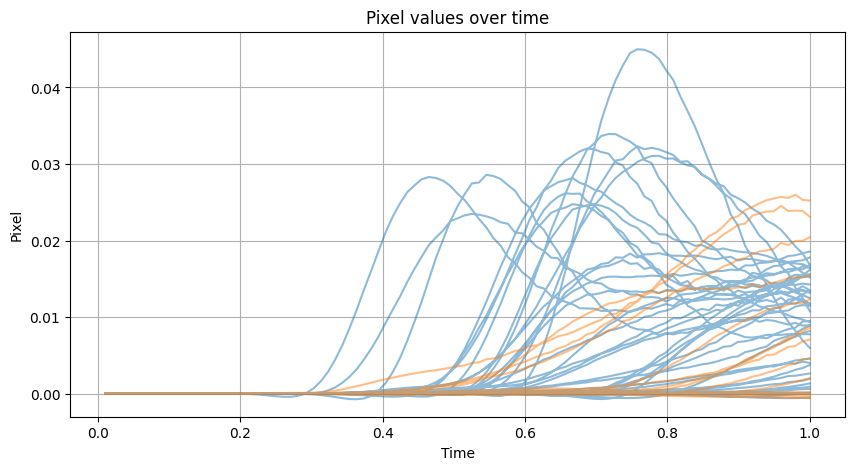

In [ ]:
import matplotlib.pyplot as plt
import random

pixel = 247
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
imgdf = df.set_index('time')
imgdf.groupby('image_num').diff().plot(
    y=random.sample(value_cols, k=2),
    legend=False,
    alpha=0.5,
    grid=True,
    ax=ax,
    # color=f'C{pixel}',
)
ax.set_title(f"Pixel values DoD differences")
ax.set_xlabel("Time")
ax.set_ylabel("Pixel")
# ax.legend(loc='best')
plt.show()